In [315]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

In [251]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score, f1_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

In [197]:
from catboost import CatBoostClassifier

### Download and analysis data

In [321]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [10]:
train_data.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [11]:
train_data.tail()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
5277,3,30.40,82.15,Male,0,No,No,No,No phone service,DSL,No,No,No,Yes,No,No,Month-to-month,No,Electronic check,0
5278,50,44.45,2188.45,Male,0,Yes,No,No,No phone service,DSL,Yes,No,No,Yes,Yes,No,One year,Yes,Bank transfer (automatic),0
5279,1,55.05,55.05,Male,0,No,No,Yes,No,DSL,No,No,Yes,Yes,No,No,Month-to-month,No,Mailed check,0
5280,29,76.00,2215.25,Female,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),0
5281,19,75.90,1375.6,Female,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,0


In [8]:
# Numerical features
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Categorical features
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [177]:
for col in train_data.columns:
    print(col, ':', train_data[col].unique())

ClientPeriod : [55 72  1 32 60 25 27 50 16 70 69 26 38 30 52 71 59 61  7 20 48 22  2 21
 44 66 58 46 45  5  4  3 62  6 39 68 51 40 10 43 12 35 31 67  8 11 29 37
 33 14 15 47 23 65 13 41 53  9 64 42 34 17 18 63 56 54 24 28 49 19 57 36
  0]
MonthlySpending : [ 19.5   25.85  75.9  ... 112.25 117.5   98.2 ]
TotalSpent : ['1026.35' '1872.2' '75.9' ... '55.05' '2215.25' '1375.6']
Sex : ['Male' 'Female']
IsSeniorCitizen : [0 1]
HasPartner : ['Yes' 'No']
HasChild : ['Yes' 'No']
HasPhoneService : ['Yes' 'No']
HasMultiplePhoneNumbers : ['No' 'Yes' 'No phone service']
HasInternetService : ['No' 'Fiber optic' 'DSL']
HasOnlineSecurityService : ['No internet service' 'No' 'Yes']
HasOnlineBackup : ['No internet service' 'No' 'Yes']
HasDeviceProtection : ['No internet service' 'No' 'Yes']
HasTechSupportAccess : ['No internet service' 'Yes' 'No']
HasOnlineTV : ['No internet service' 'No' 'Yes']
HasMovieSubscription : ['No internet service' 'No' 'Yes']
HasContractPhone : ['One year' 'Two year' 'Month-to

In [178]:
for df in [train_data, test_data]:
    df['TotalSpent'] = df['TotalSpent'].replace(' ', 0)
    df['TotalSpent'] = df['TotalSpent'].astype(float)

In [156]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   float64
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

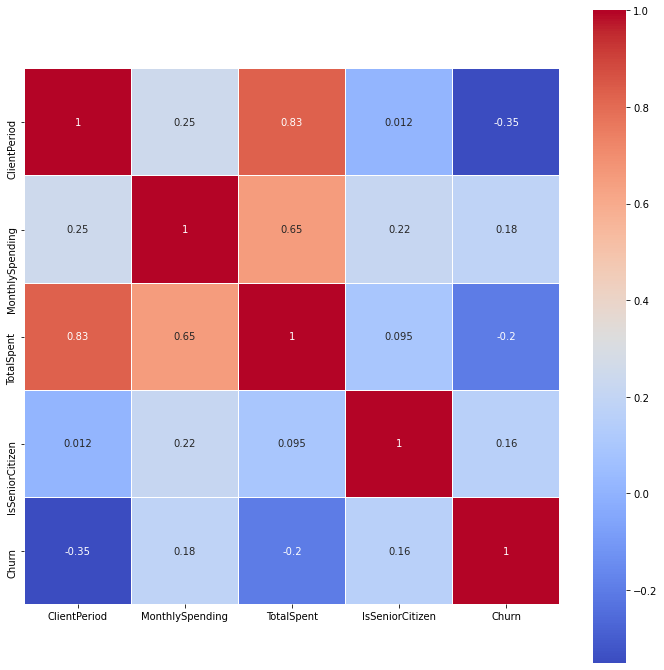

In [30]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(train_data.corr(), annot=True, linewidths=.1, cmap="coolwarm", square=True);

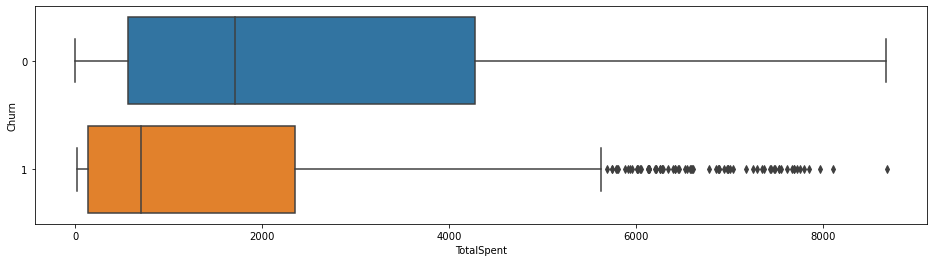

In [40]:
fig, ax = plt.subplots(figsize=(16, 4))
sns.boxplot(x=train_data.TotalSpent, y=train_data.Churn, orient='h');

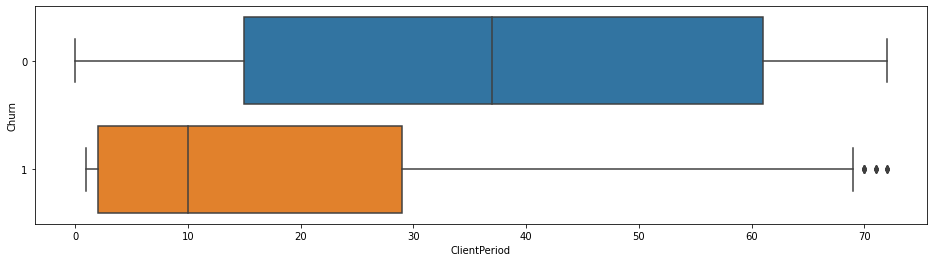

In [41]:
fig, ax = plt.subplots(figsize=(16, 4))
sns.boxplot(x=train_data.ClientPeriod, y=train_data.Churn, orient='h');

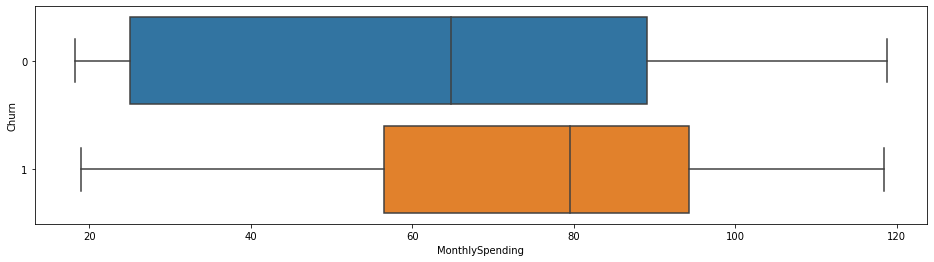

In [42]:
plt.figure(figsize=(16, 4))
sns.boxplot(x=train_data.MonthlySpending, y=train_data.Churn, orient='h');

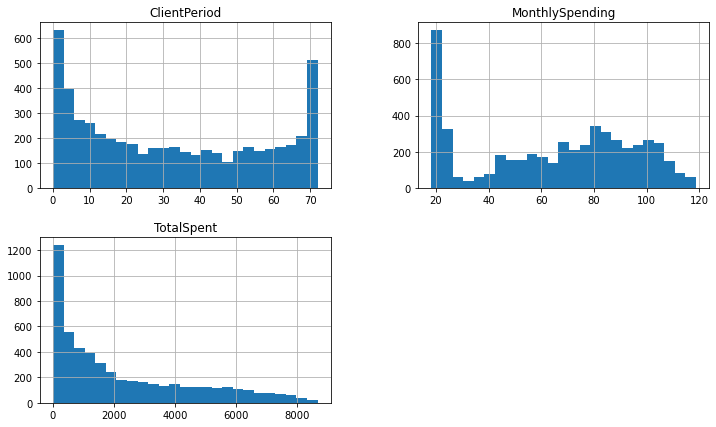

In [54]:
train_data[num_cols].hist(num_cols, figsize=(12, 7), bins=25);

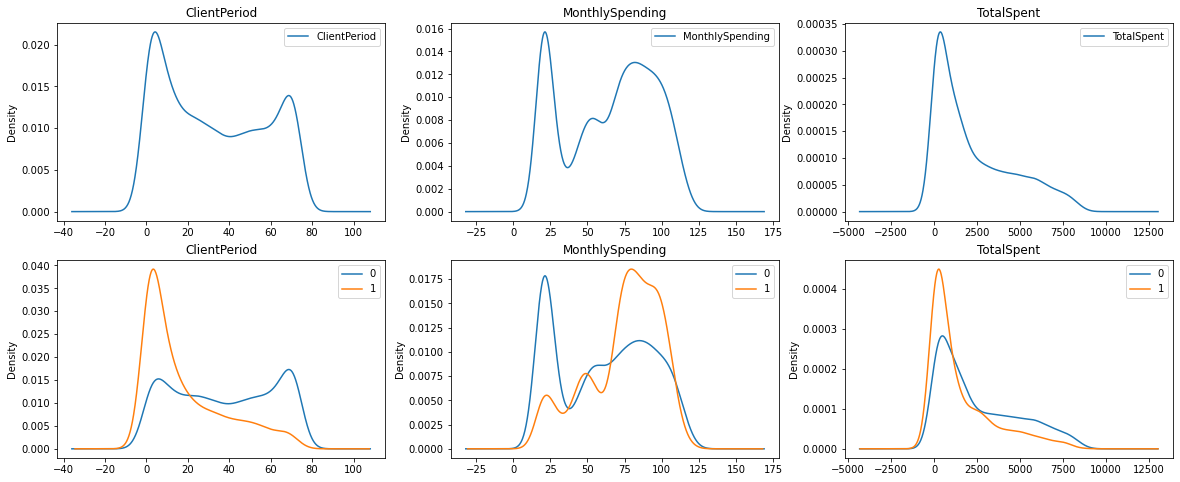

In [64]:
fig, axs = plt.subplots(ncols=len(num_cols), nrows=2, figsize=(20, 8))
for i, col in enumerate(num_cols):
    train_data[col].plot(kind='kde', ax=axs[0][i], title=col, legend=True)
    train_data.groupby('Churn')[col].plot(kind='kde', ax=axs[1][i], title=col, legend=True)

## Models


In [79]:
def allscores(y_true, y_pred):
    print('mse:', mean_squared_error(y_true, y_pred))
    print('f1:', f1_score(y_true, y_pred))
    print('rocauc:', roc_auc_score(y_true, y_pred))

In [80]:
def write_to_submission_file(predicted_labels, out_file, target='Churn', index_label="Id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(len(predicted_labels)),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [306]:
def ohe(data, numerical, categorical):
    dummy_features = pd.get_dummies(data[categorical])
    return pd.concat([data[numerical], dummy_features], axis=1)

In [83]:
def standardize(df, features):
    pass

### Logistic Regression

In [179]:
X = train_data.drop(columns='Churn')
y = train_data['Churn']

In [180]:
X = ohe(X, num_cols, cat_cols)
test_df_ohe = ohe(test_data, num_cols, cat_cols)

In [181]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [182]:
# Logistic Regression

cls = LogisticRegression(random_state=42)

cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)

In [183]:
allscores(y_test, y_pred)

mse: 0.21381267738883633
f1: 0.5603112840466925
rocauc: 0.6966840052015606


In [184]:
# Logistic Regression CV

cls = LogisticRegressionCV(scoring='roc_auc', cv=5, refit=True, n_jobs=-1, random_state=42)

cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)

In [185]:
allscores(y_test, y_pred)

mse: 0.21475875118259224
f1: 0.5592233009708738
rocauc: 0.6960338101430429


In [186]:
# Grid Search CV

model = LogisticRegression()
parameters = {
              'C': [1000, 100, 10, 1, 0.1, 0.01, 0.001],
              'solver': ['lbfgs', 'saga'],
              'penalty': ['l1', 'l2', 'elasticnet'],
              'class_weight': [{0:1,1:3}, {0:1,1:2}],
              'random_state': [42]
            }
              
model_cv = GridSearchCV(model, 
                        param_grid=parameters, 
                        cv=5,
                        n_jobs=-1
                       )
model_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1000, 100, 10, 1, 0.1, 0.01, 0.001],
                         'class_weight': [{0: 1, 1: 3}, {0: 1, 1: 2}],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'random_state': [42], 'solver': ['lbfgs', 'saga']})

In [187]:
print("best parameters: ", model_cv.best_params_)
print("best_score: ", model_cv.best_score_)

best parameters:  {'C': 0.01, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs'}
best_score:  0.781301775147929


In [188]:
y_pred = model_cv.predict(X_test)
allscores(y_test, y_pred)

mse: 0.2336802270577105
f1: 0.6134585289514867
rocauc: 0.7394975437075567


In [199]:
model_cv.best_estimator_.fit(X,y)
prediction = model_cv.best_estimator_.predict_proba(test_df_ohe)[:, 1]
prediction

array([0.10821832, 0.79557926, 0.82970224, ..., 0.86302884, 0.76906618,
       0.03257034])

In [200]:
write_to_submission_file(prediction, 'prediction_logregcv.csv')

### Cat Boost Classifier

In [202]:
X = train_data.drop(columns=['Churn'])
y = train_data['Churn']

In [204]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [210]:
model = CatBoostClassifier(cat_features=cat_cols, random_seed=42)
model.fit(X_train, y_train, verbose=False)

In [212]:
y_pred = model.predict(X_test)
allscores(y_test, y_pred)

mse: 0.22043519394512773
f1: 0.5215605749486653
rocauc: 0.675785687239682


In [246]:
# CatBoost with grid_search
parameters = { 'iterations': [100],
          'l2_leaf_reg': [1, 3, 5, 10],
          'learning_rate': [0.001, 0.01, 0.1],
          'depth': [3, 5, 7, 10],
          'loss_function': ['CrossEntropy', 'Logloss', 'MultiClass']
         }

In [224]:
model = CatBoostClassifier(cat_features=cat_cols, random_seed=42, verbose=False)

result_grid_search = model.grid_search(parameters,
                                       X=X_train,
                                       y=y_train)


bestTest = 0.64817238
bestIteration = 99

0:	loss: 0.6481724	best: 0.6481724 (0)	total: 1.65s	remaining: 1m 17s

bestTest = 0.471899925
bestIteration = 99

1:	loss: 0.4718999	best: 0.4718999 (1)	total: 3.31s	remaining: 1m 16s

bestTest = 0.4206852846
bestIteration = 96

2:	loss: 0.4206853	best: 0.4206853 (2)	total: 4.96s	remaining: 1m 14s

bestTest = 0.6481913964
bestIteration = 99

3:	loss: 0.6481914	best: 0.4206853 (2)	total: 6.59s	remaining: 1m 12s

bestTest = 0.4824698167
bestIteration = 99

4:	loss: 0.4824698	best: 0.4206853 (2)	total: 8.24s	remaining: 1m 10s

bestTest = 0.4230375568
bestIteration = 99

5:	loss: 0.4230376	best: 0.4206853 (2)	total: 9.88s	remaining: 1m 9s

bestTest = 0.6483094712
bestIteration = 99

6:	loss: 0.6483095	best: 0.4206853 (2)	total: 11.6s	remaining: 1m 7s

bestTest = 0.4741353463
bestIteration = 99

7:	loss: 0.4741353	best: 0.4206853 (2)	total: 13.2s	remaining: 1m 6s

bestTest = 0.4253875692
bestIteration = 95

8:	loss: 0.4253876	best: 0.4206853 (2)	to

In [231]:
model = CatBoostClassifier(cat_features=cat_cols, random_seed=42)

cat_cv = GridSearchCV(model, 
                      param_grid=parameters, 
                      cv=3)

cat_cv.fit(X_train, y_train)

0:	learn: 0.6927621	total: 11.4ms	remaining: 1.13s
1:	learn: 0.6923727	total: 23.5ms	remaining: 1.15s
2:	learn: 0.6919861	total: 34.6ms	remaining: 1.12s
3:	learn: 0.6916065	total: 51.4ms	remaining: 1.23s
4:	learn: 0.6912228	total: 66.3ms	remaining: 1.26s
5:	learn: 0.6908439	total: 82.1ms	remaining: 1.28s
6:	learn: 0.6904706	total: 96.8ms	remaining: 1.29s
7:	learn: 0.6900909	total: 113ms	remaining: 1.3s
8:	learn: 0.6897155	total: 127ms	remaining: 1.29s
9:	learn: 0.6893305	total: 142ms	remaining: 1.28s
10:	learn: 0.6889441	total: 156ms	remaining: 1.27s
11:	learn: 0.6885819	total: 171ms	remaining: 1.25s
12:	learn: 0.6882403	total: 186ms	remaining: 1.25s
13:	learn: 0.6878770	total: 201ms	remaining: 1.23s
14:	learn: 0.6875078	total: 216ms	remaining: 1.22s
15:	learn: 0.6871398	total: 233ms	remaining: 1.22s
16:	learn: 0.6867619	total: 249ms	remaining: 1.21s
17:	learn: 0.6864031	total: 265ms	remaining: 1.21s
18:	learn: 0.6860491	total: 280ms	remaining: 1.2s
19:	learn: 0.6857022	total: 295ms	re

71:	learn: 0.6681820	total: 1.14s	remaining: 443ms
72:	learn: 0.6678423	total: 1.16s	remaining: 427ms
73:	learn: 0.6675242	total: 1.17s	remaining: 413ms
74:	learn: 0.6671876	total: 1.19s	remaining: 396ms
75:	learn: 0.6668538	total: 1.21s	remaining: 381ms
76:	learn: 0.6665377	total: 1.22s	remaining: 365ms
77:	learn: 0.6662208	total: 1.24s	remaining: 349ms
78:	learn: 0.6658962	total: 1.25s	remaining: 333ms
79:	learn: 0.6656037	total: 1.27s	remaining: 318ms
80:	learn: 0.6652901	total: 1.28s	remaining: 302ms
81:	learn: 0.6649843	total: 1.3s	remaining: 286ms
82:	learn: 0.6646592	total: 1.32s	remaining: 270ms
83:	learn: 0.6643531	total: 1.33s	remaining: 254ms
84:	learn: 0.6640352	total: 1.35s	remaining: 238ms
85:	learn: 0.6637344	total: 1.36s	remaining: 222ms
86:	learn: 0.6634289	total: 1.38s	remaining: 206ms
87:	learn: 0.6631125	total: 1.4s	remaining: 191ms
88:	learn: 0.6627968	total: 1.41s	remaining: 175ms
89:	learn: 0.6624665	total: 1.43s	remaining: 159ms
90:	learn: 0.6621551	total: 1.44s

33:	learn: 0.6807740	total: 559ms	remaining: 1.08s
34:	learn: 0.6804222	total: 574ms	remaining: 1.07s
35:	learn: 0.6800668	total: 592ms	remaining: 1.05s
36:	learn: 0.6797013	total: 609ms	remaining: 1.04s
37:	learn: 0.6793877	total: 626ms	remaining: 1.02s
38:	learn: 0.6790433	total: 643ms	remaining: 1.01s
39:	learn: 0.6786958	total: 661ms	remaining: 992ms
40:	learn: 0.6783403	total: 677ms	remaining: 975ms
41:	learn: 0.6779910	total: 695ms	remaining: 959ms
42:	learn: 0.6776495	total: 710ms	remaining: 942ms
43:	learn: 0.6773046	total: 727ms	remaining: 925ms
44:	learn: 0.6769389	total: 743ms	remaining: 908ms
45:	learn: 0.6765857	total: 761ms	remaining: 894ms
46:	learn: 0.6762458	total: 777ms	remaining: 876ms
47:	learn: 0.6759067	total: 795ms	remaining: 861ms
48:	learn: 0.6755728	total: 811ms	remaining: 845ms
49:	learn: 0.6752559	total: 830ms	remaining: 830ms
50:	learn: 0.6749224	total: 846ms	remaining: 813ms
51:	learn: 0.6745968	total: 864ms	remaining: 798ms
52:	learn: 0.6742513	total: 880

1:	learn: 0.6924003	total: 30.5ms	remaining: 1.5s
2:	learn: 0.6920311	total: 46.7ms	remaining: 1.51s
3:	learn: 0.6916611	total: 60ms	remaining: 1.44s
4:	learn: 0.6912783	total: 71.5ms	remaining: 1.36s
5:	learn: 0.6908862	total: 88.5ms	remaining: 1.39s
6:	learn: 0.6905150	total: 107ms	remaining: 1.42s
7:	learn: 0.6901646	total: 123ms	remaining: 1.41s
8:	learn: 0.6898016	total: 138ms	remaining: 1.4s
9:	learn: 0.6894354	total: 155ms	remaining: 1.4s
10:	learn: 0.6890876	total: 173ms	remaining: 1.4s
11:	learn: 0.6887173	total: 195ms	remaining: 1.43s
12:	learn: 0.6883891	total: 213ms	remaining: 1.42s
13:	learn: 0.6880338	total: 229ms	remaining: 1.41s
14:	learn: 0.6876603	total: 245ms	remaining: 1.39s
15:	learn: 0.6872860	total: 262ms	remaining: 1.38s
16:	learn: 0.6869247	total: 278ms	remaining: 1.36s
17:	learn: 0.6865721	total: 296ms	remaining: 1.35s
18:	learn: 0.6862269	total: 312ms	remaining: 1.33s
19:	learn: 0.6858605	total: 329ms	remaining: 1.32s
20:	learn: 0.6854901	total: 345ms	remaini

64:	learn: 0.6703470	total: 1.14s	remaining: 611ms
65:	learn: 0.6700030	total: 1.15s	remaining: 593ms
66:	learn: 0.6696547	total: 1.17s	remaining: 576ms
67:	learn: 0.6693083	total: 1.19s	remaining: 559ms
68:	learn: 0.6690038	total: 1.21s	remaining: 542ms
69:	learn: 0.6686535	total: 1.22s	remaining: 525ms
70:	learn: 0.6683124	total: 1.24s	remaining: 508ms
71:	learn: 0.6679986	total: 1.26s	remaining: 490ms
72:	learn: 0.6676751	total: 1.28s	remaining: 474ms
73:	learn: 0.6673546	total: 1.3s	remaining: 456ms
74:	learn: 0.6670113	total: 1.32s	remaining: 439ms
75:	learn: 0.6666924	total: 1.33s	remaining: 422ms
76:	learn: 0.6663889	total: 1.35s	remaining: 404ms
77:	learn: 0.6660820	total: 1.37s	remaining: 388ms
78:	learn: 0.6657614	total: 1.39s	remaining: 370ms
79:	learn: 0.6654583	total: 1.41s	remaining: 352ms
80:	learn: 0.6651381	total: 1.43s	remaining: 336ms
81:	learn: 0.6648004	total: 1.45s	remaining: 318ms
82:	learn: 0.6644961	total: 1.46s	remaining: 300ms
83:	learn: 0.6641800	total: 1.48

33:	learn: 0.6811540	total: 605ms	remaining: 1.17s
34:	learn: 0.6808090	total: 627ms	remaining: 1.16s
35:	learn: 0.6804751	total: 644ms	remaining: 1.15s
36:	learn: 0.6801125	total: 661ms	remaining: 1.13s
37:	learn: 0.6797901	total: 678ms	remaining: 1.11s
38:	learn: 0.6794424	total: 696ms	remaining: 1.09s
39:	learn: 0.6790939	total: 714ms	remaining: 1.07s
40:	learn: 0.6787420	total: 733ms	remaining: 1.05s
41:	learn: 0.6784054	total: 749ms	remaining: 1.03s
42:	learn: 0.6780839	total: 766ms	remaining: 1.01s
43:	learn: 0.6777341	total: 784ms	remaining: 998ms
44:	learn: 0.6773817	total: 804ms	remaining: 982ms
45:	learn: 0.6770302	total: 820ms	remaining: 962ms
46:	learn: 0.6766890	total: 836ms	remaining: 943ms
47:	learn: 0.6763664	total: 855ms	remaining: 926ms
48:	learn: 0.6760260	total: 873ms	remaining: 909ms
49:	learn: 0.6757116	total: 891ms	remaining: 891ms
50:	learn: 0.6753808	total: 910ms	remaining: 874ms
51:	learn: 0.6750400	total: 928ms	remaining: 857ms
52:	learn: 0.6747261	total: 947

96:	learn: 0.5022437	total: 1.53s	remaining: 47.3ms
97:	learn: 0.5012952	total: 1.55s	remaining: 31.6ms
98:	learn: 0.5003200	total: 1.56s	remaining: 15.8ms
99:	learn: 0.4993541	total: 1.58s	remaining: 0us
0:	learn: 0.6896043	total: 16.4ms	remaining: 1.62s
1:	learn: 0.6858950	total: 33.4ms	remaining: 1.64s
2:	learn: 0.6823283	total: 49.2ms	remaining: 1.59s
3:	learn: 0.6788846	total: 62.3ms	remaining: 1.5s
4:	learn: 0.6752947	total: 73.8ms	remaining: 1.4s
5:	learn: 0.6717018	total: 91.9ms	remaining: 1.44s
6:	learn: 0.6683314	total: 107ms	remaining: 1.42s
7:	learn: 0.6651388	total: 124ms	remaining: 1.43s
8:	learn: 0.6619789	total: 139ms	remaining: 1.41s
9:	learn: 0.6588398	total: 156ms	remaining: 1.41s
10:	learn: 0.6558513	total: 172ms	remaining: 1.39s
11:	learn: 0.6529424	total: 189ms	remaining: 1.39s
12:	learn: 0.6500910	total: 205ms	remaining: 1.37s
13:	learn: 0.6471558	total: 221ms	remaining: 1.36s
14:	learn: 0.6442376	total: 236ms	remaining: 1.34s
15:	learn: 0.6412927	total: 255ms	re

59:	learn: 0.5522396	total: 951ms	remaining: 634ms
60:	learn: 0.5506332	total: 967ms	remaining: 618ms
61:	learn: 0.5490090	total: 983ms	remaining: 603ms
62:	learn: 0.5474847	total: 999ms	remaining: 587ms
63:	learn: 0.5460086	total: 1.02s	remaining: 572ms
64:	learn: 0.5444515	total: 1.03s	remaining: 556ms
65:	learn: 0.5429384	total: 1.05s	remaining: 541ms
66:	learn: 0.5412479	total: 1.07s	remaining: 525ms
67:	learn: 0.5397945	total: 1.08s	remaining: 510ms
68:	learn: 0.5384649	total: 1.1s	remaining: 493ms
69:	learn: 0.5370726	total: 1.11s	remaining: 477ms
70:	learn: 0.5358186	total: 1.12s	remaining: 459ms
71:	learn: 0.5344429	total: 1.14s	remaining: 443ms
72:	learn: 0.5331976	total: 1.16s	remaining: 428ms
73:	learn: 0.5319676	total: 1.17s	remaining: 412ms
74:	learn: 0.5306417	total: 1.19s	remaining: 397ms
75:	learn: 0.5292415	total: 1.21s	remaining: 381ms
76:	learn: 0.5279528	total: 1.22s	remaining: 365ms
77:	learn: 0.5266834	total: 1.24s	remaining: 350ms
78:	learn: 0.5253268	total: 1.25

23:	learn: 0.6204591	total: 393ms	remaining: 1.25s
24:	learn: 0.6180279	total: 410ms	remaining: 1.23s
25:	learn: 0.6156956	total: 427ms	remaining: 1.21s
26:	learn: 0.6134187	total: 443ms	remaining: 1.2s
27:	learn: 0.6110585	total: 461ms	remaining: 1.18s
28:	learn: 0.6086372	total: 477ms	remaining: 1.17s
29:	learn: 0.6062390	total: 494ms	remaining: 1.15s
30:	learn: 0.6038760	total: 510ms	remaining: 1.14s
31:	learn: 0.6016475	total: 527ms	remaining: 1.12s
32:	learn: 0.5994729	total: 542ms	remaining: 1.1s
33:	learn: 0.5975269	total: 558ms	remaining: 1.08s
34:	learn: 0.5953844	total: 573ms	remaining: 1.06s
35:	learn: 0.5932887	total: 591ms	remaining: 1.05s
36:	learn: 0.5913491	total: 608ms	remaining: 1.03s
37:	learn: 0.5894490	total: 626ms	remaining: 1.02s
38:	learn: 0.5874427	total: 642ms	remaining: 1s
39:	learn: 0.5855728	total: 657ms	remaining: 986ms
40:	learn: 0.5835920	total: 673ms	remaining: 968ms
41:	learn: 0.5816235	total: 688ms	remaining: 950ms
42:	learn: 0.5797094	total: 704ms	re

95:	learn: 0.5064785	total: 1.53s	remaining: 63.7ms
96:	learn: 0.5054489	total: 1.55s	remaining: 47.8ms
97:	learn: 0.5044276	total: 1.56s	remaining: 31.9ms
98:	learn: 0.5033664	total: 1.58s	remaining: 15.9ms
99:	learn: 0.5024015	total: 1.59s	remaining: 0us
0:	learn: 0.6894268	total: 13.5ms	remaining: 1.34s
1:	learn: 0.6856902	total: 31.8ms	remaining: 1.56s
2:	learn: 0.6821729	total: 45ms	remaining: 1.45s
3:	learn: 0.6787461	total: 61ms	remaining: 1.46s
4:	learn: 0.6753008	total: 78.9ms	remaining: 1.5s
5:	learn: 0.6718578	total: 96.4ms	remaining: 1.51s
6:	learn: 0.6684881	total: 109ms	remaining: 1.45s
7:	learn: 0.6652676	total: 126ms	remaining: 1.45s
8:	learn: 0.6621477	total: 144ms	remaining: 1.45s
9:	learn: 0.6589334	total: 159ms	remaining: 1.43s
10:	learn: 0.6558512	total: 175ms	remaining: 1.42s
11:	learn: 0.6526976	total: 191ms	remaining: 1.4s
12:	learn: 0.6495770	total: 209ms	remaining: 1.4s
13:	learn: 0.6466764	total: 228ms	remaining: 1.4s
14:	learn: 0.6437742	total: 246ms	remaini

57:	learn: 0.5555492	total: 977ms	remaining: 708ms
58:	learn: 0.5539621	total: 996ms	remaining: 692ms
59:	learn: 0.5524796	total: 1.01s	remaining: 676ms
60:	learn: 0.5510220	total: 1.03s	remaining: 660ms
61:	learn: 0.5497936	total: 1.05s	remaining: 643ms
62:	learn: 0.5483840	total: 1.06s	remaining: 626ms
63:	learn: 0.5469857	total: 1.08s	remaining: 610ms
64:	learn: 0.5456746	total: 1.1s	remaining: 592ms
65:	learn: 0.5442624	total: 1.12s	remaining: 576ms
66:	learn: 0.5430633	total: 1.14s	remaining: 559ms
67:	learn: 0.5414200	total: 1.15s	remaining: 542ms
68:	learn: 0.5398144	total: 1.17s	remaining: 525ms
69:	learn: 0.5383009	total: 1.19s	remaining: 508ms
70:	learn: 0.5368478	total: 1.2s	remaining: 491ms
71:	learn: 0.5354367	total: 1.22s	remaining: 474ms
72:	learn: 0.5340592	total: 1.24s	remaining: 457ms
73:	learn: 0.5325773	total: 1.25s	remaining: 440ms
74:	learn: 0.5311507	total: 1.27s	remaining: 422ms
75:	learn: 0.5297439	total: 1.28s	remaining: 405ms
76:	learn: 0.5284713	total: 1.29s

27:	learn: 0.4163640	total: 427ms	remaining: 1.1s
28:	learn: 0.4146553	total: 443ms	remaining: 1.08s
29:	learn: 0.4129699	total: 458ms	remaining: 1.07s
30:	learn: 0.4115683	total: 474ms	remaining: 1.06s
31:	learn: 0.4106587	total: 492ms	remaining: 1.04s
32:	learn: 0.4098322	total: 506ms	remaining: 1.03s
33:	learn: 0.4085709	total: 523ms	remaining: 1.01s
34:	learn: 0.4077661	total: 538ms	remaining: 999ms
35:	learn: 0.4069548	total: 554ms	remaining: 984ms
36:	learn: 0.4061545	total: 568ms	remaining: 968ms
37:	learn: 0.4051970	total: 583ms	remaining: 951ms
38:	learn: 0.4044308	total: 598ms	remaining: 935ms
39:	learn: 0.4038924	total: 614ms	remaining: 921ms
40:	learn: 0.4030867	total: 629ms	remaining: 905ms
41:	learn: 0.4024462	total: 646ms	remaining: 892ms
42:	learn: 0.4020601	total: 661ms	remaining: 876ms
43:	learn: 0.4017891	total: 675ms	remaining: 860ms
44:	learn: 0.4012448	total: 690ms	remaining: 844ms
45:	learn: 0.4004483	total: 709ms	remaining: 833ms
46:	learn: 0.3999738	total: 725m

98:	learn: 0.3960291	total: 1.53s	remaining: 15.5ms
99:	learn: 0.3956164	total: 1.55s	remaining: 0us
0:	learn: 0.6571751	total: 10.9ms	remaining: 1.08s
1:	learn: 0.6281161	total: 28.2ms	remaining: 1.38s
2:	learn: 0.6029579	total: 43.7ms	remaining: 1.41s
3:	learn: 0.5821693	total: 54.5ms	remaining: 1.31s
4:	learn: 0.5630575	total: 65.3ms	remaining: 1.24s
5:	learn: 0.5479701	total: 81.4ms	remaining: 1.27s
6:	learn: 0.5350050	total: 96.4ms	remaining: 1.28s
7:	learn: 0.5240056	total: 111ms	remaining: 1.28s
8:	learn: 0.5110973	total: 126ms	remaining: 1.28s
9:	learn: 0.5002864	total: 143ms	remaining: 1.28s
10:	learn: 0.4905711	total: 157ms	remaining: 1.27s
11:	learn: 0.4827784	total: 173ms	remaining: 1.27s
12:	learn: 0.4750355	total: 188ms	remaining: 1.26s
13:	learn: 0.4692175	total: 203ms	remaining: 1.24s
14:	learn: 0.4640694	total: 217ms	remaining: 1.23s
15:	learn: 0.4589920	total: 234ms	remaining: 1.23s
16:	learn: 0.4542211	total: 248ms	remaining: 1.21s
17:	learn: 0.4491475	total: 263ms	r

69:	learn: 0.3922572	total: 1.15s	remaining: 492ms
70:	learn: 0.3920719	total: 1.17s	remaining: 476ms
71:	learn: 0.3918076	total: 1.18s	remaining: 460ms
72:	learn: 0.3917778	total: 1.2s	remaining: 444ms
73:	learn: 0.3914052	total: 1.22s	remaining: 428ms
74:	learn: 0.3913020	total: 1.24s	remaining: 412ms
75:	learn: 0.3910935	total: 1.25s	remaining: 395ms
76:	learn: 0.3910459	total: 1.27s	remaining: 378ms
77:	learn: 0.3908382	total: 1.28s	remaining: 362ms
78:	learn: 0.3906281	total: 1.3s	remaining: 345ms
79:	learn: 0.3904855	total: 1.32s	remaining: 329ms
80:	learn: 0.3904316	total: 1.33s	remaining: 313ms
81:	learn: 0.3897460	total: 1.35s	remaining: 297ms
82:	learn: 0.3894859	total: 1.37s	remaining: 281ms
83:	learn: 0.3892963	total: 1.39s	remaining: 265ms
84:	learn: 0.3889694	total: 1.41s	remaining: 248ms
85:	learn: 0.3889663	total: 1.42s	remaining: 231ms
86:	learn: 0.3888216	total: 1.44s	remaining: 215ms
87:	learn: 0.3886448	total: 1.46s	remaining: 198ms
88:	learn: 0.3885578	total: 1.47s

36:	learn: 0.4139979	total: 603ms	remaining: 1.03s
37:	learn: 0.4134914	total: 621ms	remaining: 1.01s
38:	learn: 0.4129541	total: 639ms	remaining: 999ms
39:	learn: 0.4123919	total: 656ms	remaining: 985ms
40:	learn: 0.4114627	total: 671ms	remaining: 966ms
41:	learn: 0.4102400	total: 687ms	remaining: 948ms
42:	learn: 0.4094645	total: 702ms	remaining: 930ms
43:	learn: 0.4087563	total: 718ms	remaining: 914ms
44:	learn: 0.4087302	total: 734ms	remaining: 897ms
45:	learn: 0.4081559	total: 746ms	remaining: 876ms
46:	learn: 0.4078243	total: 761ms	remaining: 858ms
47:	learn: 0.4068435	total: 778ms	remaining: 843ms
48:	learn: 0.4063988	total: 794ms	remaining: 827ms
49:	learn: 0.4055298	total: 810ms	remaining: 810ms
50:	learn: 0.4050985	total: 826ms	remaining: 793ms
51:	learn: 0.4049074	total: 843ms	remaining: 778ms
52:	learn: 0.4045806	total: 858ms	remaining: 761ms
53:	learn: 0.4041684	total: 876ms	remaining: 747ms
54:	learn: 0.4035154	total: 893ms	remaining: 730ms
55:	learn: 0.4030167	total: 911

97:	learn: 0.3860092	total: 1.7s	remaining: 34.7ms
98:	learn: 0.3856745	total: 1.72s	remaining: 17.4ms
99:	learn: 0.3855048	total: 1.73s	remaining: 0us
0:	learn: 0.6568754	total: 12.9ms	remaining: 1.28s
1:	learn: 0.6276835	total: 25.7ms	remaining: 1.26s
2:	learn: 0.6020139	total: 38.6ms	remaining: 1.25s
3:	learn: 0.5817291	total: 54.4ms	remaining: 1.3s
4:	learn: 0.5632226	total: 73.7ms	remaining: 1.4s
5:	learn: 0.5483578	total: 90.9ms	remaining: 1.42s
6:	learn: 0.5352847	total: 108ms	remaining: 1.44s
7:	learn: 0.5235594	total: 124ms	remaining: 1.43s
8:	learn: 0.5143236	total: 140ms	remaining: 1.42s
9:	learn: 0.5034615	total: 159ms	remaining: 1.43s
10:	learn: 0.4939157	total: 176ms	remaining: 1.43s
11:	learn: 0.4852406	total: 192ms	remaining: 1.41s
12:	learn: 0.4771581	total: 209ms	remaining: 1.4s
13:	learn: 0.4703910	total: 225ms	remaining: 1.38s
14:	learn: 0.4646324	total: 242ms	remaining: 1.37s
15:	learn: 0.4595426	total: 265ms	remaining: 1.39s
16:	learn: 0.4549702	total: 282ms	remai

60:	learn: 0.4028214	total: 1.05s	remaining: 673ms
61:	learn: 0.4025876	total: 1.07s	remaining: 655ms
62:	learn: 0.4024472	total: 1.08s	remaining: 638ms
63:	learn: 0.4020815	total: 1.1s	remaining: 620ms
64:	learn: 0.4015307	total: 1.12s	remaining: 602ms
65:	learn: 0.4014768	total: 1.13s	remaining: 584ms
66:	learn: 0.4012296	total: 1.15s	remaining: 567ms
67:	learn: 0.4010651	total: 1.17s	remaining: 551ms
68:	learn: 0.4010168	total: 1.19s	remaining: 534ms
69:	learn: 0.4009311	total: 1.21s	remaining: 517ms
70:	learn: 0.4008756	total: 1.23s	remaining: 500ms
71:	learn: 0.4008432	total: 1.24s	remaining: 483ms
72:	learn: 0.4007511	total: 1.26s	remaining: 465ms
73:	learn: 0.4004840	total: 1.27s	remaining: 448ms
74:	learn: 0.4003988	total: 1.29s	remaining: 430ms
75:	learn: 0.4003604	total: 1.31s	remaining: 413ms
76:	learn: 0.4002471	total: 1.32s	remaining: 395ms
77:	learn: 0.3995578	total: 1.34s	remaining: 379ms
78:	learn: 0.3993739	total: 1.36s	remaining: 362ms
79:	learn: 0.3992304	total: 1.38

30:	learn: 0.6820914	total: 502ms	remaining: 1.12s
31:	learn: 0.6817472	total: 517ms	remaining: 1.1s
32:	learn: 0.6813986	total: 532ms	remaining: 1.08s
33:	learn: 0.6810598	total: 550ms	remaining: 1.07s
34:	learn: 0.6807106	total: 565ms	remaining: 1.05s
35:	learn: 0.6803656	total: 582ms	remaining: 1.03s
36:	learn: 0.6800523	total: 596ms	remaining: 1.01s
37:	learn: 0.6797146	total: 611ms	remaining: 997ms
38:	learn: 0.6793566	total: 626ms	remaining: 979ms
39:	learn: 0.6790220	total: 643ms	remaining: 965ms
40:	learn: 0.6786764	total: 658ms	remaining: 947ms
41:	learn: 0.6783278	total: 674ms	remaining: 931ms
42:	learn: 0.6779924	total: 690ms	remaining: 915ms
43:	learn: 0.6776555	total: 708ms	remaining: 901ms
44:	learn: 0.6773246	total: 723ms	remaining: 884ms
45:	learn: 0.6769948	total: 738ms	remaining: 867ms
46:	learn: 0.6766493	total: 755ms	remaining: 851ms
47:	learn: 0.6763354	total: 770ms	remaining: 835ms
48:	learn: 0.6760123	total: 786ms	remaining: 819ms
49:	learn: 0.6756573	total: 804m

98:	learn: 0.6602282	total: 1.57s	remaining: 15.8ms
99:	learn: 0.6599176	total: 1.58s	remaining: 0us
0:	learn: 0.6927672	total: 11ms	remaining: 1.09s
1:	learn: 0.6923836	total: 22ms	remaining: 1.08s
2:	learn: 0.6920038	total: 33.1ms	remaining: 1.07s
3:	learn: 0.6916306	total: 47.8ms	remaining: 1.15s
4:	learn: 0.6912530	total: 62.4ms	remaining: 1.19s
5:	learn: 0.6908791	total: 77.1ms	remaining: 1.21s
6:	learn: 0.6905135	total: 91.8ms	remaining: 1.22s
7:	learn: 0.6901456	total: 109ms	remaining: 1.25s
8:	learn: 0.6897759	total: 124ms	remaining: 1.25s
9:	learn: 0.6893967	total: 139ms	remaining: 1.25s
10:	learn: 0.6890162	total: 153ms	remaining: 1.24s
11:	learn: 0.6886591	total: 168ms	remaining: 1.23s
12:	learn: 0.6883222	total: 183ms	remaining: 1.22s
13:	learn: 0.6879645	total: 201ms	remaining: 1.23s
14:	learn: 0.6876014	total: 216ms	remaining: 1.23s
15:	learn: 0.6872402	total: 231ms	remaining: 1.21s
16:	learn: 0.6868682	total: 246ms	remaining: 1.2s
17:	learn: 0.6865149	total: 261ms	remain

60:	learn: 0.6721067	total: 932ms	remaining: 596ms
61:	learn: 0.6717942	total: 948ms	remaining: 581ms
62:	learn: 0.6714875	total: 963ms	remaining: 565ms
63:	learn: 0.6711816	total: 979ms	remaining: 551ms
64:	learn: 0.6708739	total: 993ms	remaining: 535ms
65:	learn: 0.6705458	total: 1.01s	remaining: 520ms
66:	learn: 0.6702105	total: 1.03s	remaining: 505ms
67:	learn: 0.6698902	total: 1.04s	remaining: 490ms
68:	learn: 0.6695623	total: 1.05s	remaining: 474ms
69:	learn: 0.6692334	total: 1.07s	remaining: 460ms
70:	learn: 0.6689360	total: 1.09s	remaining: 445ms
71:	learn: 0.6686067	total: 1.1s	remaining: 429ms
72:	learn: 0.6682715	total: 1.12s	remaining: 414ms
73:	learn: 0.6679567	total: 1.13s	remaining: 398ms
74:	learn: 0.6676266	total: 1.15s	remaining: 383ms
75:	learn: 0.6672986	total: 1.16s	remaining: 368ms
76:	learn: 0.6669883	total: 1.18s	remaining: 352ms
77:	learn: 0.6666756	total: 1.19s	remaining: 337ms
78:	learn: 0.6663562	total: 1.21s	remaining: 321ms
79:	learn: 0.6660687	total: 1.22

24:	learn: 0.6841860	total: 392ms	remaining: 1.18s
25:	learn: 0.6838343	total: 409ms	remaining: 1.16s
26:	learn: 0.6834894	total: 429ms	remaining: 1.16s
27:	learn: 0.6831313	total: 447ms	remaining: 1.15s
28:	learn: 0.6827619	total: 463ms	remaining: 1.13s
29:	learn: 0.6824325	total: 479ms	remaining: 1.12s
30:	learn: 0.6820741	total: 496ms	remaining: 1.1s
31:	learn: 0.6817261	total: 513ms	remaining: 1.09s
32:	learn: 0.6813861	total: 529ms	remaining: 1.07s
33:	learn: 0.6810248	total: 545ms	remaining: 1.06s
34:	learn: 0.6806542	total: 563ms	remaining: 1.04s
35:	learn: 0.6803074	total: 580ms	remaining: 1.03s
36:	learn: 0.6799451	total: 596ms	remaining: 1.01s
37:	learn: 0.6795982	total: 611ms	remaining: 998ms
38:	learn: 0.6792434	total: 630ms	remaining: 985ms
39:	learn: 0.6789041	total: 646ms	remaining: 970ms
40:	learn: 0.6785819	total: 665ms	remaining: 957ms
41:	learn: 0.6782532	total: 681ms	remaining: 941ms
42:	learn: 0.6779240	total: 699ms	remaining: 926ms
43:	learn: 0.6776242	total: 715m

92:	learn: 0.6618595	total: 1.51s	remaining: 114ms
93:	learn: 0.6615367	total: 1.53s	remaining: 97.6ms
94:	learn: 0.6612237	total: 1.55s	remaining: 81.4ms
95:	learn: 0.6609202	total: 1.56s	remaining: 65.2ms
96:	learn: 0.6606079	total: 1.58s	remaining: 48.9ms
97:	learn: 0.6603009	total: 1.59s	remaining: 32.6ms
98:	learn: 0.6600185	total: 1.61s	remaining: 16.3ms
99:	learn: 0.6596971	total: 1.63s	remaining: 0us
0:	learn: 0.6927626	total: 13.3ms	remaining: 1.31s
1:	learn: 0.6924147	total: 24.8ms	remaining: 1.22s
2:	learn: 0.6920502	total: 36.8ms	remaining: 1.19s
3:	learn: 0.6916842	total: 54ms	remaining: 1.3s
4:	learn: 0.6913103	total: 71.6ms	remaining: 1.36s
5:	learn: 0.6909385	total: 88.2ms	remaining: 1.38s
6:	learn: 0.6905719	total: 104ms	remaining: 1.38s
7:	learn: 0.6902185	total: 120ms	remaining: 1.38s
8:	learn: 0.6898786	total: 135ms	remaining: 1.37s
9:	learn: 0.6895197	total: 153ms	remaining: 1.38s
10:	learn: 0.6891830	total: 170ms	remaining: 1.38s
11:	learn: 0.6888326	total: 186ms	

60:	learn: 0.5509868	total: 928ms	remaining: 593ms
61:	learn: 0.5496526	total: 943ms	remaining: 578ms
62:	learn: 0.5483623	total: 958ms	remaining: 563ms
63:	learn: 0.5468743	total: 973ms	remaining: 547ms
64:	learn: 0.5454972	total: 988ms	remaining: 532ms
65:	learn: 0.5441220	total: 1s	remaining: 517ms
66:	learn: 0.5427467	total: 1.02s	remaining: 501ms
67:	learn: 0.5413941	total: 1.03s	remaining: 488ms
68:	learn: 0.5400960	total: 1.05s	remaining: 472ms
69:	learn: 0.5387783	total: 1.07s	remaining: 457ms
70:	learn: 0.5375959	total: 1.08s	remaining: 442ms
71:	learn: 0.5363103	total: 1.1s	remaining: 427ms
72:	learn: 0.5348868	total: 1.11s	remaining: 412ms
73:	learn: 0.5333529	total: 1.13s	remaining: 397ms
74:	learn: 0.5318763	total: 1.15s	remaining: 382ms
75:	learn: 0.5303125	total: 1.16s	remaining: 367ms
76:	learn: 0.5289245	total: 1.18s	remaining: 351ms
77:	learn: 0.5275865	total: 1.19s	remaining: 336ms
78:	learn: 0.5262758	total: 1.2s	remaining: 320ms
79:	learn: 0.5249125	total: 1.22s	re

29:	learn: 0.6074755	total: 460ms	remaining: 1.07s
30:	learn: 0.6051930	total: 476ms	remaining: 1.06s
31:	learn: 0.6029959	total: 490ms	remaining: 1.04s
32:	learn: 0.6008338	total: 506ms	remaining: 1.03s
33:	learn: 0.5987321	total: 522ms	remaining: 1.01s
34:	learn: 0.5966194	total: 537ms	remaining: 997ms
35:	learn: 0.5946162	total: 551ms	remaining: 980ms
36:	learn: 0.5927062	total: 565ms	remaining: 963ms
37:	learn: 0.5907758	total: 581ms	remaining: 948ms
38:	learn: 0.5887875	total: 595ms	remaining: 931ms
39:	learn: 0.5869234	total: 611ms	remaining: 917ms
40:	learn: 0.5849561	total: 625ms	remaining: 900ms
41:	learn: 0.5830953	total: 641ms	remaining: 885ms
42:	learn: 0.5812479	total: 655ms	remaining: 869ms
43:	learn: 0.5795042	total: 671ms	remaining: 854ms
44:	learn: 0.5777315	total: 687ms	remaining: 840ms
45:	learn: 0.5758923	total: 702ms	remaining: 824ms
46:	learn: 0.5740901	total: 716ms	remaining: 808ms
47:	learn: 0.5724444	total: 730ms	remaining: 791ms
48:	learn: 0.5708571	total: 745

94:	learn: 0.5071001	total: 1.48s	remaining: 77.8ms
95:	learn: 0.5059681	total: 1.49s	remaining: 62.2ms
96:	learn: 0.5049030	total: 1.51s	remaining: 46.6ms
97:	learn: 0.5039750	total: 1.52s	remaining: 31.1ms
98:	learn: 0.5029726	total: 1.54s	remaining: 15.5ms
99:	learn: 0.5020017	total: 1.55s	remaining: 0us
0:	learn: 0.6896759	total: 11.3ms	remaining: 1.12s
1:	learn: 0.6860291	total: 29.8ms	remaining: 1.46s
2:	learn: 0.6825181	total: 45.8ms	remaining: 1.48s
3:	learn: 0.6791242	total: 56.7ms	remaining: 1.36s
4:	learn: 0.6755878	total: 67.7ms	remaining: 1.29s
5:	learn: 0.6720508	total: 82.5ms	remaining: 1.29s
6:	learn: 0.6687411	total: 97.2ms	remaining: 1.29s
7:	learn: 0.6656037	total: 112ms	remaining: 1.29s
8:	learn: 0.6624995	total: 126ms	remaining: 1.27s
9:	learn: 0.6594804	total: 140ms	remaining: 1.26s
10:	learn: 0.6565345	total: 155ms	remaining: 1.25s
11:	learn: 0.6536757	total: 170ms	remaining: 1.25s
12:	learn: 0.6508553	total: 185ms	remaining: 1.24s
13:	learn: 0.6479691	total: 199

64:	learn: 0.5462697	total: 999ms	remaining: 538ms
65:	learn: 0.5447640	total: 1.01s	remaining: 522ms
66:	learn: 0.5430848	total: 1.03s	remaining: 507ms
67:	learn: 0.5416519	total: 1.04s	remaining: 491ms
68:	learn: 0.5403206	total: 1.06s	remaining: 475ms
69:	learn: 0.5389233	total: 1.08s	remaining: 462ms
70:	learn: 0.5376595	total: 1.09s	remaining: 445ms
71:	learn: 0.5362829	total: 1.1s	remaining: 429ms
72:	learn: 0.5350553	total: 1.12s	remaining: 414ms
73:	learn: 0.5338253	total: 1.13s	remaining: 399ms
74:	learn: 0.5325099	total: 1.15s	remaining: 383ms
75:	learn: 0.5311135	total: 1.17s	remaining: 368ms
76:	learn: 0.5298404	total: 1.18s	remaining: 353ms
77:	learn: 0.5285855	total: 1.2s	remaining: 337ms
78:	learn: 0.5272365	total: 1.21s	remaining: 322ms
79:	learn: 0.5260202	total: 1.23s	remaining: 307ms
80:	learn: 0.5248012	total: 1.24s	remaining: 291ms
81:	learn: 0.5235407	total: 1.25s	remaining: 276ms
82:	learn: 0.5224151	total: 1.27s	remaining: 260ms
83:	learn: 0.5213434	total: 1.28s

30:	learn: 0.6055933	total: 498ms	remaining: 1.11s
31:	learn: 0.6034233	total: 515ms	remaining: 1.09s
32:	learn: 0.6011931	total: 532ms	remaining: 1.08s
33:	learn: 0.5990553	total: 548ms	remaining: 1.06s
34:	learn: 0.5969962	total: 564ms	remaining: 1.05s
35:	learn: 0.5948851	total: 579ms	remaining: 1.03s
36:	learn: 0.5927457	total: 595ms	remaining: 1.01s
37:	learn: 0.5907556	total: 612ms	remaining: 998ms
38:	learn: 0.5887504	total: 628ms	remaining: 983ms
39:	learn: 0.5869602	total: 645ms	remaining: 967ms
40:	learn: 0.5849873	total: 660ms	remaining: 950ms
41:	learn: 0.5831068	total: 676ms	remaining: 934ms
42:	learn: 0.5812591	total: 694ms	remaining: 920ms
43:	learn: 0.5793465	total: 712ms	remaining: 906ms
44:	learn: 0.5775508	total: 730ms	remaining: 892ms
45:	learn: 0.5757095	total: 746ms	remaining: 876ms
46:	learn: 0.5738988	total: 764ms	remaining: 862ms
47:	learn: 0.5722359	total: 780ms	remaining: 845ms
48:	learn: 0.5705007	total: 796ms	remaining: 828ms
49:	learn: 0.5688228	total: 812

94:	learn: 0.5084856	total: 1.57s	remaining: 82.5ms
95:	learn: 0.5074544	total: 1.58s	remaining: 66ms
96:	learn: 0.5064648	total: 1.6s	remaining: 49.5ms
97:	learn: 0.5056055	total: 1.62s	remaining: 33ms
98:	learn: 0.5047361	total: 1.63s	remaining: 16.5ms
99:	learn: 0.5037926	total: 1.65s	remaining: 0us
0:	learn: 0.6569918	total: 11.3ms	remaining: 1.12s
1:	learn: 0.6264228	total: 22ms	remaining: 1.07s
2:	learn: 0.6024806	total: 33.5ms	remaining: 1.08s
3:	learn: 0.5810923	total: 48.9ms	remaining: 1.17s
4:	learn: 0.5626633	total: 63.6ms	remaining: 1.21s
5:	learn: 0.5483474	total: 82.6ms	remaining: 1.29s
6:	learn: 0.5328039	total: 98.6ms	remaining: 1.31s
7:	learn: 0.5201608	total: 115ms	remaining: 1.32s
8:	learn: 0.5088107	total: 129ms	remaining: 1.3s
9:	learn: 0.4980820	total: 144ms	remaining: 1.29s
10:	learn: 0.4890239	total: 159ms	remaining: 1.29s
11:	learn: 0.4817752	total: 177ms	remaining: 1.3s
12:	learn: 0.4750794	total: 194ms	remaining: 1.3s
13:	learn: 0.4689299	total: 214ms	remaini

62:	learn: 0.4018297	total: 979ms	remaining: 575ms
63:	learn: 0.4017906	total: 998ms	remaining: 561ms
64:	learn: 0.4012385	total: 1.01s	remaining: 546ms
65:	learn: 0.4008196	total: 1.03s	remaining: 531ms
66:	learn: 0.4008164	total: 1.04s	remaining: 515ms
67:	learn: 0.4008144	total: 1.06s	remaining: 499ms
68:	learn: 0.4007700	total: 1.07s	remaining: 483ms
69:	learn: 0.4004379	total: 1.09s	remaining: 467ms
70:	learn: 0.4002639	total: 1.1s	remaining: 451ms
71:	learn: 0.4001854	total: 1.12s	remaining: 436ms
72:	learn: 0.4001824	total: 1.14s	remaining: 420ms
73:	learn: 0.4001616	total: 1.15s	remaining: 404ms
74:	learn: 0.4001048	total: 1.16s	remaining: 388ms
75:	learn: 0.4000540	total: 1.18s	remaining: 373ms
76:	learn: 0.4000539	total: 1.2s	remaining: 357ms
77:	learn: 0.4000529	total: 1.21s	remaining: 342ms
78:	learn: 0.3998174	total: 1.23s	remaining: 326ms
79:	learn: 0.3996663	total: 1.24s	remaining: 310ms
80:	learn: 0.3996228	total: 1.25s	remaining: 295ms
81:	learn: 0.3992235	total: 1.27s

28:	learn: 0.4165429	total: 498ms	remaining: 1.22s
29:	learn: 0.4148653	total: 514ms	remaining: 1.2s
30:	learn: 0.4133815	total: 534ms	remaining: 1.19s
31:	learn: 0.4123067	total: 552ms	remaining: 1.17s
32:	learn: 0.4114612	total: 567ms	remaining: 1.15s
33:	learn: 0.4105753	total: 583ms	remaining: 1.13s
34:	learn: 0.4097782	total: 597ms	remaining: 1.11s
35:	learn: 0.4087293	total: 616ms	remaining: 1.09s
36:	learn: 0.4077310	total: 633ms	remaining: 1.08s
37:	learn: 0.4068750	total: 652ms	remaining: 1.06s
38:	learn: 0.4057825	total: 672ms	remaining: 1.05s
39:	learn: 0.4048451	total: 690ms	remaining: 1.03s
40:	learn: 0.4040212	total: 706ms	remaining: 1.01s
41:	learn: 0.4033405	total: 724ms	remaining: 1s
42:	learn: 0.4028851	total: 743ms	remaining: 985ms
43:	learn: 0.4024644	total: 759ms	remaining: 967ms
44:	learn: 0.4021547	total: 782ms	remaining: 956ms
45:	learn: 0.4014987	total: 799ms	remaining: 938ms
46:	learn: 0.4009054	total: 814ms	remaining: 918ms
47:	learn: 0.4004372	total: 834ms	r

95:	learn: 0.3974609	total: 1.49s	remaining: 62.1ms
96:	learn: 0.3973025	total: 1.5s	remaining: 46.6ms
97:	learn: 0.3972956	total: 1.52s	remaining: 31.1ms
98:	learn: 0.3972939	total: 1.54s	remaining: 15.5ms
99:	learn: 0.3972939	total: 1.55s	remaining: 0us
0:	learn: 0.6576522	total: 11.8ms	remaining: 1.17s
1:	learn: 0.6289979	total: 27.5ms	remaining: 1.35s
2:	learn: 0.6041801	total: 42.2ms	remaining: 1.36s
3:	learn: 0.5836491	total: 54.6ms	remaining: 1.31s
4:	learn: 0.5646712	total: 66.7ms	remaining: 1.27s
5:	learn: 0.5496555	total: 82.6ms	remaining: 1.29s
6:	learn: 0.5367499	total: 97.7ms	remaining: 1.3s
7:	learn: 0.5257651	total: 115ms	remaining: 1.32s
8:	learn: 0.5129268	total: 131ms	remaining: 1.32s
9:	learn: 0.5022273	total: 145ms	remaining: 1.31s
10:	learn: 0.4925734	total: 160ms	remaining: 1.29s
11:	learn: 0.4848466	total: 175ms	remaining: 1.28s
12:	learn: 0.4770755	total: 189ms	remaining: 1.27s
13:	learn: 0.4712307	total: 204ms	remaining: 1.25s
14:	learn: 0.4659970	total: 219ms	

58:	learn: 0.3957395	total: 978ms	remaining: 680ms
59:	learn: 0.3955741	total: 995ms	remaining: 663ms
60:	learn: 0.3953157	total: 1.01s	remaining: 647ms
61:	learn: 0.3949945	total: 1.03s	remaining: 631ms
62:	learn: 0.3947047	total: 1.05s	remaining: 615ms
63:	learn: 0.3943190	total: 1.06s	remaining: 598ms
64:	learn: 0.3941759	total: 1.08s	remaining: 582ms
65:	learn: 0.3938662	total: 1.1s	remaining: 565ms
66:	learn: 0.3935792	total: 1.11s	remaining: 549ms
67:	learn: 0.3933777	total: 1.13s	remaining: 533ms
68:	learn: 0.3930349	total: 1.15s	remaining: 516ms
69:	learn: 0.3927082	total: 1.17s	remaining: 500ms
70:	learn: 0.3925282	total: 1.18s	remaining: 483ms
71:	learn: 0.3921943	total: 1.2s	remaining: 467ms
72:	learn: 0.3920172	total: 1.22s	remaining: 450ms
73:	learn: 0.3916997	total: 1.23s	remaining: 433ms
74:	learn: 0.3913926	total: 1.25s	remaining: 417ms
75:	learn: 0.3912230	total: 1.27s	remaining: 400ms
76:	learn: 0.3911710	total: 1.28s	remaining: 383ms
77:	learn: 0.3908576	total: 1.3s	

27:	learn: 0.4269548	total: 452ms	remaining: 1.16s
28:	learn: 0.4257873	total: 469ms	remaining: 1.15s
29:	learn: 0.4241130	total: 487ms	remaining: 1.14s
30:	learn: 0.4223194	total: 503ms	remaining: 1.12s
31:	learn: 0.4203211	total: 520ms	remaining: 1.1s
32:	learn: 0.4183994	total: 538ms	remaining: 1.09s
33:	learn: 0.4170943	total: 553ms	remaining: 1.07s
34:	learn: 0.4162613	total: 569ms	remaining: 1.06s
35:	learn: 0.4154698	total: 586ms	remaining: 1.04s
36:	learn: 0.4143880	total: 602ms	remaining: 1.02s
37:	learn: 0.4133951	total: 618ms	remaining: 1.01s
38:	learn: 0.4128856	total: 634ms	remaining: 991ms
39:	learn: 0.4122547	total: 650ms	remaining: 975ms
40:	learn: 0.4118845	total: 668ms	remaining: 961ms
41:	learn: 0.4114753	total: 684ms	remaining: 944ms
42:	learn: 0.4109927	total: 701ms	remaining: 929ms
43:	learn: 0.4102624	total: 716ms	remaining: 911ms
44:	learn: 0.4100460	total: 734ms	remaining: 897ms
45:	learn: 0.4097023	total: 751ms	remaining: 881ms
46:	learn: 0.4091174	total: 768m

95:	learn: 0.6612177	total: 1.5s	remaining: 62.7ms
96:	learn: 0.6609169	total: 1.52s	remaining: 47ms
97:	learn: 0.6606319	total: 1.54s	remaining: 31.4ms
98:	learn: 0.6603121	total: 1.55s	remaining: 15.7ms
99:	learn: 0.6600157	total: 1.57s	remaining: 0us
0:	learn: 0.6928054	total: 12.2ms	remaining: 1.21s
1:	learn: 0.6924400	total: 27.7ms	remaining: 1.36s
2:	learn: 0.6920798	total: 43.3ms	remaining: 1.4s
3:	learn: 0.6917254	total: 54.4ms	remaining: 1.31s
4:	learn: 0.6913538	total: 66.1ms	remaining: 1.25s
5:	learn: 0.6909764	total: 81.2ms	remaining: 1.27s
6:	learn: 0.6906181	total: 96.2ms	remaining: 1.28s
7:	learn: 0.6902708	total: 111ms	remaining: 1.27s
8:	learn: 0.6899225	total: 125ms	remaining: 1.27s
9:	learn: 0.6895696	total: 143ms	remaining: 1.29s
10:	learn: 0.6892293	total: 159ms	remaining: 1.29s
11:	learn: 0.6888973	total: 174ms	remaining: 1.28s
12:	learn: 0.6885411	total: 189ms	remaining: 1.26s
13:	learn: 0.6881947	total: 203ms	remaining: 1.25s
14:	learn: 0.6878370	total: 219ms	re

63:	learn: 0.6714626	total: 982ms	remaining: 552ms
64:	learn: 0.6711325	total: 999ms	remaining: 538ms
65:	learn: 0.6708097	total: 1.01s	remaining: 523ms
66:	learn: 0.6704825	total: 1.03s	remaining: 507ms
67:	learn: 0.6701722	total: 1.04s	remaining: 492ms
68:	learn: 0.6698564	total: 1.06s	remaining: 476ms
69:	learn: 0.6695374	total: 1.07s	remaining: 460ms
70:	learn: 0.6692257	total: 1.09s	remaining: 445ms
71:	learn: 0.6689062	total: 1.1s	remaining: 430ms
72:	learn: 0.6685765	total: 1.12s	remaining: 414ms
73:	learn: 0.6682688	total: 1.13s	remaining: 398ms
74:	learn: 0.6679575	total: 1.15s	remaining: 383ms
75:	learn: 0.6676367	total: 1.17s	remaining: 369ms
76:	learn: 0.6673287	total: 1.19s	remaining: 354ms
77:	learn: 0.6670214	total: 1.2s	remaining: 340ms
78:	learn: 0.6667047	total: 1.22s	remaining: 324ms
79:	learn: 0.6664029	total: 1.24s	remaining: 309ms
80:	learn: 0.6661146	total: 1.25s	remaining: 293ms
81:	learn: 0.6658144	total: 1.27s	remaining: 278ms
82:	learn: 0.6655014	total: 1.28s

25:	learn: 0.6840203	total: 396ms	remaining: 1.13s
26:	learn: 0.6836843	total: 411ms	remaining: 1.11s
27:	learn: 0.6833453	total: 428ms	remaining: 1.1s
28:	learn: 0.6829901	total: 443ms	remaining: 1.08s
29:	learn: 0.6826347	total: 458ms	remaining: 1.07s
30:	learn: 0.6822777	total: 473ms	remaining: 1.05s
31:	learn: 0.6819388	total: 489ms	remaining: 1.04s
32:	learn: 0.6815961	total: 505ms	remaining: 1.02s
33:	learn: 0.6812622	total: 520ms	remaining: 1.01s
34:	learn: 0.6809201	total: 534ms	remaining: 992ms
35:	learn: 0.6805805	total: 552ms	remaining: 981ms
36:	learn: 0.6802693	total: 567ms	remaining: 965ms
37:	learn: 0.6799367	total: 582ms	remaining: 949ms
38:	learn: 0.6795840	total: 598ms	remaining: 936ms
39:	learn: 0.6792532	total: 615ms	remaining: 922ms
40:	learn: 0.6789124	total: 630ms	remaining: 906ms
41:	learn: 0.6785686	total: 646ms	remaining: 892ms
42:	learn: 0.6782386	total: 661ms	remaining: 876ms
43:	learn: 0.6779064	total: 677ms	remaining: 861ms
44:	learn: 0.6775806	total: 691m

95:	learn: 0.6616062	total: 1.52s	remaining: 63.3ms
96:	learn: 0.6613006	total: 1.53s	remaining: 47.4ms
97:	learn: 0.6610217	total: 1.55s	remaining: 31.6ms
98:	learn: 0.6607119	total: 1.56s	remaining: 15.8ms
99:	learn: 0.6604054	total: 1.58s	remaining: 0us
0:	learn: 0.6927800	total: 12.5ms	remaining: 1.23s
1:	learn: 0.6924052	total: 30ms	remaining: 1.47s
2:	learn: 0.6920496	total: 41.8ms	remaining: 1.35s
3:	learn: 0.6916970	total: 60.2ms	remaining: 1.45s
4:	learn: 0.6913353	total: 76.5ms	remaining: 1.45s
5:	learn: 0.6909643	total: 92.8ms	remaining: 1.45s
6:	learn: 0.6905999	total: 105ms	remaining: 1.4s
7:	learn: 0.6902436	total: 121ms	remaining: 1.39s
8:	learn: 0.6898939	total: 138ms	remaining: 1.4s
9:	learn: 0.6895392	total: 156ms	remaining: 1.41s
10:	learn: 0.6891844	total: 172ms	remaining: 1.39s
11:	learn: 0.6888163	total: 188ms	remaining: 1.38s
12:	learn: 0.6884454	total: 204ms	remaining: 1.36s
13:	learn: 0.6880969	total: 222ms	remaining: 1.36s
14:	learn: 0.6877399	total: 241ms	rem

62:	learn: 0.6716303	total: 1.05s	remaining: 614ms
63:	learn: 0.6713062	total: 1.06s	remaining: 598ms
64:	learn: 0.6709712	total: 1.08s	remaining: 583ms
65:	learn: 0.6706334	total: 1.1s	remaining: 565ms
66:	learn: 0.6703264	total: 1.11s	remaining: 549ms
67:	learn: 0.6700099	total: 1.13s	remaining: 532ms
68:	learn: 0.6696971	total: 1.15s	remaining: 516ms
69:	learn: 0.6694024	total: 1.16s	remaining: 499ms
70:	learn: 0.6690649	total: 1.18s	remaining: 482ms
71:	learn: 0.6687430	total: 1.2s	remaining: 466ms
72:	learn: 0.6684376	total: 1.22s	remaining: 449ms
73:	learn: 0.6681196	total: 1.23s	remaining: 433ms
74:	learn: 0.6678064	total: 1.25s	remaining: 416ms
75:	learn: 0.6675068	total: 1.26s	remaining: 399ms
76:	learn: 0.6671961	total: 1.28s	remaining: 383ms
77:	learn: 0.6668781	total: 1.3s	remaining: 366ms
78:	learn: 0.6665416	total: 1.32s	remaining: 350ms
79:	learn: 0.6662161	total: 1.33s	remaining: 333ms
80:	learn: 0.6659089	total: 1.35s	remaining: 316ms
81:	learn: 0.6655953	total: 1.36s	

30:	learn: 0.6055903	total: 473ms	remaining: 1.05s
31:	learn: 0.6033083	total: 489ms	remaining: 1.04s
32:	learn: 0.6011820	total: 505ms	remaining: 1.03s
33:	learn: 0.5991545	total: 520ms	remaining: 1.01s
34:	learn: 0.5969963	total: 535ms	remaining: 994ms
35:	learn: 0.5950288	total: 550ms	remaining: 977ms
36:	learn: 0.5929131	total: 565ms	remaining: 961ms
37:	learn: 0.5911151	total: 579ms	remaining: 945ms
38:	learn: 0.5891968	total: 594ms	remaining: 929ms
39:	learn: 0.5871173	total: 609ms	remaining: 913ms
40:	learn: 0.5851412	total: 624ms	remaining: 897ms
41:	learn: 0.5831705	total: 638ms	remaining: 881ms
42:	learn: 0.5813441	total: 653ms	remaining: 866ms
43:	learn: 0.5796271	total: 670ms	remaining: 853ms
44:	learn: 0.5777535	total: 685ms	remaining: 838ms
45:	learn: 0.5759354	total: 700ms	remaining: 822ms
46:	learn: 0.5741645	total: 715ms	remaining: 807ms
47:	learn: 0.5724449	total: 733ms	remaining: 794ms
48:	learn: 0.5708060	total: 749ms	remaining: 779ms
49:	learn: 0.5692139	total: 764

0:	learn: 0.6894841	total: 11.2ms	remaining: 1.11s
1:	learn: 0.6859920	total: 26.4ms	remaining: 1.29s
2:	learn: 0.6825475	total: 42.3ms	remaining: 1.37s
3:	learn: 0.6791748	total: 53.1ms	remaining: 1.27s
4:	learn: 0.6757087	total: 64ms	remaining: 1.22s
5:	learn: 0.6722172	total: 80.7ms	remaining: 1.26s
6:	learn: 0.6689825	total: 96.7ms	remaining: 1.28s
7:	learn: 0.6659617	total: 111ms	remaining: 1.28s
8:	learn: 0.6629093	total: 126ms	remaining: 1.27s
9:	learn: 0.6598446	total: 143ms	remaining: 1.29s
10:	learn: 0.6568012	total: 159ms	remaining: 1.29s
11:	learn: 0.6538004	total: 177ms	remaining: 1.3s
12:	learn: 0.6511480	total: 192ms	remaining: 1.28s
13:	learn: 0.6483635	total: 211ms	remaining: 1.29s
14:	learn: 0.6454482	total: 226ms	remaining: 1.28s
15:	learn: 0.6429437	total: 243ms	remaining: 1.28s
16:	learn: 0.6402707	total: 260ms	remaining: 1.27s
17:	learn: 0.6376826	total: 276ms	remaining: 1.26s
18:	learn: 0.6350380	total: 291ms	remaining: 1.24s
19:	learn: 0.6323935	total: 307ms	rem

72:	learn: 0.5364468	total: 1.14s	remaining: 422ms
73:	learn: 0.5349266	total: 1.16s	remaining: 407ms
74:	learn: 0.5334627	total: 1.17s	remaining: 391ms
75:	learn: 0.5319101	total: 1.19s	remaining: 376ms
76:	learn: 0.5305343	total: 1.21s	remaining: 360ms
77:	learn: 0.5291987	total: 1.22s	remaining: 344ms
78:	learn: 0.5278905	total: 1.23s	remaining: 328ms
79:	learn: 0.5265372	total: 1.25s	remaining: 313ms
80:	learn: 0.5253354	total: 1.27s	remaining: 297ms
81:	learn: 0.5239881	total: 1.28s	remaining: 281ms
82:	learn: 0.5226868	total: 1.29s	remaining: 265ms
83:	learn: 0.5215325	total: 1.31s	remaining: 249ms
84:	learn: 0.5203189	total: 1.32s	remaining: 233ms
85:	learn: 0.5190679	total: 1.34s	remaining: 218ms
86:	learn: 0.5179321	total: 1.35s	remaining: 202ms
87:	learn: 0.5167483	total: 1.37s	remaining: 187ms
88:	learn: 0.5155257	total: 1.38s	remaining: 171ms
89:	learn: 0.5143908	total: 1.4s	remaining: 155ms
90:	learn: 0.5132873	total: 1.41s	remaining: 140ms
91:	learn: 0.5122132	total: 1.43

41:	learn: 0.5844198	total: 650ms	remaining: 898ms
42:	learn: 0.5825950	total: 666ms	remaining: 883ms
43:	learn: 0.5808616	total: 683ms	remaining: 869ms
44:	learn: 0.5791017	total: 701ms	remaining: 857ms
45:	learn: 0.5772693	total: 717ms	remaining: 842ms
46:	learn: 0.5754741	total: 732ms	remaining: 825ms
47:	learn: 0.5738560	total: 746ms	remaining: 809ms
48:	learn: 0.5722840	total: 761ms	remaining: 792ms
49:	learn: 0.5705048	total: 777ms	remaining: 777ms
50:	learn: 0.5689825	total: 793ms	remaining: 762ms
51:	learn: 0.5674488	total: 810ms	remaining: 748ms
52:	learn: 0.5658960	total: 826ms	remaining: 733ms
53:	learn: 0.5644936	total: 845ms	remaining: 720ms
54:	learn: 0.5630295	total: 860ms	remaining: 704ms
55:	learn: 0.5617037	total: 877ms	remaining: 689ms
56:	learn: 0.5602590	total: 892ms	remaining: 673ms
57:	learn: 0.5588174	total: 908ms	remaining: 658ms
58:	learn: 0.5574935	total: 923ms	remaining: 641ms
59:	learn: 0.5561227	total: 938ms	remaining: 625ms
60:	learn: 0.5546485	total: 952

13:	learn: 0.6478606	total: 220ms	remaining: 1.35s
14:	learn: 0.6448182	total: 238ms	remaining: 1.35s
15:	learn: 0.6420542	total: 256ms	remaining: 1.34s
16:	learn: 0.6395046	total: 272ms	remaining: 1.33s
17:	learn: 0.6370488	total: 289ms	remaining: 1.31s
18:	learn: 0.6343743	total: 306ms	remaining: 1.3s
19:	learn: 0.6320401	total: 323ms	remaining: 1.29s
20:	learn: 0.6295807	total: 341ms	remaining: 1.28s
21:	learn: 0.6270171	total: 358ms	remaining: 1.27s
22:	learn: 0.6244460	total: 373ms	remaining: 1.25s
23:	learn: 0.6220150	total: 390ms	remaining: 1.23s
24:	learn: 0.6198700	total: 406ms	remaining: 1.22s
25:	learn: 0.6175171	total: 423ms	remaining: 1.2s
26:	learn: 0.6152167	total: 439ms	remaining: 1.19s
27:	learn: 0.6127848	total: 456ms	remaining: 1.17s
28:	learn: 0.6105403	total: 473ms	remaining: 1.16s
29:	learn: 0.6082732	total: 489ms	remaining: 1.14s
30:	learn: 0.6062299	total: 505ms	remaining: 1.13s
31:	learn: 0.6040689	total: 521ms	remaining: 1.11s
32:	learn: 0.6018460	total: 539ms

79:	learn: 0.5300778	total: 1.33s	remaining: 332ms
80:	learn: 0.5288477	total: 1.35s	remaining: 316ms
81:	learn: 0.5275224	total: 1.36s	remaining: 299ms
82:	learn: 0.5262723	total: 1.38s	remaining: 282ms
83:	learn: 0.5249288	total: 1.4s	remaining: 266ms
84:	learn: 0.5236497	total: 1.42s	remaining: 250ms
85:	learn: 0.5224096	total: 1.43s	remaining: 233ms
86:	learn: 0.5212946	total: 1.45s	remaining: 216ms
87:	learn: 0.5201386	total: 1.46s	remaining: 199ms
88:	learn: 0.5188962	total: 1.48s	remaining: 183ms
89:	learn: 0.5178235	total: 1.49s	remaining: 166ms
90:	learn: 0.5167472	total: 1.51s	remaining: 149ms
91:	learn: 0.5155365	total: 1.53s	remaining: 133ms
92:	learn: 0.5144260	total: 1.54s	remaining: 116ms
93:	learn: 0.5134212	total: 1.56s	remaining: 99.5ms
94:	learn: 0.5123291	total: 1.57s	remaining: 82.9ms
95:	learn: 0.5112398	total: 1.59s	remaining: 66.3ms
96:	learn: 0.5102712	total: 1.61s	remaining: 49.8ms
97:	learn: 0.5090743	total: 1.62s	remaining: 33.2ms
98:	learn: 0.5080328	total:

40:	learn: 0.4092929	total: 632ms	remaining: 910ms
41:	learn: 0.4086185	total: 649ms	remaining: 896ms
42:	learn: 0.4080377	total: 664ms	remaining: 880ms
43:	learn: 0.4075490	total: 680ms	remaining: 865ms
44:	learn: 0.4071429	total: 694ms	remaining: 848ms
45:	learn: 0.4069452	total: 712ms	remaining: 835ms
46:	learn: 0.4064253	total: 727ms	remaining: 820ms
47:	learn: 0.4060125	total: 744ms	remaining: 806ms
48:	learn: 0.4058759	total: 758ms	remaining: 789ms
49:	learn: 0.4055703	total: 775ms	remaining: 775ms
50:	learn: 0.4052810	total: 789ms	remaining: 758ms
51:	learn: 0.4049606	total: 804ms	remaining: 742ms
52:	learn: 0.4046363	total: 819ms	remaining: 726ms
53:	learn: 0.4042367	total: 834ms	remaining: 710ms
54:	learn: 0.4038954	total: 855ms	remaining: 699ms
55:	learn: 0.4034857	total: 870ms	remaining: 683ms
56:	learn: 0.4033609	total: 885ms	remaining: 667ms
57:	learn: 0.4031371	total: 899ms	remaining: 651ms
58:	learn: 0.4026993	total: 914ms	remaining: 635ms
59:	learn: 0.4023604	total: 929

14:	learn: 0.4628784	total: 219ms	remaining: 1.24s
15:	learn: 0.4571171	total: 236ms	remaining: 1.24s
16:	learn: 0.4519683	total: 251ms	remaining: 1.23s
17:	learn: 0.4472860	total: 266ms	remaining: 1.21s
18:	learn: 0.4432787	total: 281ms	remaining: 1.2s
19:	learn: 0.4393360	total: 296ms	remaining: 1.18s
20:	learn: 0.4359866	total: 311ms	remaining: 1.17s
21:	learn: 0.4329779	total: 326ms	remaining: 1.15s
22:	learn: 0.4296131	total: 340ms	remaining: 1.14s
23:	learn: 0.4270118	total: 355ms	remaining: 1.12s
24:	learn: 0.4247652	total: 370ms	remaining: 1.11s
25:	learn: 0.4228904	total: 384ms	remaining: 1.09s
26:	learn: 0.4204642	total: 399ms	remaining: 1.08s
27:	learn: 0.4184226	total: 416ms	remaining: 1.07s
28:	learn: 0.4168953	total: 431ms	remaining: 1.05s
29:	learn: 0.4155108	total: 447ms	remaining: 1.04s
30:	learn: 0.4138909	total: 462ms	remaining: 1.03s
31:	learn: 0.4126286	total: 477ms	remaining: 1.01s
32:	learn: 0.4113320	total: 491ms	remaining: 997ms
33:	learn: 0.4102341	total: 506m

76:	learn: 0.3999537	total: 1.18s	remaining: 353ms
77:	learn: 0.3999515	total: 1.2s	remaining: 338ms
78:	learn: 0.3998349	total: 1.21s	remaining: 323ms
79:	learn: 0.3995962	total: 1.23s	remaining: 308ms
80:	learn: 0.3995961	total: 1.24s	remaining: 291ms
81:	learn: 0.3994940	total: 1.25s	remaining: 275ms
82:	learn: 0.3993330	total: 1.27s	remaining: 260ms
83:	learn: 0.3992931	total: 1.28s	remaining: 245ms
84:	learn: 0.3990016	total: 1.3s	remaining: 229ms
85:	learn: 0.3988639	total: 1.31s	remaining: 214ms
86:	learn: 0.3988087	total: 1.33s	remaining: 199ms
87:	learn: 0.3982803	total: 1.34s	remaining: 183ms
88:	learn: 0.3982023	total: 1.36s	remaining: 168ms
89:	learn: 0.3978514	total: 1.38s	remaining: 153ms
90:	learn: 0.3978513	total: 1.39s	remaining: 138ms
91:	learn: 0.3977913	total: 1.41s	remaining: 122ms
92:	learn: 0.3977883	total: 1.42s	remaining: 107ms
93:	learn: 0.3977792	total: 1.44s	remaining: 91.6ms
94:	learn: 0.3977234	total: 1.45s	remaining: 76.4ms
95:	learn: 0.3977210	total: 1.4

46:	learn: 0.3998142	total: 780ms	remaining: 879ms
47:	learn: 0.3991615	total: 798ms	remaining: 864ms
48:	learn: 0.3989320	total: 816ms	remaining: 849ms
49:	learn: 0.3983512	total: 833ms	remaining: 833ms
50:	learn: 0.3977949	total: 851ms	remaining: 817ms
51:	learn: 0.3975944	total: 868ms	remaining: 801ms
52:	learn: 0.3972460	total: 887ms	remaining: 786ms
53:	learn: 0.3969760	total: 903ms	remaining: 769ms
54:	learn: 0.3966860	total: 920ms	remaining: 753ms
55:	learn: 0.3962411	total: 936ms	remaining: 735ms
56:	learn: 0.3960664	total: 952ms	remaining: 718ms
57:	learn: 0.3958733	total: 968ms	remaining: 701ms
58:	learn: 0.3953844	total: 986ms	remaining: 685ms
59:	learn: 0.3949621	total: 1s	remaining: 668ms
60:	learn: 0.3945807	total: 1.02s	remaining: 651ms
61:	learn: 0.3942377	total: 1.04s	remaining: 635ms
62:	learn: 0.3940629	total: 1.05s	remaining: 618ms
63:	learn: 0.3939004	total: 1.07s	remaining: 602ms
64:	learn: 0.3936666	total: 1.08s	remaining: 585ms
65:	learn: 0.3933203	total: 1.1s	r

12:	learn: 0.4800106	total: 201ms	remaining: 1.34s
13:	learn: 0.4736971	total: 218ms	remaining: 1.34s
14:	learn: 0.4685081	total: 236ms	remaining: 1.34s
15:	learn: 0.4635726	total: 254ms	remaining: 1.33s
16:	learn: 0.4598590	total: 273ms	remaining: 1.33s
17:	learn: 0.4554883	total: 290ms	remaining: 1.32s
18:	learn: 0.4514582	total: 306ms	remaining: 1.3s
19:	learn: 0.4472077	total: 322ms	remaining: 1.29s
20:	learn: 0.4437995	total: 338ms	remaining: 1.27s
21:	learn: 0.4400824	total: 355ms	remaining: 1.26s
22:	learn: 0.4371393	total: 373ms	remaining: 1.25s
23:	learn: 0.4349158	total: 390ms	remaining: 1.23s
24:	learn: 0.4329103	total: 408ms	remaining: 1.22s
25:	learn: 0.4310233	total: 426ms	remaining: 1.21s
26:	learn: 0.4291533	total: 442ms	remaining: 1.19s
27:	learn: 0.4276043	total: 460ms	remaining: 1.18s
28:	learn: 0.4263562	total: 477ms	remaining: 1.17s
29:	learn: 0.4246747	total: 495ms	remaining: 1.15s
30:	learn: 0.4228660	total: 512ms	remaining: 1.14s
31:	learn: 0.4208993	total: 529m

77:	learn: 0.6678501	total: 1.21s	remaining: 342ms
78:	learn: 0.6675544	total: 1.23s	remaining: 326ms
79:	learn: 0.6672405	total: 1.24s	remaining: 311ms
80:	learn: 0.6669276	total: 1.26s	remaining: 296ms
81:	learn: 0.6666334	total: 1.28s	remaining: 280ms
82:	learn: 0.6663244	total: 1.29s	remaining: 265ms
83:	learn: 0.6660055	total: 1.31s	remaining: 249ms
84:	learn: 0.6656943	total: 1.33s	remaining: 234ms
85:	learn: 0.6653826	total: 1.34s	remaining: 219ms
86:	learn: 0.6650633	total: 1.36s	remaining: 203ms
87:	learn: 0.6647575	total: 1.37s	remaining: 187ms
88:	learn: 0.6644436	total: 1.39s	remaining: 171ms
89:	learn: 0.6641573	total: 1.4s	remaining: 156ms
90:	learn: 0.6638717	total: 1.42s	remaining: 140ms
91:	learn: 0.6635535	total: 1.44s	remaining: 125ms
92:	learn: 0.6632635	total: 1.45s	remaining: 109ms
93:	learn: 0.6629779	total: 1.47s	remaining: 93.7ms
94:	learn: 0.6626730	total: 1.48s	remaining: 78ms
95:	learn: 0.6623922	total: 1.5s	remaining: 62.3ms
96:	learn: 0.6621031	total: 1.51

39:	learn: 0.6797369	total: 611ms	remaining: 916ms
40:	learn: 0.6794226	total: 626ms	remaining: 901ms
41:	learn: 0.6790950	total: 641ms	remaining: 885ms
42:	learn: 0.6787792	total: 655ms	remaining: 869ms
43:	learn: 0.6784562	total: 672ms	remaining: 855ms
44:	learn: 0.6781374	total: 686ms	remaining: 839ms
45:	learn: 0.6777972	total: 701ms	remaining: 823ms
46:	learn: 0.6774640	total: 716ms	remaining: 807ms
47:	learn: 0.6771768	total: 731ms	remaining: 792ms
48:	learn: 0.6768808	total: 747ms	remaining: 778ms
49:	learn: 0.6765430	total: 764ms	remaining: 764ms
50:	learn: 0.6762558	total: 779ms	remaining: 748ms
51:	learn: 0.6759569	total: 796ms	remaining: 734ms
52:	learn: 0.6756475	total: 810ms	remaining: 719ms
53:	learn: 0.6753483	total: 828ms	remaining: 706ms
54:	learn: 0.6750540	total: 843ms	remaining: 690ms
55:	learn: 0.6747375	total: 858ms	remaining: 674ms
56:	learn: 0.6744231	total: 872ms	remaining: 658ms
57:	learn: 0.6741093	total: 889ms	remaining: 643ms
58:	learn: 0.6737927	total: 903

8:	learn: 0.6900507	total: 124ms	remaining: 1.25s
9:	learn: 0.6897108	total: 141ms	remaining: 1.27s
10:	learn: 0.6893841	total: 156ms	remaining: 1.26s
11:	learn: 0.6890690	total: 173ms	remaining: 1.27s
12:	learn: 0.6887235	total: 189ms	remaining: 1.26s
13:	learn: 0.6883927	total: 204ms	remaining: 1.25s
14:	learn: 0.6880452	total: 218ms	remaining: 1.24s
15:	learn: 0.6876951	total: 233ms	remaining: 1.22s
16:	learn: 0.6873580	total: 247ms	remaining: 1.21s
17:	learn: 0.6870284	total: 262ms	remaining: 1.19s
18:	learn: 0.6866949	total: 276ms	remaining: 1.18s
19:	learn: 0.6863574	total: 292ms	remaining: 1.17s
20:	learn: 0.6860090	total: 307ms	remaining: 1.16s
21:	learn: 0.6856691	total: 324ms	remaining: 1.15s
22:	learn: 0.6853217	total: 339ms	remaining: 1.14s
23:	learn: 0.6850142	total: 356ms	remaining: 1.13s
24:	learn: 0.6846804	total: 370ms	remaining: 1.11s
25:	learn: 0.6843695	total: 387ms	remaining: 1.1s
26:	learn: 0.6840460	total: 401ms	remaining: 1.08s
27:	learn: 0.6837242	total: 419ms	

71:	learn: 0.6697916	total: 1.12s	remaining: 436ms
72:	learn: 0.6694719	total: 1.14s	remaining: 421ms
73:	learn: 0.6691714	total: 1.16s	remaining: 406ms
74:	learn: 0.6688686	total: 1.17s	remaining: 390ms
75:	learn: 0.6685603	total: 1.19s	remaining: 375ms
76:	learn: 0.6682646	total: 1.2s	remaining: 359ms
77:	learn: 0.6679652	total: 1.22s	remaining: 343ms
78:	learn: 0.6676602	total: 1.23s	remaining: 327ms
79:	learn: 0.6673674	total: 1.25s	remaining: 312ms
80:	learn: 0.6670848	total: 1.26s	remaining: 296ms
81:	learn: 0.6667937	total: 1.28s	remaining: 280ms
82:	learn: 0.6664929	total: 1.29s	remaining: 265ms
83:	learn: 0.6662155	total: 1.31s	remaining: 249ms
84:	learn: 0.6659151	total: 1.32s	remaining: 233ms
85:	learn: 0.6656243	total: 1.34s	remaining: 218ms
86:	learn: 0.6653525	total: 1.36s	remaining: 203ms
87:	learn: 0.6650562	total: 1.37s	remaining: 187ms
88:	learn: 0.6647676	total: 1.39s	remaining: 172ms
89:	learn: 0.6644619	total: 1.4s	remaining: 156ms
90:	learn: 0.6641804	total: 1.42s

35:	learn: 0.6808227	total: 583ms	remaining: 1.04s
36:	learn: 0.6804721	total: 601ms	remaining: 1.02s
37:	learn: 0.6801368	total: 617ms	remaining: 1.01s
38:	learn: 0.6798052	total: 634ms	remaining: 992ms
39:	learn: 0.6794886	total: 651ms	remaining: 977ms
40:	learn: 0.6791498	total: 667ms	remaining: 961ms
41:	learn: 0.6788174	total: 683ms	remaining: 944ms
42:	learn: 0.6784949	total: 699ms	remaining: 927ms
43:	learn: 0.6781568	total: 717ms	remaining: 913ms
44:	learn: 0.6778350	total: 734ms	remaining: 897ms
45:	learn: 0.6774955	total: 750ms	remaining: 881ms
46:	learn: 0.6771671	total: 766ms	remaining: 864ms
47:	learn: 0.6768445	total: 782ms	remaining: 847ms
48:	learn: 0.6765114	total: 800ms	remaining: 832ms
49:	learn: 0.6762127	total: 817ms	remaining: 817ms
50:	learn: 0.6758939	total: 834ms	remaining: 801ms
51:	learn: 0.6755756	total: 851ms	remaining: 786ms
52:	learn: 0.6752930	total: 869ms	remaining: 770ms
53:	learn: 0.6749617	total: 885ms	remaining: 754ms
54:	learn: 0.6746562	total: 902

0:	learn: 0.6895311	total: 11.5ms	remaining: 1.14s
1:	learn: 0.6859466	total: 23.6ms	remaining: 1.16s
2:	learn: 0.6824936	total: 36.1ms	remaining: 1.17s
3:	learn: 0.6791401	total: 51.4ms	remaining: 1.23s
4:	learn: 0.6757837	total: 66.2ms	remaining: 1.26s
5:	learn: 0.6724909	total: 82.1ms	remaining: 1.29s
6:	learn: 0.6693830	total: 96.7ms	remaining: 1.28s
7:	learn: 0.6662867	total: 113ms	remaining: 1.3s
8:	learn: 0.6631909	total: 128ms	remaining: 1.3s
9:	learn: 0.6600617	total: 146ms	remaining: 1.31s
10:	learn: 0.6569825	total: 161ms	remaining: 1.3s
11:	learn: 0.6541227	total: 178ms	remaining: 1.31s
12:	learn: 0.6514460	total: 194ms	remaining: 1.3s
13:	learn: 0.6486019	total: 208ms	remaining: 1.28s
14:	learn: 0.6461339	total: 223ms	remaining: 1.26s
15:	learn: 0.6434229	total: 240ms	remaining: 1.26s
16:	learn: 0.6406453	total: 257ms	remaining: 1.25s
17:	learn: 0.6380238	total: 272ms	remaining: 1.24s
18:	learn: 0.6357023	total: 287ms	remaining: 1.22s
19:	learn: 0.6335011	total: 304ms	rema

67:	learn: 0.5487952	total: 1.05s	remaining: 493ms
68:	learn: 0.5472324	total: 1.06s	remaining: 477ms
69:	learn: 0.5457817	total: 1.08s	remaining: 462ms
70:	learn: 0.5442515	total: 1.09s	remaining: 447ms
71:	learn: 0.5428480	total: 1.11s	remaining: 431ms
72:	learn: 0.5413170	total: 1.12s	remaining: 415ms
73:	learn: 0.5398720	total: 1.14s	remaining: 400ms
74:	learn: 0.5386145	total: 1.15s	remaining: 384ms
75:	learn: 0.5372054	total: 1.17s	remaining: 370ms
76:	learn: 0.5358735	total: 1.19s	remaining: 355ms
77:	learn: 0.5345658	total: 1.21s	remaining: 340ms
78:	learn: 0.5331734	total: 1.22s	remaining: 324ms
79:	learn: 0.5319406	total: 1.24s	remaining: 309ms
80:	learn: 0.5306618	total: 1.25s	remaining: 294ms
81:	learn: 0.5294252	total: 1.27s	remaining: 279ms
82:	learn: 0.5281610	total: 1.28s	remaining: 263ms
83:	learn: 0.5268916	total: 1.3s	remaining: 248ms
84:	learn: 0.5256364	total: 1.32s	remaining: 232ms
85:	learn: 0.5244158	total: 1.33s	remaining: 217ms
86:	learn: 0.5231980	total: 1.35

39:	learn: 0.5903900	total: 610ms	remaining: 915ms
40:	learn: 0.5884471	total: 626ms	remaining: 901ms
41:	learn: 0.5865084	total: 642ms	remaining: 887ms
42:	learn: 0.5847258	total: 657ms	remaining: 872ms
43:	learn: 0.5830540	total: 675ms	remaining: 859ms
44:	learn: 0.5812234	total: 689ms	remaining: 842ms
45:	learn: 0.5794415	total: 704ms	remaining: 826ms
46:	learn: 0.5776973	total: 718ms	remaining: 810ms
47:	learn: 0.5759935	total: 735ms	remaining: 796ms
48:	learn: 0.5743859	total: 749ms	remaining: 780ms
49:	learn: 0.5728120	total: 764ms	remaining: 764ms
50:	learn: 0.5712174	total: 778ms	remaining: 748ms
51:	learn: 0.5696668	total: 796ms	remaining: 735ms
52:	learn: 0.5681475	total: 811ms	remaining: 719ms
53:	learn: 0.5665708	total: 828ms	remaining: 705ms
54:	learn: 0.5648952	total: 843ms	remaining: 690ms
55:	learn: 0.5633510	total: 860ms	remaining: 676ms
56:	learn: 0.5618749	total: 875ms	remaining: 660ms
57:	learn: 0.5604834	total: 890ms	remaining: 644ms
58:	learn: 0.5591256	total: 905

0:	learn: 0.6896040	total: 12.5ms	remaining: 1.23s
1:	learn: 0.6862478	total: 27.3ms	remaining: 1.34s
2:	learn: 0.6829195	total: 42ms	remaining: 1.36s
3:	learn: 0.6797005	total: 52.9ms	remaining: 1.27s
4:	learn: 0.6763545	total: 63.9ms	remaining: 1.21s
5:	learn: 0.6729883	total: 80.4ms	remaining: 1.26s
6:	learn: 0.6698825	total: 99.1ms	remaining: 1.32s
7:	learn: 0.6669472	total: 115ms	remaining: 1.33s
8:	learn: 0.6640169	total: 130ms	remaining: 1.31s
9:	learn: 0.6610494	total: 146ms	remaining: 1.31s
10:	learn: 0.6580804	total: 160ms	remaining: 1.29s
11:	learn: 0.6551858	total: 176ms	remaining: 1.29s
12:	learn: 0.6525901	total: 190ms	remaining: 1.27s
13:	learn: 0.6499124	total: 209ms	remaining: 1.28s
14:	learn: 0.6470616	total: 224ms	remaining: 1.27s
15:	learn: 0.6446321	total: 240ms	remaining: 1.26s
16:	learn: 0.6420107	total: 255ms	remaining: 1.24s
17:	learn: 0.6395330	total: 269ms	remaining: 1.23s
18:	learn: 0.6369575	total: 284ms	remaining: 1.21s
19:	learn: 0.6344167	total: 300ms	re

68:	learn: 0.5394184	total: 1.14s	remaining: 512ms
69:	learn: 0.5379431	total: 1.16s	remaining: 495ms
70:	learn: 0.5364762	total: 1.17s	remaining: 479ms
71:	learn: 0.5352097	total: 1.19s	remaining: 462ms
72:	learn: 0.5337160	total: 1.2s	remaining: 445ms
73:	learn: 0.5323942	total: 1.22s	remaining: 429ms
74:	learn: 0.5310350	total: 1.24s	remaining: 413ms
75:	learn: 0.5297445	total: 1.25s	remaining: 397ms
76:	learn: 0.5284374	total: 1.27s	remaining: 380ms
77:	learn: 0.5272533	total: 1.28s	remaining: 362ms
78:	learn: 0.5261160	total: 1.3s	remaining: 345ms
79:	learn: 0.5248613	total: 1.31s	remaining: 329ms
80:	learn: 0.5237680	total: 1.33s	remaining: 313ms
81:	learn: 0.5225532	total: 1.35s	remaining: 296ms
82:	learn: 0.5214505	total: 1.37s	remaining: 280ms
83:	learn: 0.5202624	total: 1.38s	remaining: 263ms
84:	learn: 0.5191323	total: 1.4s	remaining: 247ms
85:	learn: 0.5179216	total: 1.42s	remaining: 231ms
86:	learn: 0.5166703	total: 1.44s	remaining: 215ms
87:	learn: 0.5155209	total: 1.45s	

34:	learn: 0.5995665	total: 575ms	remaining: 1.07s
35:	learn: 0.5975715	total: 592ms	remaining: 1.05s
36:	learn: 0.5953832	total: 608ms	remaining: 1.04s
37:	learn: 0.5935789	total: 625ms	remaining: 1.02s
38:	learn: 0.5916051	total: 641ms	remaining: 1s
39:	learn: 0.5898994	total: 657ms	remaining: 985ms
40:	learn: 0.5880241	total: 672ms	remaining: 967ms
41:	learn: 0.5862205	total: 689ms	remaining: 951ms
42:	learn: 0.5845293	total: 706ms	remaining: 936ms
43:	learn: 0.5826591	total: 723ms	remaining: 920ms
44:	learn: 0.5808805	total: 740ms	remaining: 905ms
45:	learn: 0.5790478	total: 758ms	remaining: 889ms
46:	learn: 0.5773378	total: 776ms	remaining: 875ms
47:	learn: 0.5756699	total: 793ms	remaining: 859ms
48:	learn: 0.5739609	total: 809ms	remaining: 843ms
49:	learn: 0.5723754	total: 827ms	remaining: 827ms
50:	learn: 0.5708219	total: 846ms	remaining: 813ms
51:	learn: 0.5691709	total: 864ms	remaining: 798ms
52:	learn: 0.5677163	total: 880ms	remaining: 780ms
53:	learn: 0.5661073	total: 896ms	

96:	learn: 0.3942017	total: 1.47s	remaining: 45.5ms
97:	learn: 0.3941901	total: 1.49s	remaining: 30.3ms
98:	learn: 0.3937084	total: 1.5s	remaining: 15.2ms
99:	learn: 0.3931999	total: 1.52s	remaining: 0us
0:	learn: 0.6620031	total: 11.1ms	remaining: 1.1s
1:	learn: 0.6331911	total: 27.1ms	remaining: 1.33s
2:	learn: 0.6092853	total: 41.9ms	remaining: 1.35s
3:	learn: 0.5889621	total: 52.9ms	remaining: 1.27s
4:	learn: 0.5704680	total: 65.5ms	remaining: 1.25s
5:	learn: 0.5542415	total: 82ms	remaining: 1.28s
6:	learn: 0.5413744	total: 97.5ms	remaining: 1.29s
7:	learn: 0.5299765	total: 114ms	remaining: 1.31s
8:	learn: 0.5169799	total: 129ms	remaining: 1.3s
9:	learn: 0.5062363	total: 145ms	remaining: 1.3s
10:	learn: 0.4966244	total: 159ms	remaining: 1.29s
11:	learn: 0.4886444	total: 175ms	remaining: 1.28s
12:	learn: 0.4807866	total: 191ms	remaining: 1.28s
13:	learn: 0.4744833	total: 207ms	remaining: 1.27s
14:	learn: 0.4685520	total: 221ms	remaining: 1.25s
15:	learn: 0.4627620	total: 239ms	remai

66:	learn: 0.4037072	total: 1.03s	remaining: 507ms
67:	learn: 0.4036272	total: 1.04s	remaining: 492ms
68:	learn: 0.4035335	total: 1.06s	remaining: 477ms
69:	learn: 0.4032671	total: 1.07s	remaining: 461ms
70:	learn: 0.4032667	total: 1.09s	remaining: 444ms
71:	learn: 0.4032267	total: 1.1s	remaining: 428ms
72:	learn: 0.4029955	total: 1.11s	remaining: 413ms
73:	learn: 0.4028729	total: 1.13s	remaining: 397ms
74:	learn: 0.4025070	total: 1.14s	remaining: 382ms
75:	learn: 0.4022126	total: 1.16s	remaining: 366ms
76:	learn: 0.4021848	total: 1.17s	remaining: 351ms
77:	learn: 0.4016935	total: 1.19s	remaining: 335ms
78:	learn: 0.4014302	total: 1.21s	remaining: 321ms
79:	learn: 0.4010353	total: 1.22s	remaining: 306ms
80:	learn: 0.4010350	total: 1.23s	remaining: 289ms
81:	learn: 0.4009313	total: 1.25s	remaining: 274ms
82:	learn: 0.4006805	total: 1.26s	remaining: 259ms
83:	learn: 0.4006768	total: 1.28s	remaining: 244ms
84:	learn: 0.4005029	total: 1.29s	remaining: 228ms
85:	learn: 0.4002214	total: 1.31

29:	learn: 0.4221734	total: 449ms	remaining: 1.05s
30:	learn: 0.4207165	total: 465ms	remaining: 1.03s
31:	learn: 0.4192294	total: 480ms	remaining: 1.02s
32:	learn: 0.4180692	total: 495ms	remaining: 1s
33:	learn: 0.4169241	total: 511ms	remaining: 993ms
34:	learn: 0.4160252	total: 526ms	remaining: 977ms
35:	learn: 0.4153370	total: 542ms	remaining: 964ms
36:	learn: 0.4144101	total: 557ms	remaining: 948ms
37:	learn: 0.4132340	total: 571ms	remaining: 932ms
38:	learn: 0.4127958	total: 586ms	remaining: 917ms
39:	learn: 0.4122171	total: 601ms	remaining: 901ms
40:	learn: 0.4116112	total: 617ms	remaining: 888ms
41:	learn: 0.4107878	total: 633ms	remaining: 874ms
42:	learn: 0.4101117	total: 648ms	remaining: 859ms
43:	learn: 0.4096022	total: 664ms	remaining: 845ms
44:	learn: 0.4091861	total: 679ms	remaining: 830ms
45:	learn: 0.4089356	total: 695ms	remaining: 816ms
46:	learn: 0.4083777	total: 710ms	remaining: 800ms
47:	learn: 0.4080154	total: 728ms	remaining: 788ms
48:	learn: 0.4078856	total: 742ms	

95:	learn: 0.3987761	total: 1.47s	remaining: 61.4ms
96:	learn: 0.3986258	total: 1.49s	remaining: 46.1ms
97:	learn: 0.3986245	total: 1.5s	remaining: 30.7ms
98:	learn: 0.3986245	total: 1.52s	remaining: 15.4ms
99:	learn: 0.3983593	total: 1.53s	remaining: 0us
0:	learn: 0.6588843	total: 11.5ms	remaining: 1.14s
1:	learn: 0.6289540	total: 28.6ms	remaining: 1.4s
2:	learn: 0.6050632	total: 41.6ms	remaining: 1.35s
3:	learn: 0.5852094	total: 58.1ms	remaining: 1.39s
4:	learn: 0.5676019	total: 76.9ms	remaining: 1.46s
5:	learn: 0.5511874	total: 93.5ms	remaining: 1.47s
6:	learn: 0.5378021	total: 106ms	remaining: 1.4s
7:	learn: 0.5263412	total: 121ms	remaining: 1.39s
8:	learn: 0.5164221	total: 137ms	remaining: 1.38s
9:	learn: 0.5067562	total: 155ms	remaining: 1.39s
10:	learn: 0.4963039	total: 173ms	remaining: 1.4s
11:	learn: 0.4858373	total: 188ms	remaining: 1.38s
12:	learn: 0.4775913	total: 205ms	remaining: 1.37s
13:	learn: 0.4698952	total: 222ms	remaining: 1.37s
14:	learn: 0.4638038	total: 238ms	rem

62:	learn: 0.4033606	total: 1.04s	remaining: 608ms
63:	learn: 0.4032171	total: 1.05s	remaining: 593ms
64:	learn: 0.4028221	total: 1.07s	remaining: 577ms
65:	learn: 0.4024526	total: 1.09s	remaining: 560ms
66:	learn: 0.4022428	total: 1.1s	remaining: 543ms
67:	learn: 0.4018878	total: 1.12s	remaining: 527ms
68:	learn: 0.4017416	total: 1.14s	remaining: 510ms
69:	learn: 0.4016640	total: 1.15s	remaining: 494ms
70:	learn: 0.4016495	total: 1.17s	remaining: 479ms
71:	learn: 0.4015621	total: 1.19s	remaining: 463ms
72:	learn: 0.4013105	total: 1.21s	remaining: 448ms
73:	learn: 0.4009071	total: 1.23s	remaining: 431ms
74:	learn: 0.4008098	total: 1.24s	remaining: 415ms
75:	learn: 0.4007255	total: 1.26s	remaining: 398ms
76:	learn: 0.4006181	total: 1.28s	remaining: 382ms
77:	learn: 0.4004509	total: 1.29s	remaining: 365ms
78:	learn: 0.4002615	total: 1.31s	remaining: 349ms
79:	learn: 0.4001021	total: 1.33s	remaining: 332ms
80:	learn: 0.4000884	total: 1.34s	remaining: 315ms
81:	learn: 0.3999985	total: 1.36

26:	learn: 0.6828116	total: 731ms	remaining: 1.98s
27:	learn: 0.6824528	total: 760ms	remaining: 1.95s
28:	learn: 0.6820640	total: 787ms	remaining: 1.93s
29:	learn: 0.6816875	total: 812ms	remaining: 1.9s
30:	learn: 0.6812974	total: 838ms	remaining: 1.86s
31:	learn: 0.6809514	total: 863ms	remaining: 1.83s
32:	learn: 0.6805888	total: 890ms	remaining: 1.81s
33:	learn: 0.6802176	total: 919ms	remaining: 1.78s
34:	learn: 0.6798442	total: 947ms	remaining: 1.76s
35:	learn: 0.6794813	total: 974ms	remaining: 1.73s
36:	learn: 0.6790971	total: 1000ms	remaining: 1.7s
37:	learn: 0.6787351	total: 1.03s	remaining: 1.67s
38:	learn: 0.6783811	total: 1.05s	remaining: 1.65s
39:	learn: 0.6780194	total: 1.08s	remaining: 1.62s
40:	learn: 0.6776393	total: 1.11s	remaining: 1.59s
41:	learn: 0.6772699	total: 1.14s	remaining: 1.57s
42:	learn: 0.6769187	total: 1.16s	remaining: 1.54s
43:	learn: 0.6765563	total: 1.19s	remaining: 1.51s
44:	learn: 0.6761781	total: 1.21s	remaining: 1.48s
45:	learn: 0.6758133	total: 1.24

89:	learn: 0.6606242	total: 2.36s	remaining: 262ms
90:	learn: 0.6602810	total: 2.39s	remaining: 236ms
91:	learn: 0.6599607	total: 2.42s	remaining: 210ms
92:	learn: 0.6596376	total: 2.45s	remaining: 184ms
93:	learn: 0.6593114	total: 2.47s	remaining: 158ms
94:	learn: 0.6589775	total: 2.5s	remaining: 132ms
95:	learn: 0.6586558	total: 2.52s	remaining: 105ms
96:	learn: 0.6583379	total: 2.55s	remaining: 79ms
97:	learn: 0.6579915	total: 2.58s	remaining: 52.7ms
98:	learn: 0.6576543	total: 2.61s	remaining: 26.3ms
99:	learn: 0.6573238	total: 2.63s	remaining: 0us
0:	learn: 0.6927429	total: 24ms	remaining: 2.38s
1:	learn: 0.6923630	total: 53.6ms	remaining: 2.62s
2:	learn: 0.6919575	total: 76.1ms	remaining: 2.46s
3:	learn: 0.6915717	total: 97.4ms	remaining: 2.34s
4:	learn: 0.6911846	total: 122ms	remaining: 2.33s
5:	learn: 0.6908125	total: 150ms	remaining: 2.34s
6:	learn: 0.6904392	total: 176ms	remaining: 2.33s
7:	learn: 0.6900603	total: 203ms	remaining: 2.33s
8:	learn: 0.6896768	total: 230ms	remain

57:	learn: 0.6715237	total: 1.53s	remaining: 1.11s
58:	learn: 0.6711841	total: 1.56s	remaining: 1.08s
59:	learn: 0.6708318	total: 1.58s	remaining: 1.06s
60:	learn: 0.6704804	total: 1.61s	remaining: 1.03s
61:	learn: 0.6701339	total: 1.64s	remaining: 1s
62:	learn: 0.6697667	total: 1.66s	remaining: 977ms
63:	learn: 0.6694098	total: 1.69s	remaining: 951ms
64:	learn: 0.6690568	total: 1.72s	remaining: 927ms
65:	learn: 0.6686932	total: 1.75s	remaining: 900ms
66:	learn: 0.6683514	total: 1.77s	remaining: 874ms
67:	learn: 0.6680086	total: 1.8s	remaining: 847ms
68:	learn: 0.6676519	total: 1.82s	remaining: 820ms
69:	learn: 0.6673004	total: 1.85s	remaining: 793ms
70:	learn: 0.6669515	total: 1.88s	remaining: 766ms
71:	learn: 0.6665950	total: 1.91s	remaining: 741ms
72:	learn: 0.6662502	total: 1.93s	remaining: 714ms
73:	learn: 0.6658966	total: 1.95s	remaining: 687ms
74:	learn: 0.6655571	total: 1.98s	remaining: 660ms
75:	learn: 0.6652054	total: 2.01s	remaining: 634ms
76:	learn: 0.6648465	total: 2.03s	r

22:	learn: 0.6843831	total: 620ms	remaining: 2.08s
23:	learn: 0.6840164	total: 649ms	remaining: 2.05s
24:	learn: 0.6836430	total: 678ms	remaining: 2.03s
25:	learn: 0.6832835	total: 705ms	remaining: 2s
26:	learn: 0.6829005	total: 734ms	remaining: 1.98s
27:	learn: 0.6825189	total: 763ms	remaining: 1.96s
28:	learn: 0.6821503	total: 791ms	remaining: 1.94s
29:	learn: 0.6817855	total: 820ms	remaining: 1.91s
30:	learn: 0.6814205	total: 848ms	remaining: 1.89s
31:	learn: 0.6810471	total: 875ms	remaining: 1.86s
32:	learn: 0.6806894	total: 903ms	remaining: 1.83s
33:	learn: 0.6803171	total: 930ms	remaining: 1.81s
34:	learn: 0.6799481	total: 957ms	remaining: 1.78s
35:	learn: 0.6795733	total: 983ms	remaining: 1.75s
36:	learn: 0.6792060	total: 1.01s	remaining: 1.72s
37:	learn: 0.6788529	total: 1.04s	remaining: 1.69s
38:	learn: 0.6784816	total: 1.06s	remaining: 1.66s
39:	learn: 0.6781196	total: 1.09s	remaining: 1.63s
40:	learn: 0.6777528	total: 1.11s	remaining: 1.6s
41:	learn: 0.6773888	total: 1.14s	r

87:	learn: 0.6607167	total: 2.56s	remaining: 349ms
88:	learn: 0.6603672	total: 2.59s	remaining: 320ms
89:	learn: 0.6600455	total: 2.62s	remaining: 291ms
90:	learn: 0.6597137	total: 2.65s	remaining: 262ms
91:	learn: 0.6593999	total: 2.67s	remaining: 233ms
92:	learn: 0.6590588	total: 2.7s	remaining: 203ms
93:	learn: 0.6587226	total: 2.73s	remaining: 174ms
94:	learn: 0.6583869	total: 2.76s	remaining: 145ms
95:	learn: 0.6580471	total: 2.79s	remaining: 116ms
96:	learn: 0.6577254	total: 2.82s	remaining: 87.3ms
97:	learn: 0.6573943	total: 2.85s	remaining: 58.2ms
98:	learn: 0.6570641	total: 2.88s	remaining: 29.1ms
99:	learn: 0.6567342	total: 2.9s	remaining: 0us
0:	learn: 0.6927334	total: 23.3ms	remaining: 2.3s
1:	learn: 0.6923323	total: 48.4ms	remaining: 2.37s
2:	learn: 0.6919502	total: 75.4ms	remaining: 2.44s
3:	learn: 0.6915629	total: 101ms	remaining: 2.42s
4:	learn: 0.6911831	total: 124ms	remaining: 2.35s
5:	learn: 0.6908040	total: 154ms	remaining: 2.41s
6:	learn: 0.6904174	total: 183ms	rem

49:	learn: 0.6742336	total: 1.41s	remaining: 1.41s
50:	learn: 0.6738755	total: 1.44s	remaining: 1.39s
51:	learn: 0.6735228	total: 1.47s	remaining: 1.36s
52:	learn: 0.6731622	total: 1.5s	remaining: 1.33s
53:	learn: 0.6728058	total: 1.53s	remaining: 1.3s
54:	learn: 0.6724422	total: 1.56s	remaining: 1.27s
55:	learn: 0.6720719	total: 1.59s	remaining: 1.25s
56:	learn: 0.6717238	total: 1.61s	remaining: 1.22s
57:	learn: 0.6713611	total: 1.65s	remaining: 1.19s
58:	learn: 0.6709975	total: 1.68s	remaining: 1.16s
59:	learn: 0.6706535	total: 1.7s	remaining: 1.14s
60:	learn: 0.6702949	total: 1.73s	remaining: 1.11s
61:	learn: 0.6699516	total: 1.76s	remaining: 1.08s
62:	learn: 0.6695987	total: 1.79s	remaining: 1.05s
63:	learn: 0.6692531	total: 1.82s	remaining: 1.03s
64:	learn: 0.6689083	total: 1.85s	remaining: 999ms
65:	learn: 0.6685507	total: 1.89s	remaining: 972ms
66:	learn: 0.6682161	total: 1.91s	remaining: 943ms
67:	learn: 0.6678780	total: 1.94s	remaining: 914ms
68:	learn: 0.6675276	total: 1.97s	

16:	learn: 0.6358407	total: 426ms	remaining: 2.08s
17:	learn: 0.6328950	total: 455ms	remaining: 2.07s
18:	learn: 0.6299831	total: 482ms	remaining: 2.06s
19:	learn: 0.6270861	total: 507ms	remaining: 2.03s
20:	learn: 0.6242156	total: 536ms	remaining: 2.02s
21:	learn: 0.6214778	total: 561ms	remaining: 1.99s
22:	learn: 0.6186886	total: 586ms	remaining: 1.96s
23:	learn: 0.6161036	total: 611ms	remaining: 1.93s
24:	learn: 0.6135393	total: 636ms	remaining: 1.91s
25:	learn: 0.6111377	total: 662ms	remaining: 1.88s
26:	learn: 0.6085945	total: 688ms	remaining: 1.86s
27:	learn: 0.6060951	total: 715ms	remaining: 1.84s
28:	learn: 0.6036214	total: 741ms	remaining: 1.81s
29:	learn: 0.6011446	total: 769ms	remaining: 1.79s
30:	learn: 0.5986878	total: 798ms	remaining: 1.78s
31:	learn: 0.5962499	total: 827ms	remaining: 1.76s
32:	learn: 0.5939362	total: 852ms	remaining: 1.73s
33:	learn: 0.5916228	total: 879ms	remaining: 1.71s
34:	learn: 0.5893489	total: 906ms	remaining: 1.68s
35:	learn: 0.5870997	total: 932

80:	learn: 0.5154167	total: 2.16s	remaining: 507ms
81:	learn: 0.5141292	total: 2.19s	remaining: 481ms
82:	learn: 0.5128115	total: 2.22s	remaining: 454ms
83:	learn: 0.5115904	total: 2.24s	remaining: 427ms
84:	learn: 0.5104333	total: 2.27s	remaining: 400ms
85:	learn: 0.5092315	total: 2.3s	remaining: 374ms
86:	learn: 0.5082203	total: 2.31s	remaining: 345ms
87:	learn: 0.5071204	total: 2.33s	remaining: 318ms
88:	learn: 0.5058695	total: 2.36s	remaining: 292ms
89:	learn: 0.5047592	total: 2.39s	remaining: 265ms
90:	learn: 0.5036435	total: 2.41s	remaining: 239ms
91:	learn: 0.5025076	total: 2.44s	remaining: 212ms
92:	learn: 0.5013822	total: 2.47s	remaining: 186ms
93:	learn: 0.5003237	total: 2.49s	remaining: 159ms
94:	learn: 0.4994230	total: 2.51s	remaining: 132ms
95:	learn: 0.4983164	total: 2.53s	remaining: 106ms
96:	learn: 0.4972141	total: 2.56s	remaining: 79.2ms
97:	learn: 0.4963072	total: 2.58s	remaining: 52.7ms
98:	learn: 0.4953203	total: 2.61s	remaining: 26.3ms
99:	learn: 0.4943520	total: 2

44:	learn: 0.5686263	total: 1.2s	remaining: 1.46s
45:	learn: 0.5667225	total: 1.23s	remaining: 1.44s
46:	learn: 0.5648974	total: 1.25s	remaining: 1.42s
47:	learn: 0.5630352	total: 1.28s	remaining: 1.39s
48:	learn: 0.5612430	total: 1.3s	remaining: 1.36s
49:	learn: 0.5596221	total: 1.33s	remaining: 1.33s
50:	learn: 0.5578930	total: 1.36s	remaining: 1.3s
51:	learn: 0.5562564	total: 1.38s	remaining: 1.28s
52:	learn: 0.5546006	total: 1.41s	remaining: 1.25s
53:	learn: 0.5529649	total: 1.44s	remaining: 1.23s
54:	learn: 0.5511000	total: 1.47s	remaining: 1.2s
55:	learn: 0.5492223	total: 1.5s	remaining: 1.18s
56:	learn: 0.5475419	total: 1.52s	remaining: 1.15s
57:	learn: 0.5458996	total: 1.54s	remaining: 1.11s
58:	learn: 0.5441295	total: 1.56s	remaining: 1.09s
59:	learn: 0.5422798	total: 1.59s	remaining: 1.06s
60:	learn: 0.5406200	total: 1.62s	remaining: 1.04s
61:	learn: 0.5388505	total: 1.65s	remaining: 1.01s
62:	learn: 0.5371312	total: 1.68s	remaining: 984ms
63:	learn: 0.5354535	total: 1.7s	rem

7:	learn: 0.6633824	total: 221ms	remaining: 2.54s
8:	learn: 0.6600989	total: 253ms	remaining: 2.56s
9:	learn: 0.6566265	total: 282ms	remaining: 2.53s
10:	learn: 0.6533850	total: 312ms	remaining: 2.52s
11:	learn: 0.6500482	total: 340ms	remaining: 2.49s
12:	learn: 0.6468496	total: 367ms	remaining: 2.46s
13:	learn: 0.6435972	total: 397ms	remaining: 2.44s
14:	learn: 0.6405732	total: 426ms	remaining: 2.42s
15:	learn: 0.6374988	total: 457ms	remaining: 2.4s
16:	learn: 0.6347065	total: 485ms	remaining: 2.37s
17:	learn: 0.6317027	total: 514ms	remaining: 2.34s
18:	learn: 0.6287132	total: 543ms	remaining: 2.31s
19:	learn: 0.6258188	total: 570ms	remaining: 2.28s
20:	learn: 0.6230763	total: 599ms	remaining: 2.25s
21:	learn: 0.6202979	total: 625ms	remaining: 2.22s
22:	learn: 0.6176199	total: 652ms	remaining: 2.18s
23:	learn: 0.6149599	total: 681ms	remaining: 2.16s
24:	learn: 0.6122355	total: 709ms	remaining: 2.13s
25:	learn: 0.6096318	total: 736ms	remaining: 2.1s
26:	learn: 0.6071208	total: 766ms	re

76:	learn: 0.5186595	total: 2.16s	remaining: 646ms
77:	learn: 0.5173656	total: 2.19s	remaining: 617ms
78:	learn: 0.5161508	total: 2.22s	remaining: 589ms
79:	learn: 0.5148943	total: 2.24s	remaining: 561ms
80:	learn: 0.5136502	total: 2.27s	remaining: 533ms
81:	learn: 0.5125622	total: 2.3s	remaining: 504ms
82:	learn: 0.5114604	total: 2.33s	remaining: 476ms
83:	learn: 0.5102861	total: 2.35s	remaining: 449ms
84:	learn: 0.5091584	total: 2.39s	remaining: 421ms
85:	learn: 0.5081611	total: 2.41s	remaining: 393ms
86:	learn: 0.5070538	total: 2.44s	remaining: 365ms
87:	learn: 0.5058483	total: 2.47s	remaining: 337ms
88:	learn: 0.5046980	total: 2.5s	remaining: 309ms
89:	learn: 0.5037779	total: 2.53s	remaining: 282ms
90:	learn: 0.5027000	total: 2.55s	remaining: 252ms
91:	learn: 0.5015477	total: 2.58s	remaining: 224ms
92:	learn: 0.5003526	total: 2.61s	remaining: 196ms
93:	learn: 0.4991627	total: 2.64s	remaining: 168ms
94:	learn: 0.4979986	total: 2.67s	remaining: 140ms
95:	learn: 0.4967431	total: 2.7s	

42:	learn: 0.3932862	total: 1.02s	remaining: 1.36s
43:	learn: 0.3928636	total: 1.05s	remaining: 1.34s
44:	learn: 0.3918000	total: 1.08s	remaining: 1.32s
45:	learn: 0.3911611	total: 1.11s	remaining: 1.3s
46:	learn: 0.3909937	total: 1.12s	remaining: 1.26s
47:	learn: 0.3906422	total: 1.15s	remaining: 1.24s
48:	learn: 0.3895727	total: 1.17s	remaining: 1.22s
49:	learn: 0.3892066	total: 1.2s	remaining: 1.2s
50:	learn: 0.3884460	total: 1.22s	remaining: 1.18s
51:	learn: 0.3883874	total: 1.23s	remaining: 1.14s
52:	learn: 0.3879533	total: 1.26s	remaining: 1.12s
53:	learn: 0.3878261	total: 1.29s	remaining: 1.1s
54:	learn: 0.3876615	total: 1.3s	remaining: 1.07s
55:	learn: 0.3873015	total: 1.33s	remaining: 1.04s
56:	learn: 0.3860791	total: 1.36s	remaining: 1.02s
57:	learn: 0.3856469	total: 1.37s	remaining: 991ms
58:	learn: 0.3854334	total: 1.4s	remaining: 973ms
59:	learn: 0.3852212	total: 1.43s	remaining: 951ms
60:	learn: 0.3852148	total: 1.44s	remaining: 923ms
61:	learn: 0.3851617	total: 1.47s	rem

4:	learn: 0.5574986	total: 137ms	remaining: 2.61s
5:	learn: 0.5421452	total: 168ms	remaining: 2.63s
6:	learn: 0.5276403	total: 195ms	remaining: 2.6s
7:	learn: 0.5166346	total: 221ms	remaining: 2.55s
8:	learn: 0.5046999	total: 246ms	remaining: 2.48s
9:	learn: 0.4938956	total: 274ms	remaining: 2.46s
10:	learn: 0.4855856	total: 298ms	remaining: 2.41s
11:	learn: 0.4758039	total: 323ms	remaining: 2.37s
12:	learn: 0.4686705	total: 339ms	remaining: 2.27s
13:	learn: 0.4612928	total: 363ms	remaining: 2.23s
14:	learn: 0.4559821	total: 386ms	remaining: 2.19s
15:	learn: 0.4507521	total: 411ms	remaining: 2.15s
16:	learn: 0.4464584	total: 427ms	remaining: 2.08s
17:	learn: 0.4416245	total: 452ms	remaining: 2.06s
18:	learn: 0.4382348	total: 474ms	remaining: 2.02s
19:	learn: 0.4350398	total: 504ms	remaining: 2.02s
20:	learn: 0.4316966	total: 530ms	remaining: 1.99s
21:	learn: 0.4287795	total: 557ms	remaining: 1.98s
22:	learn: 0.4255766	total: 584ms	remaining: 1.95s
23:	learn: 0.4229414	total: 609ms	rema

68:	learn: 0.3820487	total: 1.77s	remaining: 795ms
69:	learn: 0.3814959	total: 1.8s	remaining: 770ms
70:	learn: 0.3812079	total: 1.82s	remaining: 745ms
71:	learn: 0.3808553	total: 1.85s	remaining: 720ms
72:	learn: 0.3803756	total: 1.88s	remaining: 695ms
73:	learn: 0.3803515	total: 1.91s	remaining: 670ms
74:	learn: 0.3803515	total: 1.92s	remaining: 642ms
75:	learn: 0.3803515	total: 1.94s	remaining: 612ms
76:	learn: 0.3802026	total: 1.97s	remaining: 587ms
77:	learn: 0.3796857	total: 2s	remaining: 563ms
78:	learn: 0.3794782	total: 2.02s	remaining: 538ms
79:	learn: 0.3794762	total: 2.04s	remaining: 509ms
80:	learn: 0.3791791	total: 2.06s	remaining: 484ms
81:	learn: 0.3790258	total: 2.1s	remaining: 460ms
82:	learn: 0.3784992	total: 2.13s	remaining: 435ms
83:	learn: 0.3780880	total: 2.16s	remaining: 411ms
84:	learn: 0.3777618	total: 2.19s	remaining: 386ms
85:	learn: 0.3774343	total: 2.22s	remaining: 361ms
86:	learn: 0.3767950	total: 2.25s	remaining: 337ms
87:	learn: 0.3759985	total: 2.28s	re

30:	learn: 0.4106345	total: 804ms	remaining: 1.79s
31:	learn: 0.4093630	total: 829ms	remaining: 1.76s
32:	learn: 0.4083238	total: 857ms	remaining: 1.74s
33:	learn: 0.4067732	total: 883ms	remaining: 1.71s
34:	learn: 0.4057553	total: 910ms	remaining: 1.69s
35:	learn: 0.4046179	total: 935ms	remaining: 1.66s
36:	learn: 0.4034171	total: 962ms	remaining: 1.64s
37:	learn: 0.4024624	total: 990ms	remaining: 1.61s
38:	learn: 0.4019848	total: 1.02s	remaining: 1.6s
39:	learn: 0.4016539	total: 1.04s	remaining: 1.57s
40:	learn: 0.4007767	total: 1.07s	remaining: 1.54s
41:	learn: 0.4001396	total: 1.1s	remaining: 1.52s
42:	learn: 0.3999027	total: 1.13s	remaining: 1.49s
43:	learn: 0.3990792	total: 1.15s	remaining: 1.47s
44:	learn: 0.3984204	total: 1.18s	remaining: 1.44s
45:	learn: 0.3982834	total: 1.2s	remaining: 1.41s
46:	learn: 0.3977329	total: 1.23s	remaining: 1.38s
47:	learn: 0.3971599	total: 1.26s	remaining: 1.36s
48:	learn: 0.3970527	total: 1.27s	remaining: 1.33s
49:	learn: 0.3965501	total: 1.3s	r

92:	learn: 0.3639530	total: 2.79s	remaining: 210ms
93:	learn: 0.3631514	total: 2.82s	remaining: 180ms
94:	learn: 0.3624491	total: 2.85s	remaining: 150ms
95:	learn: 0.3621786	total: 2.88s	remaining: 120ms
96:	learn: 0.3617572	total: 2.91s	remaining: 90ms
97:	learn: 0.3613839	total: 2.94s	remaining: 60ms
98:	learn: 0.3606712	total: 2.97s	remaining: 30ms
99:	learn: 0.3602562	total: 3s	remaining: 0us
0:	learn: 0.6537909	total: 23.8ms	remaining: 2.35s
1:	learn: 0.6226874	total: 47.5ms	remaining: 2.33s
2:	learn: 0.5971816	total: 76.9ms	remaining: 2.49s
3:	learn: 0.5746465	total: 105ms	remaining: 2.51s
4:	learn: 0.5567936	total: 128ms	remaining: 2.44s
5:	learn: 0.5399312	total: 157ms	remaining: 2.45s
6:	learn: 0.5250274	total: 184ms	remaining: 2.45s
7:	learn: 0.5130060	total: 211ms	remaining: 2.43s
8:	learn: 0.5022346	total: 239ms	remaining: 2.42s
9:	learn: 0.4924595	total: 255ms	remaining: 2.29s
10:	learn: 0.4829441	total: 280ms	remaining: 2.27s
11:	learn: 0.4751426	total: 309ms	remaining: 2

57:	learn: 0.3907954	total: 1.58s	remaining: 1.14s
58:	learn: 0.3895542	total: 1.61s	remaining: 1.12s
59:	learn: 0.3891187	total: 1.64s	remaining: 1.09s
60:	learn: 0.3882397	total: 1.67s	remaining: 1.06s
61:	learn: 0.3875014	total: 1.69s	remaining: 1.04s
62:	learn: 0.3872399	total: 1.72s	remaining: 1.01s
63:	learn: 0.3869990	total: 1.75s	remaining: 984ms
64:	learn: 0.3860130	total: 1.78s	remaining: 957ms
65:	learn: 0.3857708	total: 1.81s	remaining: 931ms
66:	learn: 0.3850338	total: 1.84s	remaining: 905ms
67:	learn: 0.3845952	total: 1.86s	remaining: 878ms
68:	learn: 0.3839552	total: 1.89s	remaining: 851ms
69:	learn: 0.3833866	total: 1.92s	remaining: 823ms
70:	learn: 0.3833865	total: 1.93s	remaining: 789ms
71:	learn: 0.3832677	total: 1.96s	remaining: 762ms
72:	learn: 0.3830363	total: 1.99s	remaining: 735ms
73:	learn: 0.3829133	total: 2.02s	remaining: 708ms
74:	learn: 0.3823988	total: 2.04s	remaining: 682ms
75:	learn: 0.3820389	total: 2.07s	remaining: 654ms
76:	learn: 0.3820048	total: 2.1

23:	learn: 0.6843819	total: 626ms	remaining: 1.98s
24:	learn: 0.6840209	total: 654ms	remaining: 1.96s
25:	learn: 0.6836877	total: 681ms	remaining: 1.94s
26:	learn: 0.6833225	total: 705ms	remaining: 1.91s
27:	learn: 0.6829659	total: 729ms	remaining: 1.88s
28:	learn: 0.6826110	total: 755ms	remaining: 1.85s
29:	learn: 0.6822416	total: 782ms	remaining: 1.82s
30:	learn: 0.6818663	total: 810ms	remaining: 1.8s
31:	learn: 0.6814954	total: 838ms	remaining: 1.78s
32:	learn: 0.6811437	total: 865ms	remaining: 1.75s
33:	learn: 0.6807706	total: 890ms	remaining: 1.73s
34:	learn: 0.6804134	total: 914ms	remaining: 1.7s
35:	learn: 0.6800564	total: 939ms	remaining: 1.67s
36:	learn: 0.6797049	total: 966ms	remaining: 1.64s
37:	learn: 0.6793589	total: 994ms	remaining: 1.62s
38:	learn: 0.6789906	total: 1.02s	remaining: 1.6s
39:	learn: 0.6786271	total: 1.05s	remaining: 1.57s
40:	learn: 0.6782751	total: 1.08s	remaining: 1.55s
41:	learn: 0.6779249	total: 1.1s	remaining: 1.53s
42:	learn: 0.6775961	total: 1.13s	r

87:	learn: 0.6627997	total: 2.33s	remaining: 318ms
88:	learn: 0.6624674	total: 2.36s	remaining: 292ms
89:	learn: 0.6621350	total: 2.39s	remaining: 266ms
90:	learn: 0.6618035	total: 2.42s	remaining: 239ms
91:	learn: 0.6614781	total: 2.45s	remaining: 213ms
92:	learn: 0.6611571	total: 2.48s	remaining: 187ms
93:	learn: 0.6608276	total: 2.51s	remaining: 160ms
94:	learn: 0.6605139	total: 2.54s	remaining: 133ms
95:	learn: 0.6601845	total: 2.56s	remaining: 107ms
96:	learn: 0.6598657	total: 2.59s	remaining: 80ms
97:	learn: 0.6595546	total: 2.62s	remaining: 53.4ms
98:	learn: 0.6592379	total: 2.64s	remaining: 26.7ms
99:	learn: 0.6589289	total: 2.67s	remaining: 0us
0:	learn: 0.6927518	total: 21.5ms	remaining: 2.13s
1:	learn: 0.6923605	total: 42.8ms	remaining: 2.1s
2:	learn: 0.6919991	total: 70.8ms	remaining: 2.29s
3:	learn: 0.6916012	total: 99.5ms	remaining: 2.39s
4:	learn: 0.6912374	total: 121ms	remaining: 2.3s
5:	learn: 0.6908536	total: 150ms	remaining: 2.35s
6:	learn: 0.6904711	total: 177ms	rem

51:	learn: 0.6745186	total: 1.38s	remaining: 1.27s
52:	learn: 0.6741712	total: 1.4s	remaining: 1.24s
53:	learn: 0.6738387	total: 1.43s	remaining: 1.22s
54:	learn: 0.6734812	total: 1.45s	remaining: 1.19s
55:	learn: 0.6731322	total: 1.48s	remaining: 1.16s
56:	learn: 0.6727948	total: 1.5s	remaining: 1.13s
57:	learn: 0.6724521	total: 1.53s	remaining: 1.11s
58:	learn: 0.6720986	total: 1.56s	remaining: 1.08s
59:	learn: 0.6717561	total: 1.59s	remaining: 1.06s
60:	learn: 0.6714209	total: 1.62s	remaining: 1.03s
61:	learn: 0.6710843	total: 1.64s	remaining: 1.01s
62:	learn: 0.6707408	total: 1.67s	remaining: 980ms
63:	learn: 0.6704040	total: 1.69s	remaining: 952ms
64:	learn: 0.6700554	total: 1.72s	remaining: 924ms
65:	learn: 0.6697254	total: 1.74s	remaining: 898ms
66:	learn: 0.6694130	total: 1.77s	remaining: 872ms
67:	learn: 0.6690887	total: 1.79s	remaining: 842ms
68:	learn: 0.6687506	total: 1.81s	remaining: 816ms
69:	learn: 0.6684148	total: 1.84s	remaining: 789ms
70:	learn: 0.6680796	total: 1.87s

15:	learn: 0.6870084	total: 439ms	remaining: 2.31s
16:	learn: 0.6866401	total: 471ms	remaining: 2.3s
17:	learn: 0.6862556	total: 501ms	remaining: 2.28s
18:	learn: 0.6858667	total: 529ms	remaining: 2.25s
19:	learn: 0.6854906	total: 556ms	remaining: 2.22s
20:	learn: 0.6851261	total: 585ms	remaining: 2.2s
21:	learn: 0.6847478	total: 612ms	remaining: 2.17s
22:	learn: 0.6843863	total: 642ms	remaining: 2.15s
23:	learn: 0.6840135	total: 672ms	remaining: 2.13s
24:	learn: 0.6836285	total: 701ms	remaining: 2.1s
25:	learn: 0.6832507	total: 731ms	remaining: 2.08s
26:	learn: 0.6828850	total: 758ms	remaining: 2.05s
27:	learn: 0.6824992	total: 785ms	remaining: 2.02s
28:	learn: 0.6821735	total: 811ms	remaining: 1.99s
29:	learn: 0.6818092	total: 842ms	remaining: 1.97s
30:	learn: 0.6814443	total: 872ms	remaining: 1.94s
31:	learn: 0.6810803	total: 900ms	remaining: 1.91s
32:	learn: 0.6807475	total: 929ms	remaining: 1.89s
33:	learn: 0.6803853	total: 955ms	remaining: 1.85s
34:	learn: 0.6800092	total: 982ms	

81:	learn: 0.6636450	total: 2.4s	remaining: 527ms
82:	learn: 0.6633116	total: 2.43s	remaining: 498ms
83:	learn: 0.6629749	total: 2.46s	remaining: 468ms
84:	learn: 0.6626487	total: 2.49s	remaining: 439ms
85:	learn: 0.6623200	total: 2.52s	remaining: 410ms
86:	learn: 0.6619912	total: 2.54s	remaining: 380ms
87:	learn: 0.6616849	total: 2.58s	remaining: 351ms
88:	learn: 0.6613483	total: 2.6s	remaining: 322ms
89:	learn: 0.6610160	total: 2.63s	remaining: 293ms
90:	learn: 0.6606668	total: 2.66s	remaining: 263ms
91:	learn: 0.6603321	total: 2.69s	remaining: 234ms
92:	learn: 0.6600159	total: 2.72s	remaining: 205ms
93:	learn: 0.6596761	total: 2.75s	remaining: 176ms
94:	learn: 0.6593581	total: 2.78s	remaining: 146ms
95:	learn: 0.6590254	total: 2.81s	remaining: 117ms
96:	learn: 0.6586873	total: 2.84s	remaining: 87.9ms
97:	learn: 0.6583580	total: 2.87s	remaining: 58.5ms
98:	learn: 0.6580290	total: 2.89s	remaining: 29.2ms
99:	learn: 0.6576957	total: 2.92s	remaining: 0us
0:	learn: 0.6927438	total: 23.7m

44:	learn: 0.5718019	total: 1.18s	remaining: 1.44s
45:	learn: 0.5699558	total: 1.21s	remaining: 1.42s
46:	learn: 0.5681759	total: 1.23s	remaining: 1.39s
47:	learn: 0.5663153	total: 1.26s	remaining: 1.36s
48:	learn: 0.5645483	total: 1.29s	remaining: 1.34s
49:	learn: 0.5628064	total: 1.31s	remaining: 1.31s
50:	learn: 0.5610613	total: 1.34s	remaining: 1.29s
51:	learn: 0.5594269	total: 1.37s	remaining: 1.26s
52:	learn: 0.5577538	total: 1.39s	remaining: 1.24s
53:	learn: 0.5560485	total: 1.42s	remaining: 1.21s
54:	learn: 0.5543870	total: 1.45s	remaining: 1.18s
55:	learn: 0.5526885	total: 1.47s	remaining: 1.16s
56:	learn: 0.5511973	total: 1.5s	remaining: 1.13s
57:	learn: 0.5496802	total: 1.52s	remaining: 1.1s
58:	learn: 0.5481577	total: 1.55s	remaining: 1.08s
59:	learn: 0.5467338	total: 1.58s	remaining: 1.05s
60:	learn: 0.5452264	total: 1.61s	remaining: 1.03s
61:	learn: 0.5437218	total: 1.64s	remaining: 1s
62:	learn: 0.5421926	total: 1.66s	remaining: 977ms
63:	learn: 0.5407531	total: 1.69s	re

9:	learn: 0.6588404	total: 245ms	remaining: 2.2s
10:	learn: 0.6557388	total: 272ms	remaining: 2.2s
11:	learn: 0.6527993	total: 299ms	remaining: 2.2s
12:	learn: 0.6496980	total: 325ms	remaining: 2.17s
13:	learn: 0.6465952	total: 350ms	remaining: 2.15s
14:	learn: 0.6436006	total: 374ms	remaining: 2.12s
15:	learn: 0.6406470	total: 400ms	remaining: 2.1s
16:	learn: 0.6377540	total: 425ms	remaining: 2.07s
17:	learn: 0.6348771	total: 451ms	remaining: 2.06s
18:	learn: 0.6321278	total: 479ms	remaining: 2.04s
19:	learn: 0.6292955	total: 505ms	remaining: 2.02s
20:	learn: 0.6266989	total: 529ms	remaining: 1.99s
21:	learn: 0.6240534	total: 556ms	remaining: 1.97s
22:	learn: 0.6214867	total: 580ms	remaining: 1.94s
23:	learn: 0.6189922	total: 606ms	remaining: 1.92s
24:	learn: 0.6164589	total: 631ms	remaining: 1.89s
25:	learn: 0.6141220	total: 657ms	remaining: 1.87s
26:	learn: 0.6116488	total: 683ms	remaining: 1.85s
27:	learn: 0.6092821	total: 710ms	remaining: 1.82s
28:	learn: 0.6069890	total: 735ms	re

79:	learn: 0.5187856	total: 2.12s	remaining: 531ms
80:	learn: 0.5175452	total: 2.15s	remaining: 505ms
81:	learn: 0.5162193	total: 2.18s	remaining: 478ms
82:	learn: 0.5150675	total: 2.21s	remaining: 452ms
83:	learn: 0.5138000	total: 2.22s	remaining: 423ms
84:	learn: 0.5125431	total: 2.25s	remaining: 396ms
85:	learn: 0.5113542	total: 2.26s	remaining: 368ms
86:	learn: 0.5101162	total: 2.29s	remaining: 342ms
87:	learn: 0.5089659	total: 2.32s	remaining: 316ms
88:	learn: 0.5077428	total: 2.34s	remaining: 290ms
89:	learn: 0.5066317	total: 2.37s	remaining: 263ms
90:	learn: 0.5055026	total: 2.39s	remaining: 236ms
91:	learn: 0.5042959	total: 2.42s	remaining: 210ms
92:	learn: 0.5031624	total: 2.44s	remaining: 184ms
93:	learn: 0.5021908	total: 2.46s	remaining: 157ms
94:	learn: 0.5010372	total: 2.48s	remaining: 131ms
95:	learn: 0.4999081	total: 2.51s	remaining: 104ms
96:	learn: 0.4987870	total: 2.54s	remaining: 78.5ms
97:	learn: 0.4977202	total: 2.57s	remaining: 52.4ms
98:	learn: 0.4966587	total: 2

46:	learn: 0.5700886	total: 1.23s	remaining: 1.39s
47:	learn: 0.5684027	total: 1.26s	remaining: 1.36s
48:	learn: 0.5665592	total: 1.28s	remaining: 1.34s
49:	learn: 0.5650254	total: 1.31s	remaining: 1.31s
50:	learn: 0.5633367	total: 1.34s	remaining: 1.28s
51:	learn: 0.5617303	total: 1.36s	remaining: 1.26s
52:	learn: 0.5601157	total: 1.39s	remaining: 1.23s
53:	learn: 0.5585088	total: 1.42s	remaining: 1.21s
54:	learn: 0.5568379	total: 1.44s	remaining: 1.18s
55:	learn: 0.5552832	total: 1.47s	remaining: 1.16s
56:	learn: 0.5538346	total: 1.5s	remaining: 1.13s
57:	learn: 0.5523022	total: 1.52s	remaining: 1.1s
58:	learn: 0.5507087	total: 1.55s	remaining: 1.08s
59:	learn: 0.5492322	total: 1.58s	remaining: 1.05s
60:	learn: 0.5477744	total: 1.61s	remaining: 1.03s
61:	learn: 0.5463810	total: 1.63s	remaining: 1s
62:	learn: 0.5448532	total: 1.66s	remaining: 975ms
63:	learn: 0.5434254	total: 1.69s	remaining: 949ms
64:	learn: 0.5419659	total: 1.71s	remaining: 923ms
65:	learn: 0.5405490	total: 1.74s	re

10:	learn: 0.6544895	total: 300ms	remaining: 2.43s
11:	learn: 0.6512920	total: 327ms	remaining: 2.4s
12:	learn: 0.6481655	total: 354ms	remaining: 2.37s
13:	learn: 0.6450455	total: 381ms	remaining: 2.34s
14:	learn: 0.6419435	total: 409ms	remaining: 2.31s
15:	learn: 0.6389652	total: 436ms	remaining: 2.29s
16:	learn: 0.6360764	total: 465ms	remaining: 2.27s
17:	learn: 0.6330402	total: 494ms	remaining: 2.25s
18:	learn: 0.6302732	total: 522ms	remaining: 2.22s
19:	learn: 0.6275990	total: 548ms	remaining: 2.19s
20:	learn: 0.6247086	total: 575ms	remaining: 2.16s
21:	learn: 0.6221813	total: 606ms	remaining: 2.15s
22:	learn: 0.6194797	total: 632ms	remaining: 2.12s
23:	learn: 0.6169767	total: 661ms	remaining: 2.09s
24:	learn: 0.6143818	total: 694ms	remaining: 2.08s
25:	learn: 0.6118414	total: 723ms	remaining: 2.06s
26:	learn: 0.6092630	total: 751ms	remaining: 2.03s
27:	learn: 0.6068907	total: 781ms	remaining: 2.01s
28:	learn: 0.6044422	total: 814ms	remaining: 1.99s
29:	learn: 0.6020660	total: 843m

77:	learn: 0.5209220	total: 2.2s	remaining: 621ms
78:	learn: 0.5197270	total: 2.23s	remaining: 592ms
79:	learn: 0.5185966	total: 2.25s	remaining: 564ms
80:	learn: 0.5174193	total: 2.28s	remaining: 535ms
81:	learn: 0.5163846	total: 2.3s	remaining: 504ms
82:	learn: 0.5152500	total: 2.33s	remaining: 476ms
83:	learn: 0.5140437	total: 2.36s	remaining: 449ms
84:	learn: 0.5129224	total: 2.39s	remaining: 421ms
85:	learn: 0.5119361	total: 2.42s	remaining: 393ms
86:	learn: 0.5108843	total: 2.44s	remaining: 365ms
87:	learn: 0.5098897	total: 2.47s	remaining: 337ms
88:	learn: 0.5088382	total: 2.5s	remaining: 309ms
89:	learn: 0.5078453	total: 2.52s	remaining: 280ms
90:	learn: 0.5067401	total: 2.55s	remaining: 252ms
91:	learn: 0.5056992	total: 2.58s	remaining: 225ms
92:	learn: 0.5048342	total: 2.61s	remaining: 197ms
93:	learn: 0.5037613	total: 2.64s	remaining: 168ms
94:	learn: 0.5029664	total: 2.66s	remaining: 140ms
95:	learn: 0.5020709	total: 2.68s	remaining: 112ms
96:	learn: 0.5011145	total: 2.71s	

39:	learn: 0.4024208	total: 1s	remaining: 1.5s
40:	learn: 0.4017596	total: 1.03s	remaining: 1.48s
41:	learn: 0.4008784	total: 1.05s	remaining: 1.46s
42:	learn: 0.4001630	total: 1.08s	remaining: 1.44s
43:	learn: 0.4000316	total: 1.1s	remaining: 1.4s
44:	learn: 0.3996540	total: 1.12s	remaining: 1.37s
45:	learn: 0.3989538	total: 1.15s	remaining: 1.35s
46:	learn: 0.3985050	total: 1.17s	remaining: 1.32s
47:	learn: 0.3977731	total: 1.2s	remaining: 1.3s
48:	learn: 0.3971932	total: 1.23s	remaining: 1.28s
49:	learn: 0.3966944	total: 1.26s	remaining: 1.26s
50:	learn: 0.3963330	total: 1.28s	remaining: 1.23s
51:	learn: 0.3958361	total: 1.31s	remaining: 1.21s
52:	learn: 0.3953489	total: 1.33s	remaining: 1.18s
53:	learn: 0.3948787	total: 1.36s	remaining: 1.16s
54:	learn: 0.3941700	total: 1.39s	remaining: 1.14s
55:	learn: 0.3938056	total: 1.42s	remaining: 1.11s
56:	learn: 0.3934627	total: 1.44s	remaining: 1.09s
57:	learn: 0.3934558	total: 1.47s	remaining: 1.06s
58:	learn: 0.3933502	total: 1.5s	remain

4:	learn: 0.5598744	total: 123ms	remaining: 2.33s
5:	learn: 0.5432840	total: 153ms	remaining: 2.4s
6:	learn: 0.5290817	total: 179ms	remaining: 2.38s
7:	learn: 0.5172961	total: 204ms	remaining: 2.35s
8:	learn: 0.5043410	total: 231ms	remaining: 2.34s
9:	learn: 0.4943453	total: 243ms	remaining: 2.18s
10:	learn: 0.4844788	total: 269ms	remaining: 2.18s
11:	learn: 0.4770256	total: 281ms	remaining: 2.06s
12:	learn: 0.4689955	total: 311ms	remaining: 2.08s
13:	learn: 0.4628076	total: 335ms	remaining: 2.06s
14:	learn: 0.4556524	total: 356ms	remaining: 2.02s
15:	learn: 0.4494406	total: 377ms	remaining: 1.98s
16:	learn: 0.4448319	total: 395ms	remaining: 1.93s
17:	learn: 0.4414662	total: 408ms	remaining: 1.86s
18:	learn: 0.4373171	total: 430ms	remaining: 1.83s
19:	learn: 0.4338829	total: 457ms	remaining: 1.83s
20:	learn: 0.4298886	total: 482ms	remaining: 1.81s
21:	learn: 0.4267861	total: 509ms	remaining: 1.8s
22:	learn: 0.4234928	total: 535ms	remaining: 1.79s
23:	learn: 0.4206421	total: 562ms	remai

71:	learn: 0.3917558	total: 1.77s	remaining: 688ms
72:	learn: 0.3916218	total: 1.78s	remaining: 659ms
73:	learn: 0.3910810	total: 1.81s	remaining: 635ms
74:	learn: 0.3907809	total: 1.83s	remaining: 611ms
75:	learn: 0.3907769	total: 1.86s	remaining: 587ms
76:	learn: 0.3907768	total: 1.87s	remaining: 559ms
77:	learn: 0.3907667	total: 1.88s	remaining: 531ms
78:	learn: 0.3907666	total: 1.89s	remaining: 504ms
79:	learn: 0.3906332	total: 1.92s	remaining: 480ms
80:	learn: 0.3906287	total: 1.95s	remaining: 456ms
81:	learn: 0.3906196	total: 1.96s	remaining: 429ms
82:	learn: 0.3903796	total: 1.99s	remaining: 407ms
83:	learn: 0.3903264	total: 2.01s	remaining: 383ms
84:	learn: 0.3903264	total: 2.02s	remaining: 357ms
85:	learn: 0.3897659	total: 2.05s	remaining: 333ms
86:	learn: 0.3895910	total: 2.07s	remaining: 310ms
87:	learn: 0.3893103	total: 2.1s	remaining: 286ms
88:	learn: 0.3893056	total: 2.12s	remaining: 262ms
89:	learn: 0.3889012	total: 2.14s	remaining: 238ms
90:	learn: 0.3888987	total: 2.17

36:	learn: 0.3976642	total: 1.01s	remaining: 1.72s
37:	learn: 0.3967012	total: 1.04s	remaining: 1.7s
38:	learn: 0.3955993	total: 1.07s	remaining: 1.67s
39:	learn: 0.3946342	total: 1.09s	remaining: 1.64s
40:	learn: 0.3939486	total: 1.12s	remaining: 1.61s
41:	learn: 0.3931322	total: 1.15s	remaining: 1.58s
42:	learn: 0.3928310	total: 1.18s	remaining: 1.56s
43:	learn: 0.3920220	total: 1.21s	remaining: 1.54s
44:	learn: 0.3913108	total: 1.24s	remaining: 1.51s
45:	learn: 0.3906629	total: 1.27s	remaining: 1.49s
46:	learn: 0.3901102	total: 1.29s	remaining: 1.46s
47:	learn: 0.3896168	total: 1.32s	remaining: 1.43s
48:	learn: 0.3892735	total: 1.35s	remaining: 1.41s
49:	learn: 0.3886773	total: 1.38s	remaining: 1.38s
50:	learn: 0.3877743	total: 1.41s	remaining: 1.35s
51:	learn: 0.3876772	total: 1.42s	remaining: 1.31s
52:	learn: 0.3871516	total: 1.45s	remaining: 1.29s
53:	learn: 0.3866316	total: 1.48s	remaining: 1.26s
54:	learn: 0.3856667	total: 1.51s	remaining: 1.23s
55:	learn: 0.3851059	total: 1.53

2:	learn: 0.5982537	total: 78ms	remaining: 2.52s
3:	learn: 0.5764342	total: 110ms	remaining: 2.64s
4:	learn: 0.5584442	total: 135ms	remaining: 2.56s
5:	learn: 0.5423234	total: 164ms	remaining: 2.56s
6:	learn: 0.5287225	total: 191ms	remaining: 2.54s
7:	learn: 0.5173237	total: 218ms	remaining: 2.5s
8:	learn: 0.5067185	total: 248ms	remaining: 2.5s
9:	learn: 0.4976112	total: 281ms	remaining: 2.53s
10:	learn: 0.4907460	total: 310ms	remaining: 2.51s
11:	learn: 0.4836949	total: 340ms	remaining: 2.5s
12:	learn: 0.4755933	total: 369ms	remaining: 2.47s
13:	learn: 0.4687164	total: 396ms	remaining: 2.43s
14:	learn: 0.4615441	total: 424ms	remaining: 2.4s
15:	learn: 0.4560574	total: 440ms	remaining: 2.31s
16:	learn: 0.4499044	total: 465ms	remaining: 2.27s
17:	learn: 0.4451620	total: 495ms	remaining: 2.26s
18:	learn: 0.4413340	total: 526ms	remaining: 2.24s
19:	learn: 0.4374158	total: 554ms	remaining: 2.21s
20:	learn: 0.4347193	total: 583ms	remaining: 2.19s
21:	learn: 0.4311761	total: 610ms	remaining:

68:	learn: 0.6693254	total: 1.81s	remaining: 816ms
69:	learn: 0.6689934	total: 1.85s	remaining: 791ms
70:	learn: 0.6686667	total: 1.87s	remaining: 765ms
71:	learn: 0.6683324	total: 1.9s	remaining: 738ms
72:	learn: 0.6680093	total: 1.92s	remaining: 711ms
73:	learn: 0.6676739	total: 1.95s	remaining: 685ms
74:	learn: 0.6673733	total: 1.97s	remaining: 658ms
75:	learn: 0.6670378	total: 2s	remaining: 633ms
76:	learn: 0.6667023	total: 2.03s	remaining: 607ms
77:	learn: 0.6663839	total: 2.06s	remaining: 580ms
78:	learn: 0.6660610	total: 2.08s	remaining: 553ms
79:	learn: 0.6657263	total: 2.1s	remaining: 526ms
80:	learn: 0.6654027	total: 2.13s	remaining: 500ms
81:	learn: 0.6650708	total: 2.15s	remaining: 473ms
82:	learn: 0.6647552	total: 2.18s	remaining: 447ms
83:	learn: 0.6644164	total: 2.21s	remaining: 421ms
84:	learn: 0.6640938	total: 2.23s	remaining: 394ms
85:	learn: 0.6637988	total: 2.26s	remaining: 368ms
86:	learn: 0.6634737	total: 2.29s	remaining: 342ms
87:	learn: 0.6631728	total: 2.31s	re

31:	learn: 0.6819192	total: 908ms	remaining: 1.93s
32:	learn: 0.6815956	total: 939ms	remaining: 1.91s
33:	learn: 0.6812519	total: 968ms	remaining: 1.88s
34:	learn: 0.6809036	total: 996ms	remaining: 1.85s
35:	learn: 0.6805527	total: 1.03s	remaining: 1.83s
36:	learn: 0.6802157	total: 1.05s	remaining: 1.79s
37:	learn: 0.6798898	total: 1.08s	remaining: 1.76s
38:	learn: 0.6795472	total: 1.11s	remaining: 1.73s
39:	learn: 0.6792039	total: 1.14s	remaining: 1.72s
40:	learn: 0.6788746	total: 1.17s	remaining: 1.69s
41:	learn: 0.6785448	total: 1.2s	remaining: 1.66s
42:	learn: 0.6782362	total: 1.23s	remaining: 1.63s
43:	learn: 0.6778941	total: 1.26s	remaining: 1.6s
44:	learn: 0.6775514	total: 1.28s	remaining: 1.57s
45:	learn: 0.6772093	total: 1.31s	remaining: 1.54s
46:	learn: 0.6768935	total: 1.34s	remaining: 1.51s
47:	learn: 0.6765566	total: 1.37s	remaining: 1.48s
48:	learn: 0.6762196	total: 1.4s	remaining: 1.45s
49:	learn: 0.6759111	total: 1.43s	remaining: 1.43s
50:	learn: 0.6755895	total: 1.46s	

95:	learn: 0.6606560	total: 2.79s	remaining: 116ms
96:	learn: 0.6603734	total: 2.82s	remaining: 87.1ms
97:	learn: 0.6600640	total: 2.84s	remaining: 58ms
98:	learn: 0.6597429	total: 2.87s	remaining: 29ms
99:	learn: 0.6594467	total: 2.9s	remaining: 0us
0:	learn: 0.6927930	total: 21.5ms	remaining: 2.13s
1:	learn: 0.6924461	total: 47.1ms	remaining: 2.31s
2:	learn: 0.6920975	total: 68.9ms	remaining: 2.23s
3:	learn: 0.6917447	total: 91.6ms	remaining: 2.2s
4:	learn: 0.6914064	total: 118ms	remaining: 2.24s
5:	learn: 0.6910815	total: 152ms	remaining: 2.38s
6:	learn: 0.6907256	total: 179ms	remaining: 2.38s
7:	learn: 0.6903735	total: 209ms	remaining: 2.4s
8:	learn: 0.6900303	total: 238ms	remaining: 2.41s
9:	learn: 0.6896658	total: 266ms	remaining: 2.39s
10:	learn: 0.6892979	total: 291ms	remaining: 2.35s
11:	learn: 0.6889496	total: 317ms	remaining: 2.32s
12:	learn: 0.6885866	total: 342ms	remaining: 2.29s
13:	learn: 0.6882237	total: 367ms	remaining: 2.26s
14:	learn: 0.6878821	total: 393ms	remaining

63:	learn: 0.6713540	total: 1.68s	remaining: 943ms
64:	learn: 0.6710208	total: 1.7s	remaining: 918ms
65:	learn: 0.6707064	total: 1.73s	remaining: 892ms
66:	learn: 0.6704027	total: 1.76s	remaining: 866ms
67:	learn: 0.6701082	total: 1.78s	remaining: 840ms
68:	learn: 0.6697956	total: 1.81s	remaining: 813ms
69:	learn: 0.6694907	total: 1.83s	remaining: 787ms
70:	learn: 0.6691604	total: 1.86s	remaining: 762ms
71:	learn: 0.6688380	total: 1.89s	remaining: 736ms
72:	learn: 0.6685040	total: 1.92s	remaining: 710ms
73:	learn: 0.6682029	total: 1.94s	remaining: 683ms
74:	learn: 0.6679084	total: 1.97s	remaining: 657ms
75:	learn: 0.6675735	total: 2s	remaining: 630ms
76:	learn: 0.6672554	total: 2.02s	remaining: 603ms
77:	learn: 0.6669496	total: 2.05s	remaining: 577ms
78:	learn: 0.6666339	total: 2.07s	remaining: 550ms
79:	learn: 0.6663072	total: 2.1s	remaining: 524ms
80:	learn: 0.6659832	total: 2.12s	remaining: 498ms
81:	learn: 0.6656596	total: 2.15s	remaining: 471ms
82:	learn: 0.6653384	total: 2.17s	re

26:	learn: 0.6831567	total: 808ms	remaining: 2.18s
27:	learn: 0.6828060	total: 841ms	remaining: 2.16s
28:	learn: 0.6824548	total: 870ms	remaining: 2.13s
29:	learn: 0.6820918	total: 897ms	remaining: 2.09s
30:	learn: 0.6817186	total: 926ms	remaining: 2.06s
31:	learn: 0.6813496	total: 954ms	remaining: 2.03s
32:	learn: 0.6809897	total: 981ms	remaining: 1.99s
33:	learn: 0.6806242	total: 1.01s	remaining: 1.96s
34:	learn: 0.6802767	total: 1.04s	remaining: 1.93s
35:	learn: 0.6799359	total: 1.07s	remaining: 1.9s
36:	learn: 0.6795750	total: 1.1s	remaining: 1.87s
37:	learn: 0.6792156	total: 1.13s	remaining: 1.84s
38:	learn: 0.6788963	total: 1.15s	remaining: 1.79s
39:	learn: 0.6785313	total: 1.18s	remaining: 1.77s
40:	learn: 0.6782216	total: 1.21s	remaining: 1.74s
41:	learn: 0.6778761	total: 1.24s	remaining: 1.71s
42:	learn: 0.6775176	total: 1.27s	remaining: 1.68s
43:	learn: 0.6771547	total: 1.3s	remaining: 1.66s
44:	learn: 0.6767922	total: 1.33s	remaining: 1.63s
45:	learn: 0.6764486	total: 1.36s	

92:	learn: 0.6605365	total: 2.65s	remaining: 200ms
93:	learn: 0.6602059	total: 2.68s	remaining: 171ms
94:	learn: 0.6598851	total: 2.71s	remaining: 143ms
95:	learn: 0.6595695	total: 2.74s	remaining: 114ms
96:	learn: 0.6592415	total: 2.77s	remaining: 85.6ms
97:	learn: 0.6589373	total: 2.8s	remaining: 57.1ms
98:	learn: 0.6586178	total: 2.82s	remaining: 28.5ms
99:	learn: 0.6582878	total: 2.85s	remaining: 0us
0:	learn: 0.6892948	total: 20.4ms	remaining: 2.02s
1:	learn: 0.6855663	total: 40.9ms	remaining: 2s
2:	learn: 0.6821643	total: 67.3ms	remaining: 2.18s
3:	learn: 0.6784950	total: 94.2ms	remaining: 2.26s
4:	learn: 0.6752228	total: 115ms	remaining: 2.18s
5:	learn: 0.6717808	total: 144ms	remaining: 2.26s
6:	learn: 0.6684297	total: 171ms	remaining: 2.27s
7:	learn: 0.6651927	total: 196ms	remaining: 2.26s
8:	learn: 0.6618747	total: 222ms	remaining: 2.24s
9:	learn: 0.6587806	total: 248ms	remaining: 2.23s
10:	learn: 0.6557567	total: 278ms	remaining: 2.25s
11:	learn: 0.6527934	total: 303ms	remain

54:	learn: 0.5589195	total: 1.43s	remaining: 1.17s
55:	learn: 0.5572645	total: 1.46s	remaining: 1.15s
56:	learn: 0.5557753	total: 1.49s	remaining: 1.12s
57:	learn: 0.5542185	total: 1.52s	remaining: 1.1s
58:	learn: 0.5528737	total: 1.54s	remaining: 1.07s
59:	learn: 0.5513712	total: 1.58s	remaining: 1.05s
60:	learn: 0.5499165	total: 1.6s	remaining: 1.02s
61:	learn: 0.5484600	total: 1.63s	remaining: 1s
62:	learn: 0.5469732	total: 1.66s	remaining: 975ms
63:	learn: 0.5455011	total: 1.69s	remaining: 948ms
64:	learn: 0.5439770	total: 1.71s	remaining: 922ms
65:	learn: 0.5425978	total: 1.74s	remaining: 896ms
66:	learn: 0.5413560	total: 1.76s	remaining: 868ms
67:	learn: 0.5400633	total: 1.78s	remaining: 839ms
68:	learn: 0.5386400	total: 1.81s	remaining: 813ms
69:	learn: 0.5371980	total: 1.84s	remaining: 788ms
70:	learn: 0.5358513	total: 1.86s	remaining: 761ms
71:	learn: 0.5345112	total: 1.89s	remaining: 735ms
72:	learn: 0.5333245	total: 1.92s	remaining: 709ms
73:	learn: 0.5320407	total: 1.94s	re

18:	learn: 0.6326525	total: 487ms	remaining: 2.08s
19:	learn: 0.6299860	total: 513ms	remaining: 2.05s
20:	learn: 0.6273183	total: 538ms	remaining: 2.02s
21:	learn: 0.6248152	total: 562ms	remaining: 1.99s
22:	learn: 0.6225711	total: 587ms	remaining: 1.97s
23:	learn: 0.6202434	total: 611ms	remaining: 1.94s
24:	learn: 0.6176869	total: 636ms	remaining: 1.91s
25:	learn: 0.6153805	total: 663ms	remaining: 1.89s
26:	learn: 0.6130872	total: 689ms	remaining: 1.86s
27:	learn: 0.6108454	total: 716ms	remaining: 1.84s
28:	learn: 0.6083911	total: 742ms	remaining: 1.81s
29:	learn: 0.6059638	total: 767ms	remaining: 1.79s
30:	learn: 0.6036205	total: 794ms	remaining: 1.77s
31:	learn: 0.6015806	total: 821ms	remaining: 1.74s
32:	learn: 0.5993090	total: 850ms	remaining: 1.73s
33:	learn: 0.5971200	total: 875ms	remaining: 1.7s
34:	learn: 0.5949272	total: 901ms	remaining: 1.67s
35:	learn: 0.5927925	total: 925ms	remaining: 1.65s
36:	learn: 0.5906791	total: 951ms	remaining: 1.62s
37:	learn: 0.5886701	total: 978m

81:	learn: 0.5224312	total: 2.14s	remaining: 470ms
82:	learn: 0.5214267	total: 2.17s	remaining: 444ms
83:	learn: 0.5202999	total: 2.19s	remaining: 418ms
84:	learn: 0.5190383	total: 2.22s	remaining: 392ms
85:	learn: 0.5177351	total: 2.25s	remaining: 366ms
86:	learn: 0.5164977	total: 2.27s	remaining: 340ms
87:	learn: 0.5152285	total: 2.3s	remaining: 314ms
88:	learn: 0.5139431	total: 2.33s	remaining: 288ms
89:	learn: 0.5127991	total: 2.35s	remaining: 262ms
90:	learn: 0.5117059	total: 2.37s	remaining: 235ms
91:	learn: 0.5105978	total: 2.38s	remaining: 207ms
92:	learn: 0.5095195	total: 2.41s	remaining: 181ms
93:	learn: 0.5083803	total: 2.44s	remaining: 156ms
94:	learn: 0.5071722	total: 2.46s	remaining: 130ms
95:	learn: 0.5061210	total: 2.47s	remaining: 103ms
96:	learn: 0.5050873	total: 2.49s	remaining: 76.9ms
97:	learn: 0.5040690	total: 2.5s	remaining: 51ms
98:	learn: 0.5030899	total: 2.51s	remaining: 25.4ms
99:	learn: 0.5020962	total: 2.54s	remaining: 0us
0:	learn: 0.6894767	total: 20.3ms	

46:	learn: 0.5675678	total: 1.33s	remaining: 1.5s
47:	learn: 0.5657595	total: 1.36s	remaining: 1.48s
48:	learn: 0.5641129	total: 1.4s	remaining: 1.45s
49:	learn: 0.5623385	total: 1.42s	remaining: 1.42s
50:	learn: 0.5604996	total: 1.46s	remaining: 1.4s
51:	learn: 0.5587787	total: 1.49s	remaining: 1.37s
52:	learn: 0.5570094	total: 1.51s	remaining: 1.34s
53:	learn: 0.5552772	total: 1.54s	remaining: 1.31s
54:	learn: 0.5535222	total: 1.57s	remaining: 1.29s
55:	learn: 0.5519168	total: 1.6s	remaining: 1.26s
56:	learn: 0.5504018	total: 1.63s	remaining: 1.23s
57:	learn: 0.5488237	total: 1.66s	remaining: 1.2s
58:	learn: 0.5472091	total: 1.68s	remaining: 1.17s
59:	learn: 0.5456585	total: 1.72s	remaining: 1.14s
60:	learn: 0.5441917	total: 1.75s	remaining: 1.12s
61:	learn: 0.5426894	total: 1.78s	remaining: 1.09s
62:	learn: 0.5411772	total: 1.81s	remaining: 1.06s
63:	learn: 0.5396939	total: 1.84s	remaining: 1.03s
64:	learn: 0.5381838	total: 1.86s	remaining: 1s
65:	learn: 0.5367475	total: 1.9s	remain

10:	learn: 0.6544739	total: 302ms	remaining: 2.44s
11:	learn: 0.6512919	total: 331ms	remaining: 2.43s
12:	learn: 0.6481542	total: 358ms	remaining: 2.4s
13:	learn: 0.6451277	total: 390ms	remaining: 2.39s
14:	learn: 0.6421071	total: 420ms	remaining: 2.38s
15:	learn: 0.6392383	total: 449ms	remaining: 2.35s
16:	learn: 0.6363022	total: 479ms	remaining: 2.34s
17:	learn: 0.6332787	total: 509ms	remaining: 2.32s
18:	learn: 0.6305202	total: 538ms	remaining: 2.29s
19:	learn: 0.6278822	total: 564ms	remaining: 2.26s
20:	learn: 0.6251095	total: 591ms	remaining: 2.22s
21:	learn: 0.6224977	total: 618ms	remaining: 2.19s
22:	learn: 0.6198142	total: 644ms	remaining: 2.16s
23:	learn: 0.6172627	total: 673ms	remaining: 2.13s
24:	learn: 0.6146350	total: 705ms	remaining: 2.11s
25:	learn: 0.6121620	total: 732ms	remaining: 2.08s
26:	learn: 0.6098668	total: 759ms	remaining: 2.05s
27:	learn: 0.6075677	total: 788ms	remaining: 2.02s
28:	learn: 0.6052815	total: 816ms	remaining: 2s
29:	learn: 0.6029654	total: 845ms	r

77:	learn: 0.3851522	total: 1.82s	remaining: 514ms
78:	learn: 0.3849666	total: 1.85s	remaining: 492ms
79:	learn: 0.3849344	total: 1.88s	remaining: 469ms
80:	learn: 0.3849200	total: 1.9s	remaining: 446ms
81:	learn: 0.3845370	total: 1.92s	remaining: 423ms
82:	learn: 0.3841390	total: 1.95s	remaining: 399ms
83:	learn: 0.3839178	total: 1.97s	remaining: 376ms
84:	learn: 0.3839178	total: 1.99s	remaining: 350ms
85:	learn: 0.3839074	total: 2s	remaining: 325ms
86:	learn: 0.3838947	total: 2.02s	remaining: 302ms
87:	learn: 0.3836057	total: 2.05s	remaining: 279ms
88:	learn: 0.3832919	total: 2.08s	remaining: 257ms
89:	learn: 0.3828318	total: 2.1s	remaining: 233ms
90:	learn: 0.3826135	total: 2.13s	remaining: 210ms
91:	learn: 0.3825024	total: 2.15s	remaining: 187ms
92:	learn: 0.3824177	total: 2.18s	remaining: 164ms
93:	learn: 0.3820399	total: 2.21s	remaining: 141ms
94:	learn: 0.3815201	total: 2.23s	remaining: 118ms
95:	learn: 0.3815201	total: 2.26s	remaining: 94ms
96:	learn: 0.3813483	total: 2.28s	rem

45:	learn: 0.4031512	total: 1.18s	remaining: 1.38s
46:	learn: 0.4024240	total: 1.2s	remaining: 1.35s
47:	learn: 0.4016695	total: 1.22s	remaining: 1.32s
48:	learn: 0.4011413	total: 1.25s	remaining: 1.3s
49:	learn: 0.4005534	total: 1.27s	remaining: 1.27s
50:	learn: 0.4002629	total: 1.3s	remaining: 1.25s
51:	learn: 0.3996500	total: 1.33s	remaining: 1.23s
52:	learn: 0.3992369	total: 1.36s	remaining: 1.21s
53:	learn: 0.3987198	total: 1.39s	remaining: 1.18s
54:	learn: 0.3981152	total: 1.42s	remaining: 1.16s
55:	learn: 0.3978314	total: 1.44s	remaining: 1.13s
56:	learn: 0.3977636	total: 1.47s	remaining: 1.11s
57:	learn: 0.3975339	total: 1.5s	remaining: 1.08s
58:	learn: 0.3970288	total: 1.52s	remaining: 1.06s
59:	learn: 0.3965650	total: 1.55s	remaining: 1.03s
60:	learn: 0.3961065	total: 1.57s	remaining: 1.01s
61:	learn: 0.3957517	total: 1.6s	remaining: 982ms
62:	learn: 0.3951998	total: 1.63s	remaining: 955ms
63:	learn: 0.3948084	total: 1.65s	remaining: 929ms
64:	learn: 0.3945750	total: 1.67s	re

10:	learn: 0.4917597	total: 280ms	remaining: 2.27s
11:	learn: 0.4843727	total: 311ms	remaining: 2.28s
12:	learn: 0.4761840	total: 338ms	remaining: 2.26s
13:	learn: 0.4685302	total: 362ms	remaining: 2.22s
14:	learn: 0.4617797	total: 389ms	remaining: 2.2s
15:	learn: 0.4562629	total: 416ms	remaining: 2.18s
16:	learn: 0.4513100	total: 440ms	remaining: 2.15s
17:	learn: 0.4468088	total: 467ms	remaining: 2.13s
18:	learn: 0.4431238	total: 493ms	remaining: 2.1s
19:	learn: 0.4391765	total: 517ms	remaining: 2.07s
20:	learn: 0.4358732	total: 544ms	remaining: 2.05s
21:	learn: 0.4329181	total: 571ms	remaining: 2.02s
22:	learn: 0.4302807	total: 598ms	remaining: 2s
23:	learn: 0.4284287	total: 609ms	remaining: 1.93s
24:	learn: 0.4261635	total: 621ms	remaining: 1.86s
25:	learn: 0.4232949	total: 648ms	remaining: 1.84s
26:	learn: 0.4208691	total: 675ms	remaining: 1.82s
27:	learn: 0.4186272	total: 701ms	remaining: 1.8s
28:	learn: 0.4174180	total: 713ms	remaining: 1.74s
29:	learn: 0.4156372	total: 737ms	rem

75:	learn: 0.3931444	total: 1.95s	remaining: 616ms
76:	learn: 0.3926950	total: 1.98s	remaining: 591ms
77:	learn: 0.3926653	total: 2s	remaining: 566ms
78:	learn: 0.3922434	total: 2.03s	remaining: 540ms
79:	learn: 0.3918136	total: 2.06s	remaining: 514ms
80:	learn: 0.3914147	total: 2.08s	remaining: 489ms
81:	learn: 0.3911626	total: 2.11s	remaining: 462ms
82:	learn: 0.3907033	total: 2.13s	remaining: 437ms
83:	learn: 0.3904112	total: 2.15s	remaining: 410ms
84:	learn: 0.3896144	total: 2.18s	remaining: 385ms
85:	learn: 0.3894503	total: 2.21s	remaining: 359ms
86:	learn: 0.3894400	total: 2.23s	remaining: 333ms
87:	learn: 0.3893944	total: 2.26s	remaining: 308ms
88:	learn: 0.3893912	total: 2.28s	remaining: 281ms
89:	learn: 0.3891851	total: 2.3s	remaining: 256ms
90:	learn: 0.3888883	total: 2.33s	remaining: 230ms
91:	learn: 0.3888527	total: 2.35s	remaining: 205ms
92:	learn: 0.3888526	total: 2.38s	remaining: 179ms
93:	learn: 0.3888525	total: 2.4s	remaining: 153ms
94:	learn: 0.3886433	total: 2.42s	re

39:	learn: 0.4010004	total: 1.07s	remaining: 1.61s
40:	learn: 0.4000613	total: 1.1s	remaining: 1.59s
41:	learn: 0.3990939	total: 1.13s	remaining: 1.56s
42:	learn: 0.3983133	total: 1.16s	remaining: 1.54s
43:	learn: 0.3975074	total: 1.19s	remaining: 1.51s
44:	learn: 0.3966479	total: 1.22s	remaining: 1.49s
45:	learn: 0.3960129	total: 1.25s	remaining: 1.46s
46:	learn: 0.3954125	total: 1.27s	remaining: 1.44s
47:	learn: 0.3951108	total: 1.3s	remaining: 1.41s
48:	learn: 0.3947779	total: 1.33s	remaining: 1.39s
49:	learn: 0.3942571	total: 1.36s	remaining: 1.36s
50:	learn: 0.3941230	total: 1.39s	remaining: 1.33s
51:	learn: 0.3940477	total: 1.4s	remaining: 1.29s
52:	learn: 0.3933929	total: 1.42s	remaining: 1.26s
53:	learn: 0.3933372	total: 1.46s	remaining: 1.24s
54:	learn: 0.3926275	total: 1.49s	remaining: 1.22s
55:	learn: 0.3922522	total: 1.51s	remaining: 1.19s
56:	learn: 0.3920921	total: 1.54s	remaining: 1.16s
57:	learn: 0.3916715	total: 1.57s	remaining: 1.14s
58:	learn: 0.3913659	total: 1.59s	

8:	learn: 0.6900313	total: 236ms	remaining: 2.38s
9:	learn: 0.6897009	total: 262ms	remaining: 2.35s
10:	learn: 0.6893683	total: 288ms	remaining: 2.33s
11:	learn: 0.6890485	total: 312ms	remaining: 2.29s
12:	learn: 0.6887027	total: 336ms	remaining: 2.25s
13:	learn: 0.6883666	total: 361ms	remaining: 2.22s
14:	learn: 0.6880356	total: 386ms	remaining: 2.19s
15:	learn: 0.6876920	total: 411ms	remaining: 2.16s
16:	learn: 0.6873633	total: 439ms	remaining: 2.14s
17:	learn: 0.6870326	total: 465ms	remaining: 2.12s
18:	learn: 0.6867143	total: 491ms	remaining: 2.09s
19:	learn: 0.6863735	total: 515ms	remaining: 2.06s
20:	learn: 0.6860420	total: 542ms	remaining: 2.04s
21:	learn: 0.6857363	total: 570ms	remaining: 2.02s
22:	learn: 0.6854595	total: 598ms	remaining: 2s
23:	learn: 0.6851420	total: 630ms	remaining: 2s
24:	learn: 0.6847989	total: 658ms	remaining: 1.97s
25:	learn: 0.6844976	total: 690ms	remaining: 1.96s
26:	learn: 0.6841823	total: 716ms	remaining: 1.94s
27:	learn: 0.6838798	total: 742ms	remai

73:	learn: 0.6698591	total: 1.95s	remaining: 686ms
74:	learn: 0.6695576	total: 1.98s	remaining: 660ms
75:	learn: 0.6692468	total: 2.01s	remaining: 635ms
76:	learn: 0.6689334	total: 2.04s	remaining: 609ms
77:	learn: 0.6686161	total: 2.06s	remaining: 582ms
78:	learn: 0.6683120	total: 2.09s	remaining: 555ms
79:	learn: 0.6680148	total: 2.11s	remaining: 528ms
80:	learn: 0.6677039	total: 2.14s	remaining: 503ms
81:	learn: 0.6674047	total: 2.17s	remaining: 476ms
82:	learn: 0.6671010	total: 2.19s	remaining: 450ms
83:	learn: 0.6667870	total: 2.22s	remaining: 424ms
84:	learn: 0.6665261	total: 2.25s	remaining: 397ms
85:	learn: 0.6662352	total: 2.28s	remaining: 371ms
86:	learn: 0.6659320	total: 2.3s	remaining: 344ms
87:	learn: 0.6656186	total: 2.32s	remaining: 316ms
88:	learn: 0.6653257	total: 2.34s	remaining: 289ms
89:	learn: 0.6650271	total: 2.37s	remaining: 263ms
90:	learn: 0.6647080	total: 2.39s	remaining: 237ms
91:	learn: 0.6644303	total: 2.42s	remaining: 210ms
92:	learn: 0.6641611	total: 2.45

35:	learn: 0.6813492	total: 954ms	remaining: 1.7s
36:	learn: 0.6810294	total: 981ms	remaining: 1.67s
37:	learn: 0.6807092	total: 1.01s	remaining: 1.64s
38:	learn: 0.6803983	total: 1.03s	remaining: 1.62s
39:	learn: 0.6800875	total: 1.06s	remaining: 1.59s
40:	learn: 0.6797404	total: 1.08s	remaining: 1.56s
41:	learn: 0.6794208	total: 1.11s	remaining: 1.53s
42:	learn: 0.6791107	total: 1.14s	remaining: 1.51s
43:	learn: 0.6787765	total: 1.17s	remaining: 1.48s
44:	learn: 0.6784515	total: 1.19s	remaining: 1.46s
45:	learn: 0.6781366	total: 1.22s	remaining: 1.43s
46:	learn: 0.6778444	total: 1.25s	remaining: 1.41s
47:	learn: 0.6775158	total: 1.27s	remaining: 1.38s
48:	learn: 0.6771939	total: 1.3s	remaining: 1.35s
49:	learn: 0.6769014	total: 1.33s	remaining: 1.33s
50:	learn: 0.6765938	total: 1.35s	remaining: 1.3s
51:	learn: 0.6762880	total: 1.38s	remaining: 1.27s
52:	learn: 0.6759916	total: 1.41s	remaining: 1.25s
53:	learn: 0.6757025	total: 1.43s	remaining: 1.22s
54:	learn: 0.6754165	total: 1.46s	

1:	learn: 0.6925065	total: 52ms	remaining: 2.55s
2:	learn: 0.6921706	total: 74.7ms	remaining: 2.41s
3:	learn: 0.6918325	total: 97ms	remaining: 2.33s
4:	learn: 0.6915113	total: 122ms	remaining: 2.33s
5:	learn: 0.6911884	total: 150ms	remaining: 2.35s
6:	learn: 0.6908606	total: 179ms	remaining: 2.38s
7:	learn: 0.6905259	total: 204ms	remaining: 2.35s
8:	learn: 0.6901928	total: 230ms	remaining: 2.33s
9:	learn: 0.6898675	total: 256ms	remaining: 2.3s
10:	learn: 0.6895479	total: 280ms	remaining: 2.26s
11:	learn: 0.6892528	total: 304ms	remaining: 2.23s
12:	learn: 0.6889134	total: 330ms	remaining: 2.21s
13:	learn: 0.6885577	total: 356ms	remaining: 2.19s
14:	learn: 0.6882227	total: 382ms	remaining: 2.17s
15:	learn: 0.6878776	total: 409ms	remaining: 2.15s
16:	learn: 0.6875826	total: 436ms	remaining: 2.13s
17:	learn: 0.6872492	total: 465ms	remaining: 2.12s
18:	learn: 0.6869209	total: 491ms	remaining: 2.09s
19:	learn: 0.6865923	total: 518ms	remaining: 2.07s
20:	learn: 0.6862815	total: 547ms	remainin

64:	learn: 0.6705671	total: 1.88s	remaining: 1.01s
65:	learn: 0.6702402	total: 1.9s	remaining: 981ms
66:	learn: 0.6699016	total: 1.93s	remaining: 953ms
67:	learn: 0.6695749	total: 1.97s	remaining: 925ms
68:	learn: 0.6692381	total: 1.99s	remaining: 895ms
69:	learn: 0.6689028	total: 2.02s	remaining: 866ms
70:	learn: 0.6685832	total: 2.05s	remaining: 837ms
71:	learn: 0.6682581	total: 2.08s	remaining: 808ms
72:	learn: 0.6679332	total: 2.11s	remaining: 780ms
73:	learn: 0.6676040	total: 2.14s	remaining: 751ms
74:	learn: 0.6672742	total: 2.17s	remaining: 724ms
75:	learn: 0.6669357	total: 2.2s	remaining: 695ms
76:	learn: 0.6666368	total: 2.23s	remaining: 666ms
77:	learn: 0.6663005	total: 2.26s	remaining: 637ms
78:	learn: 0.6659624	total: 2.29s	remaining: 608ms
79:	learn: 0.6656330	total: 2.31s	remaining: 579ms
80:	learn: 0.6653020	total: 2.34s	remaining: 550ms
81:	learn: 0.6649727	total: 2.37s	remaining: 520ms
82:	learn: 0.6646486	total: 2.4s	remaining: 491ms
83:	learn: 0.6643283	total: 2.43s	

28:	learn: 0.6827760	total: 822ms	remaining: 2.01s
29:	learn: 0.6824276	total: 852ms	remaining: 1.99s
30:	learn: 0.6820815	total: 885ms	remaining: 1.97s
31:	learn: 0.6817188	total: 913ms	remaining: 1.94s
32:	learn: 0.6813700	total: 941ms	remaining: 1.91s
33:	learn: 0.6810222	total: 973ms	remaining: 1.89s
34:	learn: 0.6806941	total: 1s	remaining: 1.86s
35:	learn: 0.6803611	total: 1.03s	remaining: 1.83s
36:	learn: 0.6800163	total: 1.06s	remaining: 1.8s
37:	learn: 0.6796679	total: 1.09s	remaining: 1.77s
38:	learn: 0.6793124	total: 1.11s	remaining: 1.75s
39:	learn: 0.6789830	total: 1.15s	remaining: 1.72s
40:	learn: 0.6786732	total: 1.18s	remaining: 1.69s
41:	learn: 0.6783258	total: 1.21s	remaining: 1.67s
42:	learn: 0.6780082	total: 1.24s	remaining: 1.64s
43:	learn: 0.6776826	total: 1.27s	remaining: 1.61s
44:	learn: 0.6773511	total: 1.3s	remaining: 1.58s
45:	learn: 0.6770207	total: 1.33s	remaining: 1.56s
46:	learn: 0.6766664	total: 1.36s	remaining: 1.53s
47:	learn: 0.6763311	total: 1.39s	re

94:	learn: 0.5123522	total: 2.53s	remaining: 133ms
95:	learn: 0.5112127	total: 2.55s	remaining: 106ms
96:	learn: 0.5102459	total: 2.58s	remaining: 79.9ms
97:	learn: 0.5091703	total: 2.6s	remaining: 53.2ms
98:	learn: 0.5081055	total: 2.63s	remaining: 26.6ms
99:	learn: 0.5070861	total: 2.66s	remaining: 0us
0:	learn: 0.6899264	total: 20.8ms	remaining: 2.06s
1:	learn: 0.6868765	total: 49.5ms	remaining: 2.43s
2:	learn: 0.6837716	total: 73ms	remaining: 2.36s
3:	learn: 0.6807388	total: 94ms	remaining: 2.25s
4:	learn: 0.6779169	total: 120ms	remaining: 2.28s
5:	learn: 0.6751597	total: 146ms	remaining: 2.28s
6:	learn: 0.6721112	total: 170ms	remaining: 2.25s
7:	learn: 0.6691015	total: 194ms	remaining: 2.23s
8:	learn: 0.6662934	total: 221ms	remaining: 2.23s
9:	learn: 0.6633194	total: 248ms	remaining: 2.23s
10:	learn: 0.6603420	total: 277ms	remaining: 2.24s
11:	learn: 0.6576258	total: 305ms	remaining: 2.24s
12:	learn: 0.6547199	total: 335ms	remaining: 2.24s
13:	learn: 0.6518017	total: 361ms	remaini

58:	learn: 0.5610780	total: 1.58s	remaining: 1.1s
59:	learn: 0.5597873	total: 1.61s	remaining: 1.07s
60:	learn: 0.5583842	total: 1.63s	remaining: 1.04s
61:	learn: 0.5569939	total: 1.66s	remaining: 1.02s
62:	learn: 0.5555441	total: 1.69s	remaining: 990ms
63:	learn: 0.5541357	total: 1.71s	remaining: 963ms
64:	learn: 0.5526917	total: 1.74s	remaining: 935ms
65:	learn: 0.5513163	total: 1.76s	remaining: 909ms
66:	learn: 0.5501175	total: 1.79s	remaining: 883ms
67:	learn: 0.5488279	total: 1.81s	remaining: 853ms
68:	learn: 0.5474606	total: 1.84s	remaining: 826ms
69:	learn: 0.5461429	total: 1.86s	remaining: 799ms
70:	learn: 0.5448636	total: 1.89s	remaining: 773ms
71:	learn: 0.5435767	total: 1.92s	remaining: 747ms
72:	learn: 0.5423876	total: 1.95s	remaining: 720ms
73:	learn: 0.5411408	total: 1.97s	remaining: 693ms
74:	learn: 0.5399366	total: 2s	remaining: 666ms
75:	learn: 0.5388293	total: 2.02s	remaining: 639ms
76:	learn: 0.5376482	total: 2.05s	remaining: 612ms
77:	learn: 0.5364783	total: 2.07s	r

23:	learn: 0.6263238	total: 621ms	remaining: 1.97s
24:	learn: 0.6239402	total: 648ms	remaining: 1.94s
25:	learn: 0.6218189	total: 675ms	remaining: 1.92s
26:	learn: 0.6194528	total: 701ms	remaining: 1.9s
27:	learn: 0.6172023	total: 727ms	remaining: 1.87s
28:	learn: 0.6151380	total: 753ms	remaining: 1.84s
29:	learn: 0.6128245	total: 778ms	remaining: 1.81s
30:	learn: 0.6105655	total: 806ms	remaining: 1.79s
31:	learn: 0.6083468	total: 833ms	remaining: 1.77s
32:	learn: 0.6063471	total: 857ms	remaining: 1.74s
33:	learn: 0.6042571	total: 883ms	remaining: 1.71s
34:	learn: 0.6021095	total: 913ms	remaining: 1.7s
35:	learn: 0.6001271	total: 939ms	remaining: 1.67s
36:	learn: 0.5981829	total: 964ms	remaining: 1.64s
37:	learn: 0.5961321	total: 995ms	remaining: 1.62s
38:	learn: 0.5940477	total: 1.02s	remaining: 1.6s
39:	learn: 0.5920006	total: 1.05s	remaining: 1.57s
40:	learn: 0.5900550	total: 1.08s	remaining: 1.55s
41:	learn: 0.5883292	total: 1.1s	remaining: 1.52s
42:	learn: 0.5866301	total: 1.13s	r

86:	learn: 0.5265308	total: 2.31s	remaining: 345ms
87:	learn: 0.5253055	total: 2.34s	remaining: 319ms
88:	learn: 0.5242802	total: 2.37s	remaining: 292ms
89:	learn: 0.5231447	total: 2.39s	remaining: 266ms
90:	learn: 0.5219107	total: 2.41s	remaining: 239ms
91:	learn: 0.5208459	total: 2.44s	remaining: 212ms
92:	learn: 0.5197976	total: 2.46s	remaining: 185ms
93:	learn: 0.5187178	total: 2.48s	remaining: 159ms
94:	learn: 0.5175239	total: 2.51s	remaining: 132ms
95:	learn: 0.5163926	total: 2.53s	remaining: 105ms
96:	learn: 0.5153132	total: 2.55s	remaining: 78.8ms
97:	learn: 0.5142573	total: 2.56s	remaining: 52.3ms
98:	learn: 0.5133443	total: 2.59s	remaining: 26.1ms
99:	learn: 0.5123021	total: 2.6s	remaining: 0us
0:	learn: 0.6893578	total: 23.5ms	remaining: 2.33s
1:	learn: 0.6856695	total: 52.3ms	remaining: 2.56s
2:	learn: 0.6821861	total: 84.3ms	remaining: 2.72s
3:	learn: 0.6786452	total: 111ms	remaining: 2.67s
4:	learn: 0.6751674	total: 139ms	remaining: 2.63s
5:	learn: 0.6718216	total: 168ms	

48:	learn: 0.5690428	total: 1.38s	remaining: 1.44s
49:	learn: 0.5673279	total: 1.41s	remaining: 1.41s
50:	learn: 0.5656107	total: 1.44s	remaining: 1.38s
51:	learn: 0.5639512	total: 1.47s	remaining: 1.35s
52:	learn: 0.5623473	total: 1.5s	remaining: 1.33s
53:	learn: 0.5607696	total: 1.53s	remaining: 1.3s
54:	learn: 0.5591845	total: 1.55s	remaining: 1.27s
55:	learn: 0.5576419	total: 1.58s	remaining: 1.25s
56:	learn: 0.5561121	total: 1.61s	remaining: 1.22s
57:	learn: 0.5544968	total: 1.64s	remaining: 1.19s
58:	learn: 0.5529468	total: 1.67s	remaining: 1.16s
59:	learn: 0.5514248	total: 1.7s	remaining: 1.14s
60:	learn: 0.5499291	total: 1.73s	remaining: 1.11s
61:	learn: 0.5485021	total: 1.76s	remaining: 1.08s
62:	learn: 0.5470335	total: 1.79s	remaining: 1.05s
63:	learn: 0.5456503	total: 1.82s	remaining: 1.02s
64:	learn: 0.5442059	total: 1.85s	remaining: 994ms
65:	learn: 0.5429023	total: 1.88s	remaining: 967ms
66:	learn: 0.5415309	total: 1.91s	remaining: 939ms
67:	learn: 0.5401506	total: 1.94s	

16:	learn: 0.4573006	total: 432ms	remaining: 2.11s
17:	learn: 0.4529895	total: 458ms	remaining: 2.09s
18:	learn: 0.4490546	total: 485ms	remaining: 2.07s
19:	learn: 0.4450678	total: 512ms	remaining: 2.05s
20:	learn: 0.4416615	total: 541ms	remaining: 2.04s
21:	learn: 0.4386597	total: 565ms	remaining: 2s
22:	learn: 0.4355275	total: 589ms	remaining: 1.97s
23:	learn: 0.4322212	total: 606ms	remaining: 1.92s
24:	learn: 0.4293393	total: 633ms	remaining: 1.9s
25:	learn: 0.4267879	total: 660ms	remaining: 1.88s
26:	learn: 0.4246778	total: 686ms	remaining: 1.85s
27:	learn: 0.4224705	total: 713ms	remaining: 1.83s
28:	learn: 0.4208484	total: 739ms	remaining: 1.81s
29:	learn: 0.4191936	total: 767ms	remaining: 1.79s
30:	learn: 0.4174395	total: 794ms	remaining: 1.77s
31:	learn: 0.4159627	total: 821ms	remaining: 1.74s
32:	learn: 0.4143280	total: 849ms	remaining: 1.72s
33:	learn: 0.4132292	total: 866ms	remaining: 1.68s
34:	learn: 0.4116969	total: 889ms	remaining: 1.65s
35:	learn: 0.4104772	total: 913ms	r

80:	learn: 0.3941968	total: 1.96s	remaining: 460ms
81:	learn: 0.3941919	total: 1.99s	remaining: 436ms
82:	learn: 0.3938091	total: 2.01s	remaining: 412ms
83:	learn: 0.3936262	total: 2.04s	remaining: 388ms
84:	learn: 0.3933712	total: 2.07s	remaining: 365ms
85:	learn: 0.3933538	total: 2.1s	remaining: 341ms
86:	learn: 0.3933399	total: 2.12s	remaining: 317ms
87:	learn: 0.3931822	total: 2.15s	remaining: 293ms
88:	learn: 0.3927726	total: 2.18s	remaining: 269ms
89:	learn: 0.3926620	total: 2.2s	remaining: 245ms
90:	learn: 0.3925316	total: 2.23s	remaining: 221ms
91:	learn: 0.3925292	total: 2.26s	remaining: 196ms
92:	learn: 0.3925192	total: 2.28s	remaining: 172ms
93:	learn: 0.3921795	total: 2.3s	remaining: 147ms
94:	learn: 0.3921781	total: 2.33s	remaining: 123ms
95:	learn: 0.3921084	total: 2.36s	remaining: 98.5ms
96:	learn: 0.3921062	total: 2.39s	remaining: 74ms
97:	learn: 0.3920940	total: 2.42s	remaining: 49.3ms
98:	learn: 0.3920044	total: 2.44s	remaining: 24.7ms
99:	learn: 0.3917837	total: 2.47

45:	learn: 0.4010277	total: 1.13s	remaining: 1.33s
46:	learn: 0.4003571	total: 1.16s	remaining: 1.31s
47:	learn: 0.3994106	total: 1.18s	remaining: 1.28s
48:	learn: 0.3984635	total: 1.21s	remaining: 1.26s
49:	learn: 0.3980057	total: 1.24s	remaining: 1.24s
50:	learn: 0.3974789	total: 1.25s	remaining: 1.2s
51:	learn: 0.3968454	total: 1.28s	remaining: 1.18s
52:	learn: 0.3961436	total: 1.3s	remaining: 1.16s
53:	learn: 0.3959178	total: 1.33s	remaining: 1.13s
54:	learn: 0.3955611	total: 1.35s	remaining: 1.1s
55:	learn: 0.3955536	total: 1.36s	remaining: 1.07s
56:	learn: 0.3952556	total: 1.38s	remaining: 1.04s
57:	learn: 0.3951658	total: 1.41s	remaining: 1.02s
58:	learn: 0.3948294	total: 1.44s	remaining: 1s
59:	learn: 0.3945486	total: 1.47s	remaining: 978ms
60:	learn: 0.3943803	total: 1.49s	remaining: 954ms
61:	learn: 0.3942652	total: 1.51s	remaining: 925ms
62:	learn: 0.3938186	total: 1.54s	remaining: 902ms
63:	learn: 0.3931894	total: 1.56s	remaining: 879ms
64:	learn: 0.3926627	total: 1.59s	rem

8:	learn: 0.5214391	total: 222ms	remaining: 2.24s
9:	learn: 0.5103118	total: 248ms	remaining: 2.23s
10:	learn: 0.5012587	total: 275ms	remaining: 2.23s
11:	learn: 0.4938156	total: 300ms	remaining: 2.2s
12:	learn: 0.4872557	total: 325ms	remaining: 2.18s
13:	learn: 0.4812002	total: 349ms	remaining: 2.15s
14:	learn: 0.4760288	total: 375ms	remaining: 2.12s
15:	learn: 0.4716810	total: 402ms	remaining: 2.11s
16:	learn: 0.4672983	total: 442ms	remaining: 2.16s
17:	learn: 0.4618304	total: 476ms	remaining: 2.17s
18:	learn: 0.4571618	total: 500ms	remaining: 2.13s
19:	learn: 0.4526782	total: 527ms	remaining: 2.11s
20:	learn: 0.4478233	total: 553ms	remaining: 2.08s
21:	learn: 0.4444097	total: 565ms	remaining: 2s
22:	learn: 0.4412786	total: 587ms	remaining: 1.96s
23:	learn: 0.4379929	total: 612ms	remaining: 1.94s
24:	learn: 0.4350690	total: 642ms	remaining: 1.93s
25:	learn: 0.4331568	total: 657ms	remaining: 1.87s
26:	learn: 0.4307799	total: 687ms	remaining: 1.86s
27:	learn: 0.4282296	total: 713ms	rem

72:	learn: 0.3835960	total: 2.03s	remaining: 750ms
73:	learn: 0.3832570	total: 2.06s	remaining: 724ms
74:	learn: 0.3830034	total: 2.09s	remaining: 697ms
75:	learn: 0.3827717	total: 2.12s	remaining: 669ms
76:	learn: 0.3827518	total: 2.15s	remaining: 642ms
77:	learn: 0.3824882	total: 2.18s	remaining: 615ms
78:	learn: 0.3822428	total: 2.21s	remaining: 587ms
79:	learn: 0.3818355	total: 2.24s	remaining: 560ms
80:	learn: 0.3814441	total: 2.27s	remaining: 532ms
81:	learn: 0.3811747	total: 2.3s	remaining: 504ms
82:	learn: 0.3810754	total: 2.33s	remaining: 477ms
83:	learn: 0.3809429	total: 2.35s	remaining: 448ms
84:	learn: 0.3804932	total: 2.38s	remaining: 420ms
85:	learn: 0.3799849	total: 2.41s	remaining: 392ms
86:	learn: 0.3796990	total: 2.44s	remaining: 365ms
87:	learn: 0.3795899	total: 2.47s	remaining: 336ms
88:	learn: 0.3793185	total: 2.49s	remaining: 308ms
89:	learn: 0.3790259	total: 2.52s	remaining: 280ms
90:	learn: 0.3787797	total: 2.55s	remaining: 252ms
91:	learn: 0.3786703	total: 2.58

35:	learn: 0.4110120	total: 996ms	remaining: 1.77s
36:	learn: 0.4097082	total: 1.03s	remaining: 1.75s
37:	learn: 0.4085619	total: 1.06s	remaining: 1.72s
38:	learn: 0.4078478	total: 1.07s	remaining: 1.68s
39:	learn: 0.4067446	total: 1.1s	remaining: 1.65s
40:	learn: 0.4063352	total: 1.13s	remaining: 1.63s
41:	learn: 0.4051916	total: 1.16s	remaining: 1.6s
42:	learn: 0.4041944	total: 1.19s	remaining: 1.57s
43:	learn: 0.4038802	total: 1.21s	remaining: 1.53s
44:	learn: 0.4030422	total: 1.23s	remaining: 1.51s
45:	learn: 0.4021302	total: 1.27s	remaining: 1.49s
46:	learn: 0.4014725	total: 1.3s	remaining: 1.47s
47:	learn: 0.4012355	total: 1.32s	remaining: 1.43s
48:	learn: 0.4008398	total: 1.35s	remaining: 1.41s
49:	learn: 0.4001970	total: 1.38s	remaining: 1.38s
50:	learn: 0.3996752	total: 1.41s	remaining: 1.36s
51:	learn: 0.3989923	total: 1.44s	remaining: 1.33s
52:	learn: 0.3985041	total: 1.47s	remaining: 1.3s
53:	learn: 0.3979208	total: 1.5s	remaining: 1.28s
54:	learn: 0.3975888	total: 1.52s	re

97:	learn: 0.6568495	total: 3.83s	remaining: 78.3ms
98:	learn: 0.6565054	total: 3.88s	remaining: 39.2ms
99:	learn: 0.6561891	total: 3.91s	remaining: 0us
0:	learn: 0.6927519	total: 34ms	remaining: 3.37s
1:	learn: 0.6923485	total: 67.7ms	remaining: 3.32s
2:	learn: 0.6919451	total: 105ms	remaining: 3.39s
3:	learn: 0.6915559	total: 138ms	remaining: 3.32s
4:	learn: 0.6911627	total: 177ms	remaining: 3.35s
5:	learn: 0.6907621	total: 218ms	remaining: 3.42s
6:	learn: 0.6903638	total: 265ms	remaining: 3.52s
7:	learn: 0.6899642	total: 303ms	remaining: 3.49s
8:	learn: 0.6895562	total: 343ms	remaining: 3.46s
9:	learn: 0.6891508	total: 379ms	remaining: 3.41s
10:	learn: 0.6887658	total: 417ms	remaining: 3.38s
11:	learn: 0.6883843	total: 461ms	remaining: 3.38s
12:	learn: 0.6879888	total: 503ms	remaining: 3.37s
13:	learn: 0.6876100	total: 536ms	remaining: 3.29s
14:	learn: 0.6872210	total: 575ms	remaining: 3.26s
15:	learn: 0.6868265	total: 614ms	remaining: 3.22s
16:	learn: 0.6864514	total: 656ms	remaini

60:	learn: 0.6703244	total: 2.41s	remaining: 1.54s
61:	learn: 0.6699593	total: 2.46s	remaining: 1.5s
62:	learn: 0.6695989	total: 2.49s	remaining: 1.46s
63:	learn: 0.6692468	total: 2.53s	remaining: 1.42s
64:	learn: 0.6689076	total: 2.57s	remaining: 1.38s
65:	learn: 0.6685664	total: 2.61s	remaining: 1.34s
66:	learn: 0.6682290	total: 2.65s	remaining: 1.3s
67:	learn: 0.6678692	total: 2.69s	remaining: 1.26s
68:	learn: 0.6675114	total: 2.73s	remaining: 1.23s
69:	learn: 0.6671906	total: 2.76s	remaining: 1.18s
70:	learn: 0.6668542	total: 2.8s	remaining: 1.14s
71:	learn: 0.6665098	total: 2.84s	remaining: 1.1s
72:	learn: 0.6661547	total: 2.88s	remaining: 1.06s
73:	learn: 0.6658063	total: 2.92s	remaining: 1.02s
74:	learn: 0.6654644	total: 2.96s	remaining: 986ms
75:	learn: 0.6651347	total: 3s	remaining: 947ms
76:	learn: 0.6647723	total: 3.04s	remaining: 907ms
77:	learn: 0.6644125	total: 3.08s	remaining: 868ms
78:	learn: 0.6640656	total: 3.12s	remaining: 828ms
79:	learn: 0.6637371	total: 3.15s	rema

26:	learn: 0.6825901	total: 1.07s	remaining: 2.88s
27:	learn: 0.6821938	total: 1.11s	remaining: 2.85s
28:	learn: 0.6818165	total: 1.15s	remaining: 2.8s
29:	learn: 0.6814372	total: 1.19s	remaining: 2.77s
30:	learn: 0.6810691	total: 1.21s	remaining: 2.69s
31:	learn: 0.6806971	total: 1.25s	remaining: 2.65s
32:	learn: 0.6803155	total: 1.29s	remaining: 2.62s
33:	learn: 0.6799254	total: 1.33s	remaining: 2.58s
34:	learn: 0.6795630	total: 1.37s	remaining: 2.54s
35:	learn: 0.6791922	total: 1.41s	remaining: 2.5s
36:	learn: 0.6788045	total: 1.45s	remaining: 2.46s
37:	learn: 0.6784158	total: 1.48s	remaining: 2.42s
38:	learn: 0.6780355	total: 1.52s	remaining: 2.38s
39:	learn: 0.6776619	total: 1.56s	remaining: 2.34s
40:	learn: 0.6772920	total: 1.6s	remaining: 2.3s
41:	learn: 0.6769311	total: 1.64s	remaining: 2.27s
42:	learn: 0.6765769	total: 1.66s	remaining: 2.2s
43:	learn: 0.6761915	total: 1.7s	remaining: 2.17s
44:	learn: 0.6758380	total: 1.74s	remaining: 2.13s
45:	learn: 0.6754605	total: 1.78s	rem

91:	learn: 0.6596600	total: 3.66s	remaining: 318ms
92:	learn: 0.6593259	total: 3.7s	remaining: 279ms
93:	learn: 0.6590032	total: 3.74s	remaining: 239ms
94:	learn: 0.6586693	total: 3.78s	remaining: 199ms
95:	learn: 0.6583247	total: 3.82s	remaining: 159ms
96:	learn: 0.6579787	total: 3.86s	remaining: 119ms
97:	learn: 0.6576367	total: 3.9s	remaining: 79.6ms
98:	learn: 0.6573030	total: 3.94s	remaining: 39.8ms
99:	learn: 0.6569740	total: 3.97s	remaining: 0us
0:	learn: 0.6927211	total: 41.1ms	remaining: 4.07s
1:	learn: 0.6923229	total: 81ms	remaining: 3.97s
2:	learn: 0.6919031	total: 128ms	remaining: 4.15s
3:	learn: 0.6914924	total: 168ms	remaining: 4.03s
4:	learn: 0.6910946	total: 215ms	remaining: 4.08s
5:	learn: 0.6906824	total: 267ms	remaining: 4.19s
6:	learn: 0.6902814	total: 311ms	remaining: 4.13s
7:	learn: 0.6898648	total: 353ms	remaining: 4.06s
8:	learn: 0.6894590	total: 398ms	remaining: 4.02s
9:	learn: 0.6890484	total: 443ms	remaining: 3.98s
10:	learn: 0.6886476	total: 490ms	remaining

56:	learn: 0.6710925	total: 2.6s	remaining: 1.96s
57:	learn: 0.6707182	total: 2.65s	remaining: 1.92s
58:	learn: 0.6703652	total: 2.69s	remaining: 1.87s
59:	learn: 0.6699945	total: 2.73s	remaining: 1.82s
60:	learn: 0.6696376	total: 2.78s	remaining: 1.77s
61:	learn: 0.6692521	total: 2.83s	remaining: 1.73s
62:	learn: 0.6688882	total: 2.87s	remaining: 1.68s
63:	learn: 0.6685210	total: 2.91s	remaining: 1.64s
64:	learn: 0.6681611	total: 2.96s	remaining: 1.59s
65:	learn: 0.6678095	total: 3s	remaining: 1.54s
66:	learn: 0.6674477	total: 3.05s	remaining: 1.5s
67:	learn: 0.6670939	total: 3.09s	remaining: 1.45s
68:	learn: 0.6667463	total: 3.13s	remaining: 1.41s
69:	learn: 0.6663850	total: 3.18s	remaining: 1.36s
70:	learn: 0.6660389	total: 3.23s	remaining: 1.32s
71:	learn: 0.6656737	total: 3.27s	remaining: 1.27s
72:	learn: 0.6653108	total: 3.32s	remaining: 1.23s
73:	learn: 0.6649441	total: 3.37s	remaining: 1.18s
74:	learn: 0.6645694	total: 3.41s	remaining: 1.14s
75:	learn: 0.6642281	total: 3.46s	re

21:	learn: 0.6197949	total: 923ms	remaining: 3.27s
22:	learn: 0.6170657	total: 967ms	remaining: 3.24s
23:	learn: 0.6141879	total: 1.01s	remaining: 3.21s
24:	learn: 0.6114619	total: 1.06s	remaining: 3.17s
25:	learn: 0.6087528	total: 1.1s	remaining: 3.14s
26:	learn: 0.6061310	total: 1.16s	remaining: 3.13s
27:	learn: 0.6035545	total: 1.2s	remaining: 3.09s
28:	learn: 0.6009795	total: 1.24s	remaining: 3.05s
29:	learn: 0.5984239	total: 1.29s	remaining: 3s
30:	learn: 0.5959893	total: 1.33s	remaining: 2.96s
31:	learn: 0.5935869	total: 1.37s	remaining: 2.92s
32:	learn: 0.5911706	total: 1.42s	remaining: 2.88s
33:	learn: 0.5888130	total: 1.46s	remaining: 2.83s
34:	learn: 0.5866042	total: 1.5s	remaining: 2.79s
35:	learn: 0.5842832	total: 1.54s	remaining: 2.74s
36:	learn: 0.5821149	total: 1.58s	remaining: 2.7s
37:	learn: 0.5799002	total: 1.63s	remaining: 2.66s
38:	learn: 0.5777591	total: 1.67s	remaining: 2.61s
39:	learn: 0.5755460	total: 1.7s	remaining: 2.56s
40:	learn: 0.5734201	total: 1.75s	remai

89:	learn: 0.4977073	total: 3.46s	remaining: 384ms
90:	learn: 0.4964257	total: 3.5s	remaining: 346ms
91:	learn: 0.4952192	total: 3.54s	remaining: 308ms
92:	learn: 0.4941133	total: 3.58s	remaining: 270ms
93:	learn: 0.4930165	total: 3.62s	remaining: 231ms
94:	learn: 0.4919533	total: 3.66s	remaining: 193ms
95:	learn: 0.4910181	total: 3.69s	remaining: 154ms
96:	learn: 0.4899239	total: 3.73s	remaining: 115ms
97:	learn: 0.4890522	total: 3.74s	remaining: 76.4ms
98:	learn: 0.4880787	total: 3.79s	remaining: 38.2ms
99:	learn: 0.4870829	total: 3.83s	remaining: 0us
0:	learn: 0.6891356	total: 33.1ms	remaining: 3.27s
1:	learn: 0.6852183	total: 66.7ms	remaining: 3.27s
2:	learn: 0.6815388	total: 104ms	remaining: 3.37s
3:	learn: 0.6778474	total: 144ms	remaining: 3.47s
4:	learn: 0.6741647	total: 183ms	remaining: 3.47s
5:	learn: 0.6706701	total: 222ms	remaining: 3.48s
6:	learn: 0.6670695	total: 260ms	remaining: 3.45s
7:	learn: 0.6635402	total: 297ms	remaining: 3.42s
8:	learn: 0.6602366	total: 338ms	remai

52:	learn: 0.5501898	total: 2.06s	remaining: 1.83s
53:	learn: 0.5484496	total: 2.1s	remaining: 1.79s
54:	learn: 0.5466238	total: 2.14s	remaining: 1.75s
55:	learn: 0.5449011	total: 2.17s	remaining: 1.7s
56:	learn: 0.5432002	total: 2.21s	remaining: 1.67s
57:	learn: 0.5415844	total: 2.25s	remaining: 1.63s
58:	learn: 0.5399742	total: 2.29s	remaining: 1.59s
59:	learn: 0.5383380	total: 2.33s	remaining: 1.55s
60:	learn: 0.5366465	total: 2.37s	remaining: 1.51s
61:	learn: 0.5350287	total: 2.4s	remaining: 1.47s
62:	learn: 0.5334814	total: 2.45s	remaining: 1.44s
63:	learn: 0.5319159	total: 2.49s	remaining: 1.4s
64:	learn: 0.5304010	total: 2.52s	remaining: 1.36s
65:	learn: 0.5288406	total: 2.56s	remaining: 1.32s
66:	learn: 0.5273839	total: 2.6s	remaining: 1.28s
67:	learn: 0.5259695	total: 2.64s	remaining: 1.24s
68:	learn: 0.5245584	total: 2.68s	remaining: 1.2s
69:	learn: 0.5233878	total: 2.71s	remaining: 1.16s
70:	learn: 0.5221249	total: 2.75s	remaining: 1.12s
71:	learn: 0.5206941	total: 2.79s	rem

16:	learn: 0.6346420	total: 673ms	remaining: 3.28s
17:	learn: 0.6317981	total: 715ms	remaining: 3.26s
18:	learn: 0.6290178	total: 757ms	remaining: 3.23s
19:	learn: 0.6260311	total: 795ms	remaining: 3.18s
20:	learn: 0.6232879	total: 835ms	remaining: 3.14s
21:	learn: 0.6204879	total: 876ms	remaining: 3.1s
22:	learn: 0.6177637	total: 916ms	remaining: 3.07s
23:	learn: 0.6150982	total: 959ms	remaining: 3.04s
24:	learn: 0.6124133	total: 996ms	remaining: 2.99s
25:	learn: 0.6098772	total: 1.03s	remaining: 2.94s
26:	learn: 0.6073942	total: 1.07s	remaining: 2.91s
27:	learn: 0.6047568	total: 1.11s	remaining: 2.86s
28:	learn: 0.6023535	total: 1.15s	remaining: 2.82s
29:	learn: 0.5998741	total: 1.19s	remaining: 2.78s
30:	learn: 0.5974909	total: 1.23s	remaining: 2.74s
31:	learn: 0.5951149	total: 1.27s	remaining: 2.69s
32:	learn: 0.5926724	total: 1.3s	remaining: 2.65s
33:	learn: 0.5903287	total: 1.34s	remaining: 2.61s
34:	learn: 0.5881515	total: 1.38s	remaining: 2.56s
35:	learn: 0.5859682	total: 1.42s

79:	learn: 0.5083250	total: 3.58s	remaining: 896ms
80:	learn: 0.5071908	total: 3.63s	remaining: 850ms
81:	learn: 0.5059117	total: 3.7s	remaining: 813ms
82:	learn: 0.5046186	total: 3.75s	remaining: 768ms
83:	learn: 0.5034057	total: 3.79s	remaining: 723ms
84:	learn: 0.5022566	total: 3.84s	remaining: 678ms
85:	learn: 0.5009941	total: 3.9s	remaining: 635ms
86:	learn: 0.4999438	total: 3.96s	remaining: 592ms
87:	learn: 0.4987867	total: 4.03s	remaining: 550ms
88:	learn: 0.4974323	total: 4.08s	remaining: 504ms
89:	learn: 0.4962245	total: 4.16s	remaining: 463ms
90:	learn: 0.4949908	total: 4.23s	remaining: 418ms
91:	learn: 0.4938537	total: 4.29s	remaining: 373ms
92:	learn: 0.4927088	total: 4.34s	remaining: 327ms
93:	learn: 0.4915618	total: 4.39s	remaining: 280ms
94:	learn: 0.4904360	total: 4.43s	remaining: 233ms
95:	learn: 0.4893898	total: 4.48s	remaining: 187ms
96:	learn: 0.4882066	total: 4.52s	remaining: 140ms
97:	learn: 0.4871637	total: 4.55s	remaining: 92.9ms
98:	learn: 0.4861274	total: 4.58

41:	learn: 0.5722092	total: 1.91s	remaining: 2.64s
42:	learn: 0.5702010	total: 1.96s	remaining: 2.6s
43:	learn: 0.5681764	total: 2s	remaining: 2.55s
44:	learn: 0.5663759	total: 2.05s	remaining: 2.5s
45:	learn: 0.5644130	total: 2.09s	remaining: 2.46s
46:	learn: 0.5625047	total: 2.14s	remaining: 2.41s
47:	learn: 0.5606039	total: 2.19s	remaining: 2.37s
48:	learn: 0.5587724	total: 2.23s	remaining: 2.33s
49:	learn: 0.5568977	total: 2.29s	remaining: 2.29s
50:	learn: 0.5550639	total: 2.33s	remaining: 2.24s
51:	learn: 0.5532879	total: 2.38s	remaining: 2.2s
52:	learn: 0.5515762	total: 2.43s	remaining: 2.15s
53:	learn: 0.5498346	total: 2.48s	remaining: 2.11s
54:	learn: 0.5481756	total: 2.52s	remaining: 2.06s
55:	learn: 0.5464298	total: 2.59s	remaining: 2.04s
56:	learn: 0.5445310	total: 2.66s	remaining: 2s
57:	learn: 0.5428472	total: 2.7s	remaining: 1.96s
58:	learn: 0.5412370	total: 2.73s	remaining: 1.9s
59:	learn: 0.5395853	total: 2.77s	remaining: 1.85s
60:	learn: 0.5378926	total: 2.81s	remainin

7:	learn: 0.5087305	total: 313ms	remaining: 3.6s
8:	learn: 0.4963644	total: 353ms	remaining: 3.57s
9:	learn: 0.4858040	total: 394ms	remaining: 3.55s
10:	learn: 0.4773900	total: 432ms	remaining: 3.49s
11:	learn: 0.4685300	total: 459ms	remaining: 3.36s
12:	learn: 0.4614578	total: 484ms	remaining: 3.24s
13:	learn: 0.4553302	total: 506ms	remaining: 3.11s
14:	learn: 0.4482356	total: 547ms	remaining: 3.1s
15:	learn: 0.4438361	total: 560ms	remaining: 2.94s
16:	learn: 0.4390238	total: 598ms	remaining: 2.92s
17:	learn: 0.4352243	total: 620ms	remaining: 2.83s
18:	learn: 0.4306803	total: 648ms	remaining: 2.76s
19:	learn: 0.4261449	total: 686ms	remaining: 2.74s
20:	learn: 0.4224909	total: 723ms	remaining: 2.72s
21:	learn: 0.4195815	total: 746ms	remaining: 2.65s
22:	learn: 0.4158563	total: 784ms	remaining: 2.63s
23:	learn: 0.4129382	total: 822ms	remaining: 2.6s
24:	learn: 0.4091139	total: 861ms	remaining: 2.58s
25:	learn: 0.4068476	total: 891ms	remaining: 2.54s
26:	learn: 0.4053011	total: 909ms	rem

73:	learn: 0.3681282	total: 2.54s	remaining: 893ms
74:	learn: 0.3666635	total: 2.58s	remaining: 860ms
75:	learn: 0.3651337	total: 2.62s	remaining: 827ms
76:	learn: 0.3640606	total: 2.66s	remaining: 794ms
77:	learn: 0.3634414	total: 2.69s	remaining: 760ms
78:	learn: 0.3628496	total: 2.74s	remaining: 728ms
79:	learn: 0.3628350	total: 2.75s	remaining: 687ms
80:	learn: 0.3625049	total: 2.79s	remaining: 653ms
81:	learn: 0.3623372	total: 2.82s	remaining: 620ms
82:	learn: 0.3623357	total: 2.84s	remaining: 581ms
83:	learn: 0.3616177	total: 2.87s	remaining: 547ms
84:	learn: 0.3616022	total: 2.89s	remaining: 510ms
85:	learn: 0.3615248	total: 2.93s	remaining: 477ms
86:	learn: 0.3612728	total: 2.97s	remaining: 443ms
87:	learn: 0.3605821	total: 3s	remaining: 410ms
88:	learn: 0.3603680	total: 3.04s	remaining: 376ms
89:	learn: 0.3602679	total: 3.08s	remaining: 342ms
90:	learn: 0.3590643	total: 3.12s	remaining: 309ms
91:	learn: 0.3578808	total: 3.16s	remaining: 275ms
92:	learn: 0.3573115	total: 3.2s	r

35:	learn: 0.3902525	total: 1.24s	remaining: 2.2s
36:	learn: 0.3887556	total: 1.27s	remaining: 2.17s
37:	learn: 0.3872961	total: 1.31s	remaining: 2.14s
38:	learn: 0.3862802	total: 1.35s	remaining: 2.11s
39:	learn: 0.3853630	total: 1.39s	remaining: 2.08s
40:	learn: 0.3842517	total: 1.43s	remaining: 2.06s
41:	learn: 0.3832596	total: 1.47s	remaining: 2.03s
42:	learn: 0.3822694	total: 1.51s	remaining: 2s
43:	learn: 0.3820385	total: 1.55s	remaining: 1.97s
44:	learn: 0.3817188	total: 1.58s	remaining: 1.93s
45:	learn: 0.3813239	total: 1.62s	remaining: 1.9s
46:	learn: 0.3812507	total: 1.63s	remaining: 1.84s
47:	learn: 0.3810814	total: 1.67s	remaining: 1.8s
48:	learn: 0.3802675	total: 1.7s	remaining: 1.77s
49:	learn: 0.3799841	total: 1.72s	remaining: 1.72s
50:	learn: 0.3793290	total: 1.76s	remaining: 1.69s
51:	learn: 0.3789166	total: 1.8s	remaining: 1.66s
52:	learn: 0.3788205	total: 1.83s	remaining: 1.62s
53:	learn: 0.3783273	total: 1.87s	remaining: 1.6s
54:	learn: 0.3777385	total: 1.92s	remain

0:	learn: 0.6526000	total: 37.1ms	remaining: 3.67s
1:	learn: 0.6208867	total: 78.1ms	remaining: 3.82s
2:	learn: 0.5923514	total: 123ms	remaining: 3.99s
3:	learn: 0.5684457	total: 165ms	remaining: 3.96s
4:	learn: 0.5496179	total: 210ms	remaining: 3.98s
5:	learn: 0.5324178	total: 256ms	remaining: 4.02s
6:	learn: 0.5176333	total: 303ms	remaining: 4.02s
7:	learn: 0.5038945	total: 348ms	remaining: 4s
8:	learn: 0.4923386	total: 392ms	remaining: 3.96s
9:	learn: 0.4807161	total: 428ms	remaining: 3.85s
10:	learn: 0.4705948	total: 473ms	remaining: 3.83s
11:	learn: 0.4613885	total: 520ms	remaining: 3.81s
12:	learn: 0.4534128	total: 563ms	remaining: 3.77s
13:	learn: 0.4461632	total: 610ms	remaining: 3.75s
14:	learn: 0.4398907	total: 653ms	remaining: 3.7s
15:	learn: 0.4343943	total: 701ms	remaining: 3.68s
16:	learn: 0.4301291	total: 735ms	remaining: 3.59s
17:	learn: 0.4260347	total: 754ms	remaining: 3.43s
18:	learn: 0.4219708	total: 782ms	remaining: 3.33s
19:	learn: 0.4169634	total: 828ms	remaining

65:	learn: 0.3520036	total: 2.77s	remaining: 1.43s
66:	learn: 0.3511744	total: 2.82s	remaining: 1.39s
67:	learn: 0.3500426	total: 2.86s	remaining: 1.35s
68:	learn: 0.3498529	total: 2.9s	remaining: 1.3s
69:	learn: 0.3488775	total: 2.95s	remaining: 1.26s
70:	learn: 0.3477488	total: 2.99s	remaining: 1.22s
71:	learn: 0.3472483	total: 3.04s	remaining: 1.18s
72:	learn: 0.3459030	total: 3.09s	remaining: 1.14s
73:	learn: 0.3454666	total: 3.13s	remaining: 1.1s
74:	learn: 0.3447356	total: 3.18s	remaining: 1.06s
75:	learn: 0.3439358	total: 3.23s	remaining: 1.02s
76:	learn: 0.3427459	total: 3.27s	remaining: 977ms
77:	learn: 0.3421371	total: 3.31s	remaining: 934ms
78:	learn: 0.3411584	total: 3.36s	remaining: 893ms
79:	learn: 0.3399445	total: 3.4s	remaining: 850ms
80:	learn: 0.3387454	total: 3.44s	remaining: 807ms
81:	learn: 0.3377987	total: 3.48s	remaining: 765ms
82:	learn: 0.3370675	total: 3.53s	remaining: 722ms
83:	learn: 0.3362663	total: 3.57s	remaining: 681ms
84:	learn: 0.3343924	total: 3.62s	r

31:	learn: 0.6814084	total: 1.23s	remaining: 2.62s
32:	learn: 0.6810527	total: 1.27s	remaining: 2.59s
33:	learn: 0.6806936	total: 1.31s	remaining: 2.55s
34:	learn: 0.6803523	total: 1.35s	remaining: 2.51s
35:	learn: 0.6799958	total: 1.39s	remaining: 2.47s
36:	learn: 0.6796501	total: 1.43s	remaining: 2.43s
37:	learn: 0.6793026	total: 1.47s	remaining: 2.39s
38:	learn: 0.6789737	total: 1.51s	remaining: 2.35s
39:	learn: 0.6786272	total: 1.55s	remaining: 2.33s
40:	learn: 0.6782659	total: 1.59s	remaining: 2.29s
41:	learn: 0.6779118	total: 1.63s	remaining: 2.25s
42:	learn: 0.6775353	total: 1.67s	remaining: 2.22s
43:	learn: 0.6771866	total: 1.71s	remaining: 2.18s
44:	learn: 0.6768213	total: 1.75s	remaining: 2.14s
45:	learn: 0.6764633	total: 1.8s	remaining: 2.11s
46:	learn: 0.6761154	total: 1.85s	remaining: 2.08s
47:	learn: 0.6757662	total: 1.89s	remaining: 2.04s
48:	learn: 0.6754181	total: 1.94s	remaining: 2.02s
49:	learn: 0.6750568	total: 1.99s	remaining: 1.99s
50:	learn: 0.6747046	total: 2.04

98:	learn: 0.6590170	total: 3.87s	remaining: 39ms
99:	learn: 0.6586937	total: 3.9s	remaining: 0us
0:	learn: 0.6927744	total: 34.4ms	remaining: 3.41s
1:	learn: 0.6923960	total: 69.1ms	remaining: 3.38s
2:	learn: 0.6920447	total: 109ms	remaining: 3.51s
3:	learn: 0.6916796	total: 141ms	remaining: 3.39s
4:	learn: 0.6913144	total: 179ms	remaining: 3.4s
5:	learn: 0.6909504	total: 217ms	remaining: 3.4s
6:	learn: 0.6905754	total: 253ms	remaining: 3.37s
7:	learn: 0.6902272	total: 293ms	remaining: 3.37s
8:	learn: 0.6898859	total: 331ms	remaining: 3.35s
9:	learn: 0.6895089	total: 371ms	remaining: 3.34s
10:	learn: 0.6891404	total: 409ms	remaining: 3.31s
11:	learn: 0.6887782	total: 457ms	remaining: 3.35s
12:	learn: 0.6884045	total: 495ms	remaining: 3.31s
13:	learn: 0.6880586	total: 534ms	remaining: 3.28s
14:	learn: 0.6876860	total: 573ms	remaining: 3.25s
15:	learn: 0.6873173	total: 616ms	remaining: 3.23s
16:	learn: 0.6869812	total: 659ms	remaining: 3.22s
17:	learn: 0.6866264	total: 697ms	remaining: 

61:	learn: 0.6708376	total: 2.45s	remaining: 1.5s
62:	learn: 0.6704845	total: 2.48s	remaining: 1.46s
63:	learn: 0.6701414	total: 2.53s	remaining: 1.42s
64:	learn: 0.6698084	total: 2.56s	remaining: 1.38s
65:	learn: 0.6694710	total: 2.6s	remaining: 1.34s
66:	learn: 0.6691332	total: 2.64s	remaining: 1.3s
67:	learn: 0.6687943	total: 2.68s	remaining: 1.26s
68:	learn: 0.6684401	total: 2.72s	remaining: 1.22s
69:	learn: 0.6681017	total: 2.76s	remaining: 1.18s
70:	learn: 0.6677658	total: 2.79s	remaining: 1.14s
71:	learn: 0.6674281	total: 2.82s	remaining: 1.1s
72:	learn: 0.6671018	total: 2.86s	remaining: 1.06s
73:	learn: 0.6667636	total: 2.9s	remaining: 1.02s
74:	learn: 0.6664210	total: 2.94s	remaining: 980ms
75:	learn: 0.6660963	total: 2.98s	remaining: 942ms
76:	learn: 0.6657675	total: 3.02s	remaining: 902ms
77:	learn: 0.6654415	total: 3.06s	remaining: 863ms
78:	learn: 0.6651071	total: 3.1s	remaining: 823ms
79:	learn: 0.6647758	total: 3.13s	remaining: 784ms
80:	learn: 0.6644355	total: 3.17s	rem

26:	learn: 0.6834173	total: 1.06s	remaining: 2.88s
27:	learn: 0.6830488	total: 1.1s	remaining: 2.83s
28:	learn: 0.6827127	total: 1.14s	remaining: 2.79s
29:	learn: 0.6823479	total: 1.18s	remaining: 2.75s
30:	learn: 0.6819907	total: 1.21s	remaining: 2.7s
31:	learn: 0.6816391	total: 1.25s	remaining: 2.66s
32:	learn: 0.6812833	total: 1.28s	remaining: 2.6s
33:	learn: 0.6809605	total: 1.32s	remaining: 2.56s
34:	learn: 0.6806412	total: 1.36s	remaining: 2.52s
35:	learn: 0.6803121	total: 1.45s	remaining: 2.58s
36:	learn: 0.6799802	total: 1.49s	remaining: 2.54s
37:	learn: 0.6796301	total: 1.58s	remaining: 2.58s
38:	learn: 0.6792849	total: 1.65s	remaining: 2.58s
39:	learn: 0.6789401	total: 1.7s	remaining: 2.54s
40:	learn: 0.6785993	total: 1.75s	remaining: 2.52s
41:	learn: 0.6782500	total: 1.81s	remaining: 2.5s
42:	learn: 0.6779197	total: 1.87s	remaining: 2.48s
43:	learn: 0.6775752	total: 1.93s	remaining: 2.45s
44:	learn: 0.6772406	total: 1.97s	remaining: 2.41s
45:	learn: 0.6769003	total: 2.02s	re

92:	learn: 0.6594192	total: 4.14s	remaining: 311ms
93:	learn: 0.6590766	total: 4.18s	remaining: 267ms
94:	learn: 0.6587266	total: 4.23s	remaining: 223ms
95:	learn: 0.6583782	total: 4.27s	remaining: 178ms
96:	learn: 0.6580314	total: 4.32s	remaining: 134ms
97:	learn: 0.6577092	total: 4.37s	remaining: 89.1ms
98:	learn: 0.6573674	total: 4.41s	remaining: 44.6ms
99:	learn: 0.6570224	total: 4.45s	remaining: 0us
0:	learn: 0.6927448	total: 38.6ms	remaining: 3.82s
1:	learn: 0.6923564	total: 85.2ms	remaining: 4.17s
2:	learn: 0.6919824	total: 125ms	remaining: 4.05s
3:	learn: 0.6915863	total: 172ms	remaining: 4.12s
4:	learn: 0.6911901	total: 214ms	remaining: 4.07s
5:	learn: 0.6908102	total: 258ms	remaining: 4.04s
6:	learn: 0.6904467	total: 303ms	remaining: 4.02s
7:	learn: 0.6900547	total: 345ms	remaining: 3.96s
8:	learn: 0.6896652	total: 383ms	remaining: 3.88s
9:	learn: 0.6892817	total: 429ms	remaining: 3.86s
10:	learn: 0.6888941	total: 474ms	remaining: 3.83s
11:	learn: 0.6885086	total: 519ms	remai

55:	learn: 0.6725044	total: 2.49s	remaining: 1.96s
56:	learn: 0.6721412	total: 2.53s	remaining: 1.91s
57:	learn: 0.6717795	total: 2.58s	remaining: 1.86s
58:	learn: 0.6714426	total: 2.62s	remaining: 1.82s
59:	learn: 0.6710818	total: 2.67s	remaining: 1.78s
60:	learn: 0.6707436	total: 2.71s	remaining: 1.73s
61:	learn: 0.6703928	total: 2.75s	remaining: 1.69s
62:	learn: 0.6700311	total: 2.8s	remaining: 1.64s
63:	learn: 0.6696811	total: 2.85s	remaining: 1.6s
64:	learn: 0.6693564	total: 2.89s	remaining: 1.56s
65:	learn: 0.6690014	total: 2.94s	remaining: 1.51s
66:	learn: 0.6686530	total: 2.98s	remaining: 1.47s
67:	learn: 0.6683181	total: 3.02s	remaining: 1.42s
68:	learn: 0.6679739	total: 3.06s	remaining: 1.37s
69:	learn: 0.6676165	total: 3.11s	remaining: 1.33s
70:	learn: 0.6673176	total: 3.13s	remaining: 1.28s
71:	learn: 0.6669643	total: 3.17s	remaining: 1.23s
72:	learn: 0.6666231	total: 3.21s	remaining: 1.19s
73:	learn: 0.6662756	total: 3.26s	remaining: 1.14s
74:	learn: 0.6659235	total: 3.31s

18:	learn: 0.6319584	total: 774ms	remaining: 3.3s
19:	learn: 0.6292135	total: 814ms	remaining: 3.26s
20:	learn: 0.6264939	total: 854ms	remaining: 3.21s
21:	learn: 0.6237998	total: 892ms	remaining: 3.16s
22:	learn: 0.6211235	total: 929ms	remaining: 3.11s
23:	learn: 0.6184382	total: 970ms	remaining: 3.07s
24:	learn: 0.6157981	total: 1.01s	remaining: 3.03s
25:	learn: 0.6132831	total: 1.05s	remaining: 2.99s
26:	learn: 0.6108461	total: 1.09s	remaining: 2.94s
27:	learn: 0.6082911	total: 1.13s	remaining: 2.9s
28:	learn: 0.6059733	total: 1.17s	remaining: 2.87s
29:	learn: 0.6035638	total: 1.21s	remaining: 2.82s
30:	learn: 0.6012304	total: 1.23s	remaining: 2.74s
31:	learn: 0.5989969	total: 1.27s	remaining: 2.7s
32:	learn: 0.5966748	total: 1.31s	remaining: 2.66s
33:	learn: 0.5943083	total: 1.36s	remaining: 2.63s
34:	learn: 0.5923299	total: 1.4s	remaining: 2.59s
35:	learn: 0.5902274	total: 1.43s	remaining: 2.55s
36:	learn: 0.5880070	total: 1.47s	remaining: 2.51s
37:	learn: 0.5857994	total: 1.51s	r

84:	learn: 0.5141613	total: 3.18s	remaining: 562ms
85:	learn: 0.5129400	total: 3.23s	remaining: 525ms
86:	learn: 0.5117319	total: 3.27s	remaining: 488ms
87:	learn: 0.5106812	total: 3.28s	remaining: 447ms
88:	learn: 0.5094691	total: 3.32s	remaining: 410ms
89:	learn: 0.5083109	total: 3.36s	remaining: 374ms
90:	learn: 0.5071213	total: 3.4s	remaining: 337ms
91:	learn: 0.5060038	total: 3.44s	remaining: 300ms
92:	learn: 0.5049163	total: 3.48s	remaining: 262ms
93:	learn: 0.5036767	total: 3.52s	remaining: 225ms
94:	learn: 0.5027228	total: 3.54s	remaining: 186ms
95:	learn: 0.5017674	total: 3.55s	remaining: 148ms
96:	learn: 0.5008143	total: 3.59s	remaining: 111ms
97:	learn: 0.4996934	total: 3.63s	remaining: 74.1ms
98:	learn: 0.4985921	total: 3.67s	remaining: 37.1ms
99:	learn: 0.4976559	total: 3.7s	remaining: 0us
0:	learn: 0.6892303	total: 33.2ms	remaining: 3.29s
1:	learn: 0.6854003	total: 76.5ms	remaining: 3.75s
2:	learn: 0.6820123	total: 112ms	remaining: 3.61s
3:	learn: 0.6782055	total: 146ms	r

47:	learn: 0.5662467	total: 1.84s	remaining: 1.99s
48:	learn: 0.5643027	total: 1.87s	remaining: 1.95s
49:	learn: 0.5624837	total: 1.91s	remaining: 1.91s
50:	learn: 0.5606408	total: 1.95s	remaining: 1.87s
51:	learn: 0.5589071	total: 1.97s	remaining: 1.81s
52:	learn: 0.5570640	total: 2s	remaining: 1.78s
53:	learn: 0.5551885	total: 2.03s	remaining: 1.73s
54:	learn: 0.5535136	total: 2.06s	remaining: 1.69s
55:	learn: 0.5517367	total: 2.11s	remaining: 1.66s
56:	learn: 0.5501256	total: 2.13s	remaining: 1.6s
57:	learn: 0.5483737	total: 2.14s	remaining: 1.55s
58:	learn: 0.5466461	total: 2.18s	remaining: 1.52s
59:	learn: 0.5450019	total: 2.23s	remaining: 1.49s
60:	learn: 0.5433646	total: 2.27s	remaining: 1.45s
61:	learn: 0.5417209	total: 2.31s	remaining: 1.42s
62:	learn: 0.5401367	total: 2.34s	remaining: 1.38s
63:	learn: 0.5385726	total: 2.38s	remaining: 1.34s
64:	learn: 0.5371177	total: 2.42s	remaining: 1.3s
65:	learn: 0.5355852	total: 2.44s	remaining: 1.26s
66:	learn: 0.5339828	total: 2.48s	re

11:	learn: 0.6502897	total: 684ms	remaining: 5.02s
12:	learn: 0.6471187	total: 729ms	remaining: 4.88s
13:	learn: 0.6440032	total: 804ms	remaining: 4.94s
14:	learn: 0.6407533	total: 862ms	remaining: 4.89s
15:	learn: 0.6375339	total: 909ms	remaining: 4.77s
16:	learn: 0.6346975	total: 958ms	remaining: 4.67s
17:	learn: 0.6317833	total: 1.05s	remaining: 4.77s
18:	learn: 0.6287382	total: 1.09s	remaining: 4.66s
19:	learn: 0.6260800	total: 1.14s	remaining: 4.56s
20:	learn: 0.6232518	total: 1.19s	remaining: 4.47s
21:	learn: 0.6205107	total: 1.24s	remaining: 4.39s
22:	learn: 0.6178694	total: 1.28s	remaining: 4.3s
23:	learn: 0.6152727	total: 1.33s	remaining: 4.21s
24:	learn: 0.6125793	total: 1.38s	remaining: 4.13s
25:	learn: 0.6098683	total: 1.42s	remaining: 4.04s
26:	learn: 0.6074106	total: 1.46s	remaining: 3.96s
27:	learn: 0.6049268	total: 1.51s	remaining: 3.88s
28:	learn: 0.6024183	total: 1.55s	remaining: 3.8s
29:	learn: 0.5999498	total: 1.59s	remaining: 3.72s
30:	learn: 0.5974319	total: 1.64s

76:	learn: 0.5151411	total: 3.31s	remaining: 988ms
77:	learn: 0.5138305	total: 3.35s	remaining: 945ms
78:	learn: 0.5123877	total: 3.4s	remaining: 903ms
79:	learn: 0.5110389	total: 3.44s	remaining: 860ms
80:	learn: 0.5098554	total: 3.49s	remaining: 819ms
81:	learn: 0.5085092	total: 3.54s	remaining: 777ms
82:	learn: 0.5072191	total: 3.58s	remaining: 734ms
83:	learn: 0.5059971	total: 3.62s	remaining: 690ms
84:	learn: 0.5047323	total: 3.67s	remaining: 648ms
85:	learn: 0.5036047	total: 3.69s	remaining: 601ms
86:	learn: 0.5023600	total: 3.72s	remaining: 556ms
87:	learn: 0.5012071	total: 3.76s	remaining: 513ms
88:	learn: 0.5001303	total: 3.79s	remaining: 468ms
89:	learn: 0.4990405	total: 3.82s	remaining: 425ms
90:	learn: 0.4979587	total: 3.84s	remaining: 380ms
91:	learn: 0.4968799	total: 3.88s	remaining: 337ms
92:	learn: 0.4957135	total: 3.92s	remaining: 295ms
93:	learn: 0.4946549	total: 3.97s	remaining: 253ms
94:	learn: 0.4935909	total: 4.01s	remaining: 211ms
95:	learn: 0.4925348	total: 4.06

42:	learn: 0.3898147	total: 1.71s	remaining: 2.27s
43:	learn: 0.3881073	total: 1.75s	remaining: 2.23s
44:	learn: 0.3866271	total: 1.8s	remaining: 2.2s
45:	learn: 0.3849622	total: 1.83s	remaining: 2.15s
46:	learn: 0.3840881	total: 1.87s	remaining: 2.11s
47:	learn: 0.3832660	total: 1.91s	remaining: 2.07s
48:	learn: 0.3830628	total: 1.93s	remaining: 2.01s
49:	learn: 0.3824125	total: 1.97s	remaining: 1.97s
50:	learn: 0.3812506	total: 2s	remaining: 1.93s
51:	learn: 0.3802479	total: 2.04s	remaining: 1.89s
52:	learn: 0.3799002	total: 2.09s	remaining: 1.85s
53:	learn: 0.3792631	total: 2.13s	remaining: 1.81s
54:	learn: 0.3784730	total: 2.17s	remaining: 1.77s
55:	learn: 0.3772614	total: 2.21s	remaining: 1.74s
56:	learn: 0.3763769	total: 2.25s	remaining: 1.7s
57:	learn: 0.3754224	total: 2.29s	remaining: 1.66s
58:	learn: 0.3745637	total: 2.33s	remaining: 1.62s
59:	learn: 0.3740747	total: 2.38s	remaining: 1.58s
60:	learn: 0.3730649	total: 2.42s	remaining: 1.55s
61:	learn: 0.3718161	total: 2.46s	rem

8:	learn: 0.5095395	total: 337ms	remaining: 3.41s
9:	learn: 0.4990972	total: 378ms	remaining: 3.4s
10:	learn: 0.4906522	total: 415ms	remaining: 3.36s
11:	learn: 0.4812597	total: 442ms	remaining: 3.24s
12:	learn: 0.4732178	total: 489ms	remaining: 3.27s
13:	learn: 0.4657196	total: 533ms	remaining: 3.28s
14:	learn: 0.4595209	total: 565ms	remaining: 3.2s
15:	learn: 0.4541683	total: 603ms	remaining: 3.17s
16:	learn: 0.4498093	total: 622ms	remaining: 3.03s
17:	learn: 0.4462126	total: 645ms	remaining: 2.94s
18:	learn: 0.4416349	total: 683ms	remaining: 2.91s
19:	learn: 0.4375879	total: 702ms	remaining: 2.81s
20:	learn: 0.4340809	total: 720ms	remaining: 2.71s
21:	learn: 0.4304613	total: 757ms	remaining: 2.68s
22:	learn: 0.4278959	total: 777ms	remaining: 2.6s
23:	learn: 0.4251442	total: 812ms	remaining: 2.57s
24:	learn: 0.4228884	total: 849ms	remaining: 2.55s
25:	learn: 0.4206006	total: 893ms	remaining: 2.54s
26:	learn: 0.4177104	total: 936ms	remaining: 2.53s
27:	learn: 0.4153471	total: 976ms	re

74:	learn: 0.3668738	total: 2.62s	remaining: 872ms
75:	learn: 0.3663196	total: 2.66s	remaining: 839ms
76:	learn: 0.3659719	total: 2.7s	remaining: 807ms
77:	learn: 0.3654280	total: 2.74s	remaining: 773ms
78:	learn: 0.3643723	total: 2.78s	remaining: 738ms
79:	learn: 0.3636665	total: 2.82s	remaining: 704ms
80:	learn: 0.3636444	total: 2.86s	remaining: 670ms
81:	learn: 0.3628628	total: 2.9s	remaining: 636ms
82:	learn: 0.3627204	total: 2.94s	remaining: 601ms
83:	learn: 0.3622360	total: 2.97s	remaining: 566ms
84:	learn: 0.3616154	total: 3.01s	remaining: 531ms
85:	learn: 0.3616142	total: 3.05s	remaining: 497ms
86:	learn: 0.3613391	total: 3.09s	remaining: 462ms
87:	learn: 0.3602555	total: 3.13s	remaining: 428ms
88:	learn: 0.3602058	total: 3.16s	remaining: 391ms
89:	learn: 0.3602057	total: 3.17s	remaining: 353ms
90:	learn: 0.3600805	total: 3.21s	remaining: 318ms
91:	learn: 0.3595022	total: 3.25s	remaining: 283ms
92:	learn: 0.3593791	total: 3.29s	remaining: 248ms
93:	learn: 0.3593605	total: 3.33s

38:	learn: 0.3967886	total: 1.37s	remaining: 2.14s
39:	learn: 0.3955173	total: 1.42s	remaining: 2.13s
40:	learn: 0.3938001	total: 1.47s	remaining: 2.11s
41:	learn: 0.3921427	total: 1.51s	remaining: 2.08s
42:	learn: 0.3917633	total: 1.52s	remaining: 2.01s
43:	learn: 0.3903843	total: 1.56s	remaining: 1.98s
44:	learn: 0.3897019	total: 1.58s	remaining: 1.93s
45:	learn: 0.3886504	total: 1.62s	remaining: 1.9s
46:	learn: 0.3878161	total: 1.65s	remaining: 1.86s
47:	learn: 0.3866990	total: 1.7s	remaining: 1.84s
48:	learn: 0.3853670	total: 1.74s	remaining: 1.81s
49:	learn: 0.3847300	total: 1.78s	remaining: 1.78s
50:	learn: 0.3845630	total: 1.82s	remaining: 1.75s
51:	learn: 0.3834849	total: 1.86s	remaining: 1.72s
52:	learn: 0.3830664	total: 1.9s	remaining: 1.68s
53:	learn: 0.3822629	total: 1.94s	remaining: 1.65s
54:	learn: 0.3817739	total: 1.98s	remaining: 1.62s
55:	learn: 0.3814773	total: 2.02s	remaining: 1.58s
56:	learn: 0.3813831	total: 2.06s	remaining: 1.55s
57:	learn: 0.3808960	total: 2.1s	r

0:	learn: 0.6547790	total: 56ms	remaining: 5.54s
1:	learn: 0.6226388	total: 104ms	remaining: 5.09s
2:	learn: 0.5973477	total: 165ms	remaining: 5.34s
3:	learn: 0.5744734	total: 251ms	remaining: 6.03s
4:	learn: 0.5551463	total: 298ms	remaining: 5.67s
5:	learn: 0.5390104	total: 348ms	remaining: 5.45s
6:	learn: 0.5254437	total: 395ms	remaining: 5.25s
7:	learn: 0.5102323	total: 419ms	remaining: 4.81s
8:	learn: 0.4981683	total: 443ms	remaining: 4.48s
9:	learn: 0.4865645	total: 489ms	remaining: 4.4s
10:	learn: 0.4774930	total: 516ms	remaining: 4.18s
11:	learn: 0.4688428	total: 561ms	remaining: 4.11s
12:	learn: 0.4608802	total: 609ms	remaining: 4.08s
13:	learn: 0.4538662	total: 655ms	remaining: 4.03s
14:	learn: 0.4477405	total: 703ms	remaining: 3.98s
15:	learn: 0.4424350	total: 746ms	remaining: 3.91s
16:	learn: 0.4377980	total: 788ms	remaining: 3.85s
17:	learn: 0.4341611	total: 807ms	remaining: 3.67s
18:	learn: 0.4306581	total: 836ms	remaining: 3.56s
19:	learn: 0.4260504	total: 880ms	remaining

64:	learn: 0.3691177	total: 2.82s	remaining: 1.52s
65:	learn: 0.3683527	total: 2.87s	remaining: 1.48s
66:	learn: 0.3681471	total: 2.92s	remaining: 1.44s
67:	learn: 0.3675407	total: 2.97s	remaining: 1.4s
68:	learn: 0.3666053	total: 3.02s	remaining: 1.36s
69:	learn: 0.3659118	total: 3.07s	remaining: 1.32s
70:	learn: 0.3654911	total: 3.12s	remaining: 1.27s
71:	learn: 0.3646279	total: 3.17s	remaining: 1.23s
72:	learn: 0.3640301	total: 3.22s	remaining: 1.19s
73:	learn: 0.3634660	total: 3.27s	remaining: 1.15s
74:	learn: 0.3628951	total: 3.32s	remaining: 1.11s
75:	learn: 0.3622766	total: 3.37s	remaining: 1.06s
76:	learn: 0.3618678	total: 3.42s	remaining: 1.02s
77:	learn: 0.3613380	total: 3.47s	remaining: 980ms
78:	learn: 0.3608271	total: 3.53s	remaining: 938ms
79:	learn: 0.3595614	total: 3.58s	remaining: 894ms
80:	learn: 0.3590920	total: 3.64s	remaining: 854ms
81:	learn: 0.3576750	total: 3.69s	remaining: 811ms
82:	learn: 0.3566743	total: 3.74s	remaining: 766ms
83:	learn: 0.3564503	total: 3.78

26:	learn: 0.6837520	total: 1.06s	remaining: 2.87s
27:	learn: 0.6833958	total: 1.1s	remaining: 2.84s
28:	learn: 0.6830783	total: 1.14s	remaining: 2.8s
29:	learn: 0.6827250	total: 1.18s	remaining: 2.76s
30:	learn: 0.6823700	total: 1.2s	remaining: 2.68s
31:	learn: 0.6820461	total: 1.24s	remaining: 2.64s
32:	learn: 0.6816953	total: 1.28s	remaining: 2.6s
33:	learn: 0.6813329	total: 1.32s	remaining: 2.56s
34:	learn: 0.6810621	total: 1.36s	remaining: 2.52s
35:	learn: 0.6807463	total: 1.4s	remaining: 2.48s
36:	learn: 0.6803990	total: 1.44s	remaining: 2.45s
37:	learn: 0.6800675	total: 1.48s	remaining: 2.41s
38:	learn: 0.6797226	total: 1.51s	remaining: 2.37s
39:	learn: 0.6793812	total: 1.55s	remaining: 2.33s
40:	learn: 0.6790364	total: 1.59s	remaining: 2.29s
41:	learn: 0.6786989	total: 1.64s	remaining: 2.26s
42:	learn: 0.6783561	total: 1.66s	remaining: 2.2s
43:	learn: 0.6780016	total: 1.7s	remaining: 2.17s
44:	learn: 0.6776687	total: 1.75s	remaining: 2.13s
45:	learn: 0.6773230	total: 1.79s	rema

91:	learn: 0.6634787	total: 3.83s	remaining: 333ms
92:	learn: 0.6632023	total: 3.87s	remaining: 291ms
93:	learn: 0.6629282	total: 3.91s	remaining: 249ms
94:	learn: 0.6626262	total: 3.95s	remaining: 208ms
95:	learn: 0.6623024	total: 3.99s	remaining: 166ms
96:	learn: 0.6619918	total: 4.03s	remaining: 125ms
97:	learn: 0.6617033	total: 4.07s	remaining: 83.1ms
98:	learn: 0.6614136	total: 4.12s	remaining: 41.6ms
99:	learn: 0.6611249	total: 4.16s	remaining: 0us
0:	learn: 0.6927689	total: 34.7ms	remaining: 3.44s
1:	learn: 0.6923915	total: 72.9ms	remaining: 3.57s
2:	learn: 0.6920626	total: 108ms	remaining: 3.49s
3:	learn: 0.6916758	total: 144ms	remaining: 3.46s
4:	learn: 0.6913158	total: 185ms	remaining: 3.51s
5:	learn: 0.6909931	total: 223ms	remaining: 3.49s
6:	learn: 0.6906315	total: 265ms	remaining: 3.53s
7:	learn: 0.6902695	total: 307ms	remaining: 3.53s
8:	learn: 0.6899450	total: 347ms	remaining: 3.51s
9:	learn: 0.6895811	total: 385ms	remaining: 3.47s
10:	learn: 0.6892645	total: 423ms	remai

53:	learn: 0.6747395	total: 2.12s	remaining: 1.81s
54:	learn: 0.6744267	total: 2.16s	remaining: 1.77s
55:	learn: 0.6740827	total: 2.2s	remaining: 1.73s
56:	learn: 0.6737425	total: 2.24s	remaining: 1.69s
57:	learn: 0.6734321	total: 2.28s	remaining: 1.65s
58:	learn: 0.6731098	total: 2.32s	remaining: 1.61s
59:	learn: 0.6728008	total: 2.36s	remaining: 1.57s
60:	learn: 0.6724873	total: 2.4s	remaining: 1.53s
61:	learn: 0.6721751	total: 2.45s	remaining: 1.5s
62:	learn: 0.6718623	total: 2.49s	remaining: 1.46s
63:	learn: 0.6715321	total: 2.52s	remaining: 1.42s
64:	learn: 0.6712045	total: 2.56s	remaining: 1.38s
65:	learn: 0.6708954	total: 2.61s	remaining: 1.34s
66:	learn: 0.6705556	total: 2.65s	remaining: 1.3s
67:	learn: 0.6702196	total: 2.68s	remaining: 1.26s
68:	learn: 0.6698936	total: 2.72s	remaining: 1.22s
69:	learn: 0.6695652	total: 2.76s	remaining: 1.18s
70:	learn: 0.6692669	total: 2.81s	remaining: 1.15s
71:	learn: 0.6689784	total: 2.84s	remaining: 1.1s
72:	learn: 0.6686831	total: 2.88s	re

18:	learn: 0.6859945	total: 849ms	remaining: 3.62s
19:	learn: 0.6856654	total: 897ms	remaining: 3.59s
20:	learn: 0.6852918	total: 943ms	remaining: 3.55s
21:	learn: 0.6849287	total: 986ms	remaining: 3.5s
22:	learn: 0.6845710	total: 1.03s	remaining: 3.44s
23:	learn: 0.6842156	total: 1.07s	remaining: 3.4s
24:	learn: 0.6838530	total: 1.12s	remaining: 3.36s
25:	learn: 0.6834787	total: 1.16s	remaining: 3.31s
26:	learn: 0.6831173	total: 1.21s	remaining: 3.26s
27:	learn: 0.6827580	total: 1.25s	remaining: 3.23s
28:	learn: 0.6823921	total: 1.3s	remaining: 3.18s
29:	learn: 0.6820329	total: 1.34s	remaining: 3.14s
30:	learn: 0.6816537	total: 1.39s	remaining: 3.09s
31:	learn: 0.6812940	total: 1.43s	remaining: 3.04s
32:	learn: 0.6809248	total: 1.48s	remaining: 3s
33:	learn: 0.6805693	total: 1.52s	remaining: 2.96s
34:	learn: 0.6802176	total: 1.56s	remaining: 2.9s
35:	learn: 0.6798569	total: 1.61s	remaining: 2.86s
36:	learn: 0.6794954	total: 1.65s	remaining: 2.81s
37:	learn: 0.6791324	total: 1.7s	remai

82:	learn: 0.6639053	total: 4.03s	remaining: 826ms
83:	learn: 0.6635640	total: 4.08s	remaining: 777ms
84:	learn: 0.6632594	total: 4.13s	remaining: 728ms
85:	learn: 0.6629283	total: 4.17s	remaining: 680ms
86:	learn: 0.6626043	total: 4.22s	remaining: 631ms
87:	learn: 0.6622589	total: 4.27s	remaining: 582ms
88:	learn: 0.6619268	total: 4.31s	remaining: 533ms
89:	learn: 0.6616116	total: 4.36s	remaining: 484ms
90:	learn: 0.6612864	total: 4.41s	remaining: 436ms
91:	learn: 0.6609521	total: 4.45s	remaining: 387ms
92:	learn: 0.6606307	total: 4.49s	remaining: 338ms
93:	learn: 0.6603211	total: 4.53s	remaining: 289ms
94:	learn: 0.6600056	total: 4.58s	remaining: 241ms
95:	learn: 0.6596876	total: 4.63s	remaining: 193ms
96:	learn: 0.6593515	total: 4.67s	remaining: 144ms
97:	learn: 0.6590105	total: 4.71s	remaining: 96.2ms
98:	learn: 0.6587354	total: 4.75s	remaining: 48ms
99:	learn: 0.6583983	total: 4.8s	remaining: 0us
0:	learn: 0.6927614	total: 40.7ms	remaining: 4.03s
1:	learn: 0.6923888	total: 87.2ms	

46:	learn: 0.5727102	total: 1.9s	remaining: 2.14s
47:	learn: 0.5707647	total: 1.94s	remaining: 2.11s
48:	learn: 0.5690631	total: 1.99s	remaining: 2.07s
49:	learn: 0.5672355	total: 2.03s	remaining: 2.03s
50:	learn: 0.5654568	total: 2.08s	remaining: 2s
51:	learn: 0.5637204	total: 2.14s	remaining: 1.97s
52:	learn: 0.5619697	total: 2.19s	remaining: 1.94s
53:	learn: 0.5602407	total: 2.23s	remaining: 1.9s
54:	learn: 0.5584841	total: 2.27s	remaining: 1.86s
55:	learn: 0.5566965	total: 2.31s	remaining: 1.81s
56:	learn: 0.5550875	total: 2.35s	remaining: 1.77s
57:	learn: 0.5534802	total: 2.4s	remaining: 1.74s
58:	learn: 0.5518948	total: 2.44s	remaining: 1.7s
59:	learn: 0.5502862	total: 2.48s	remaining: 1.66s
60:	learn: 0.5486703	total: 2.53s	remaining: 1.62s
61:	learn: 0.5472210	total: 2.58s	remaining: 1.58s
62:	learn: 0.5457542	total: 2.62s	remaining: 1.54s
63:	learn: 0.5442758	total: 2.66s	remaining: 1.5s
64:	learn: 0.5428516	total: 2.7s	remaining: 1.45s
65:	learn: 0.5413738	total: 2.74s	remain

10:	learn: 0.6577630	total: 448ms	remaining: 3.62s
11:	learn: 0.6547494	total: 488ms	remaining: 3.58s
12:	learn: 0.6516858	total: 531ms	remaining: 3.56s
13:	learn: 0.6490071	total: 572ms	remaining: 3.52s
14:	learn: 0.6460866	total: 613ms	remaining: 3.47s
15:	learn: 0.6432822	total: 655ms	remaining: 3.44s
16:	learn: 0.6408325	total: 697ms	remaining: 3.4s
17:	learn: 0.6381982	total: 734ms	remaining: 3.34s
18:	learn: 0.6355871	total: 773ms	remaining: 3.29s
19:	learn: 0.6329293	total: 811ms	remaining: 3.24s
20:	learn: 0.6304658	total: 849ms	remaining: 3.19s
21:	learn: 0.6278962	total: 893ms	remaining: 3.17s
22:	learn: 0.6255009	total: 931ms	remaining: 3.12s
23:	learn: 0.6231465	total: 970ms	remaining: 3.07s
24:	learn: 0.6206310	total: 1.01s	remaining: 3.02s
25:	learn: 0.6182996	total: 1.05s	remaining: 2.98s
26:	learn: 0.6160486	total: 1.09s	remaining: 2.95s
27:	learn: 0.6136187	total: 1.13s	remaining: 2.9s
28:	learn: 0.6113226	total: 1.17s	remaining: 2.86s
29:	learn: 0.6091179	total: 1.2s	

76:	learn: 0.5271957	total: 3.07s	remaining: 916ms
77:	learn: 0.5258287	total: 3.11s	remaining: 876ms
78:	learn: 0.5244603	total: 3.15s	remaining: 837ms
79:	learn: 0.5230843	total: 3.19s	remaining: 797ms
80:	learn: 0.5217691	total: 3.23s	remaining: 757ms
81:	learn: 0.5205104	total: 3.27s	remaining: 718ms
82:	learn: 0.5193616	total: 3.31s	remaining: 678ms
83:	learn: 0.5180517	total: 3.34s	remaining: 636ms
84:	learn: 0.5168191	total: 3.37s	remaining: 594ms
85:	learn: 0.5154766	total: 3.41s	remaining: 554ms
86:	learn: 0.5141886	total: 3.44s	remaining: 515ms
87:	learn: 0.5129563	total: 3.48s	remaining: 474ms
88:	learn: 0.5119095	total: 3.52s	remaining: 434ms
89:	learn: 0.5108280	total: 3.55s	remaining: 395ms
90:	learn: 0.5097779	total: 3.6s	remaining: 356ms
91:	learn: 0.5086633	total: 3.63s	remaining: 316ms
92:	learn: 0.5074956	total: 3.67s	remaining: 277ms
93:	learn: 0.5064760	total: 3.72s	remaining: 237ms
94:	learn: 0.5054097	total: 3.76s	remaining: 198ms
95:	learn: 0.5041842	total: 3.8s

42:	learn: 0.5829123	total: 1.71s	remaining: 2.27s
43:	learn: 0.5812633	total: 1.76s	remaining: 2.23s
44:	learn: 0.5793715	total: 1.79s	remaining: 2.19s
45:	learn: 0.5776909	total: 1.84s	remaining: 2.16s
46:	learn: 0.5757641	total: 1.88s	remaining: 2.12s
47:	learn: 0.5740079	total: 1.92s	remaining: 2.08s
48:	learn: 0.5725018	total: 1.96s	remaining: 2.04s
49:	learn: 0.5706324	total: 2s	remaining: 2s
50:	learn: 0.5688313	total: 2.04s	remaining: 1.96s
51:	learn: 0.5671365	total: 2.08s	remaining: 1.92s
52:	learn: 0.5655660	total: 2.12s	remaining: 1.88s
53:	learn: 0.5639641	total: 2.16s	remaining: 1.84s
54:	learn: 0.5625547	total: 2.2s	remaining: 1.8s
55:	learn: 0.5611091	total: 2.24s	remaining: 1.76s
56:	learn: 0.5595890	total: 2.28s	remaining: 1.72s
57:	learn: 0.5580971	total: 2.33s	remaining: 1.69s
58:	learn: 0.5566907	total: 2.37s	remaining: 1.65s
59:	learn: 0.5552314	total: 2.41s	remaining: 1.6s
60:	learn: 0.5537131	total: 2.45s	remaining: 1.57s
61:	learn: 0.5523132	total: 2.49s	remain

5:	learn: 0.6715340	total: 282ms	remaining: 4.41s
6:	learn: 0.6684273	total: 331ms	remaining: 4.4s
7:	learn: 0.6649886	total: 377ms	remaining: 4.34s
8:	learn: 0.6616323	total: 415ms	remaining: 4.2s
9:	learn: 0.6584333	total: 465ms	remaining: 4.18s
10:	learn: 0.6551560	total: 517ms	remaining: 4.18s
11:	learn: 0.6520440	total: 568ms	remaining: 4.17s
12:	learn: 0.6491135	total: 618ms	remaining: 4.13s
13:	learn: 0.6460286	total: 666ms	remaining: 4.09s
14:	learn: 0.6430065	total: 713ms	remaining: 4.04s
15:	learn: 0.6400022	total: 759ms	remaining: 3.99s
16:	learn: 0.6370105	total: 792ms	remaining: 3.86s
17:	learn: 0.6341792	total: 839ms	remaining: 3.82s
18:	learn: 0.6312954	total: 889ms	remaining: 3.79s
19:	learn: 0.6284545	total: 939ms	remaining: 3.75s
20:	learn: 0.6258127	total: 980ms	remaining: 3.69s
21:	learn: 0.6231587	total: 1.02s	remaining: 3.64s
22:	learn: 0.6203547	total: 1.07s	remaining: 3.6s
23:	learn: 0.6179377	total: 1.12s	remaining: 3.56s
24:	learn: 0.6153715	total: 1.17s	remai

71:	learn: 0.5284916	total: 3.09s	remaining: 1.2s
72:	learn: 0.5270594	total: 3.14s	remaining: 1.16s
73:	learn: 0.5257372	total: 3.17s	remaining: 1.11s
74:	learn: 0.5243269	total: 3.21s	remaining: 1.07s
75:	learn: 0.5229099	total: 3.25s	remaining: 1.02s
76:	learn: 0.5216092	total: 3.3s	remaining: 985ms
77:	learn: 0.5202534	total: 3.33s	remaining: 939ms
78:	learn: 0.5190305	total: 3.37s	remaining: 896ms
79:	learn: 0.5177575	total: 3.42s	remaining: 854ms
80:	learn: 0.5164414	total: 3.46s	remaining: 812ms
81:	learn: 0.5152599	total: 3.51s	remaining: 770ms
82:	learn: 0.5140233	total: 3.54s	remaining: 726ms
83:	learn: 0.5127315	total: 3.59s	remaining: 683ms
84:	learn: 0.5114706	total: 3.63s	remaining: 641ms
85:	learn: 0.5101955	total: 3.68s	remaining: 599ms
86:	learn: 0.5091034	total: 3.72s	remaining: 556ms
87:	learn: 0.5080500	total: 3.77s	remaining: 514ms
88:	learn: 0.5068245	total: 3.81s	remaining: 470ms
89:	learn: 0.5057073	total: 3.85s	remaining: 428ms
90:	learn: 0.5045548	total: 3.89s

36:	learn: 0.4009191	total: 1.29s	remaining: 2.2s
37:	learn: 0.3996489	total: 1.33s	remaining: 2.17s
38:	learn: 0.3989912	total: 1.35s	remaining: 2.1s
39:	learn: 0.3980676	total: 1.38s	remaining: 2.08s
40:	learn: 0.3973633	total: 1.42s	remaining: 2.04s
41:	learn: 0.3959449	total: 1.46s	remaining: 2.01s
42:	learn: 0.3950108	total: 1.5s	remaining: 1.99s
43:	learn: 0.3937919	total: 1.54s	remaining: 1.96s
44:	learn: 0.3931347	total: 1.58s	remaining: 1.93s
45:	learn: 0.3919559	total: 1.62s	remaining: 1.9s
46:	learn: 0.3912984	total: 1.66s	remaining: 1.87s
47:	learn: 0.3902688	total: 1.7s	remaining: 1.84s
48:	learn: 0.3895121	total: 1.74s	remaining: 1.81s
49:	learn: 0.3889254	total: 1.79s	remaining: 1.79s
50:	learn: 0.3880739	total: 1.83s	remaining: 1.75s
51:	learn: 0.3876341	total: 1.87s	remaining: 1.72s
52:	learn: 0.3875323	total: 1.9s	remaining: 1.68s
53:	learn: 0.3871187	total: 1.94s	remaining: 1.65s
54:	learn: 0.3866216	total: 1.98s	remaining: 1.62s
55:	learn: 0.3860943	total: 2.01s	rem

0:	learn: 0.6570191	total: 36.1ms	remaining: 3.58s
1:	learn: 0.6265504	total: 75.3ms	remaining: 3.69s
2:	learn: 0.6039156	total: 112ms	remaining: 3.62s
3:	learn: 0.5806358	total: 145ms	remaining: 3.49s
4:	learn: 0.5620410	total: 185ms	remaining: 3.52s
5:	learn: 0.5469427	total: 226ms	remaining: 3.55s
6:	learn: 0.5324505	total: 268ms	remaining: 3.57s
7:	learn: 0.5196908	total: 320ms	remaining: 3.67s
8:	learn: 0.5095654	total: 365ms	remaining: 3.69s
9:	learn: 0.5005323	total: 406ms	remaining: 3.65s
10:	learn: 0.4927561	total: 453ms	remaining: 3.66s
11:	learn: 0.4855869	total: 496ms	remaining: 3.64s
12:	learn: 0.4775101	total: 542ms	remaining: 3.63s
13:	learn: 0.4702425	total: 585ms	remaining: 3.59s
14:	learn: 0.4634578	total: 630ms	remaining: 3.57s
15:	learn: 0.4574814	total: 671ms	remaining: 3.52s
16:	learn: 0.4517842	total: 712ms	remaining: 3.48s
17:	learn: 0.4472082	total: 731ms	remaining: 3.33s
18:	learn: 0.4430170	total: 771ms	remaining: 3.29s
19:	learn: 0.4387012	total: 812ms	remai

63:	learn: 0.3847139	total: 2.28s	remaining: 1.28s
64:	learn: 0.3842226	total: 2.32s	remaining: 1.25s
65:	learn: 0.3841820	total: 2.35s	remaining: 1.21s
66:	learn: 0.3835788	total: 2.39s	remaining: 1.18s
67:	learn: 0.3834368	total: 2.43s	remaining: 1.15s
68:	learn: 0.3833620	total: 2.49s	remaining: 1.12s
69:	learn: 0.3832687	total: 2.5s	remaining: 1.07s
70:	learn: 0.3829307	total: 2.54s	remaining: 1.04s
71:	learn: 0.3822383	total: 2.58s	remaining: 1s
72:	learn: 0.3819920	total: 2.62s	remaining: 968ms
73:	learn: 0.3819903	total: 2.63s	remaining: 925ms
74:	learn: 0.3815270	total: 2.67s	remaining: 891ms
75:	learn: 0.3809817	total: 2.71s	remaining: 856ms
76:	learn: 0.3808323	total: 2.75s	remaining: 822ms
77:	learn: 0.3804004	total: 2.79s	remaining: 786ms
78:	learn: 0.3803773	total: 2.82s	remaining: 750ms
79:	learn: 0.3802819	total: 2.86s	remaining: 715ms
80:	learn: 0.3801253	total: 2.9s	remaining: 680ms
81:	learn: 0.3800102	total: 2.92s	remaining: 641ms
82:	learn: 0.3795612	total: 2.96s	re

25:	learn: 0.4063782	total: 1.11s	remaining: 3.15s
26:	learn: 0.4035756	total: 1.15s	remaining: 3.11s
27:	learn: 0.4012619	total: 1.2s	remaining: 3.08s
28:	learn: 0.3997626	total: 1.22s	remaining: 2.98s
29:	learn: 0.3974523	total: 1.26s	remaining: 2.94s
30:	learn: 0.3955109	total: 1.3s	remaining: 2.89s
31:	learn: 0.3951172	total: 1.32s	remaining: 2.8s
32:	learn: 0.3933020	total: 1.36s	remaining: 2.76s
33:	learn: 0.3931810	total: 1.37s	remaining: 2.66s
34:	learn: 0.3916826	total: 1.42s	remaining: 2.63s
35:	learn: 0.3902913	total: 1.46s	remaining: 2.59s
36:	learn: 0.3887425	total: 1.5s	remaining: 2.56s
37:	learn: 0.3869590	total: 1.55s	remaining: 2.52s
38:	learn: 0.3858509	total: 1.59s	remaining: 2.49s
39:	learn: 0.3844477	total: 1.64s	remaining: 2.46s
40:	learn: 0.3829610	total: 1.69s	remaining: 2.43s
41:	learn: 0.3817409	total: 1.73s	remaining: 2.39s
42:	learn: 0.3815654	total: 1.75s	remaining: 2.32s
43:	learn: 0.3801861	total: 1.79s	remaining: 2.28s
44:	learn: 0.3789636	total: 1.83s	r

88:	learn: 0.3576881	total: 3.75s	remaining: 464ms
89:	learn: 0.3570233	total: 3.8s	remaining: 422ms
90:	learn: 0.3562323	total: 3.84s	remaining: 380ms
91:	learn: 0.3556093	total: 3.89s	remaining: 338ms
92:	learn: 0.3550951	total: 3.93s	remaining: 296ms
93:	learn: 0.3547676	total: 3.98s	remaining: 254ms
94:	learn: 0.3538045	total: 4.03s	remaining: 212ms
95:	learn: 0.3532146	total: 4.07s	remaining: 170ms
96:	learn: 0.3525680	total: 4.11s	remaining: 127ms
97:	learn: 0.3522558	total: 4.16s	remaining: 85ms
98:	learn: 0.3515376	total: 4.21s	remaining: 42.5ms
99:	learn: 0.3511337	total: 4.25s	remaining: 0us
0:	learn: 0.6563032	total: 40.5ms	remaining: 4.01s
1:	learn: 0.6264991	total: 88.6ms	remaining: 4.34s
2:	learn: 0.6024561	total: 128ms	remaining: 4.15s
3:	learn: 0.5811867	total: 172ms	remaining: 4.12s
4:	learn: 0.5631631	total: 216ms	remaining: 4.1s
5:	learn: 0.5471529	total: 267ms	remaining: 4.18s
6:	learn: 0.5337054	total: 312ms	remaining: 4.14s
7:	learn: 0.5193896	total: 333ms	remaini

53:	learn: 0.6764621	total: 2.13s	remaining: 1.82s
54:	learn: 0.6761461	total: 2.18s	remaining: 1.78s
55:	learn: 0.6758251	total: 2.22s	remaining: 1.74s
56:	learn: 0.6755060	total: 2.26s	remaining: 1.7s
57:	learn: 0.6752060	total: 2.3s	remaining: 1.67s
58:	learn: 0.6748778	total: 2.34s	remaining: 1.63s
59:	learn: 0.6745937	total: 2.38s	remaining: 1.59s
60:	learn: 0.6742938	total: 2.42s	remaining: 1.55s
61:	learn: 0.6739945	total: 2.46s	remaining: 1.51s
62:	learn: 0.6736844	total: 2.5s	remaining: 1.47s
63:	learn: 0.6733980	total: 2.55s	remaining: 1.43s
64:	learn: 0.6731100	total: 2.58s	remaining: 1.39s
65:	learn: 0.6728381	total: 2.62s	remaining: 1.35s
66:	learn: 0.6725288	total: 2.66s	remaining: 1.31s
67:	learn: 0.6722335	total: 2.7s	remaining: 1.27s
68:	learn: 0.6719341	total: 2.74s	remaining: 1.23s
69:	learn: 0.6716447	total: 2.78s	remaining: 1.19s
70:	learn: 0.6713490	total: 2.83s	remaining: 1.15s
71:	learn: 0.6710375	total: 2.86s	remaining: 1.11s
72:	learn: 0.6707375	total: 2.9s	re

16:	learn: 0.6879421	total: 661ms	remaining: 3.23s
17:	learn: 0.6876550	total: 705ms	remaining: 3.21s
18:	learn: 0.6873837	total: 744ms	remaining: 3.17s
19:	learn: 0.6871018	total: 785ms	remaining: 3.14s
20:	learn: 0.6867847	total: 824ms	remaining: 3.1s
21:	learn: 0.6864628	total: 865ms	remaining: 3.07s
22:	learn: 0.6861814	total: 905ms	remaining: 3.03s
23:	learn: 0.6858809	total: 944ms	remaining: 2.99s
24:	learn: 0.6855626	total: 986ms	remaining: 2.96s
25:	learn: 0.6852740	total: 1.02s	remaining: 2.91s
26:	learn: 0.6849651	total: 1.06s	remaining: 2.87s
27:	learn: 0.6846588	total: 1.1s	remaining: 2.83s
28:	learn: 0.6843987	total: 1.14s	remaining: 2.79s
29:	learn: 0.6840808	total: 1.18s	remaining: 2.75s
30:	learn: 0.6837611	total: 1.21s	remaining: 2.7s
31:	learn: 0.6834808	total: 1.26s	remaining: 2.67s
32:	learn: 0.6831429	total: 1.28s	remaining: 2.61s
33:	learn: 0.6828911	total: 1.32s	remaining: 2.56s
34:	learn: 0.6826378	total: 1.36s	remaining: 2.52s
35:	learn: 0.6823914	total: 1.4s	r

80:	learn: 0.6684340	total: 3.25s	remaining: 762ms
81:	learn: 0.6681507	total: 3.29s	remaining: 722ms
82:	learn: 0.6678608	total: 3.33s	remaining: 682ms
83:	learn: 0.6675517	total: 3.37s	remaining: 642ms
84:	learn: 0.6673335	total: 3.41s	remaining: 602ms
85:	learn: 0.6670799	total: 3.45s	remaining: 561ms
86:	learn: 0.6667916	total: 3.49s	remaining: 522ms
87:	learn: 0.6665055	total: 3.53s	remaining: 481ms
88:	learn: 0.6662250	total: 3.57s	remaining: 441ms
89:	learn: 0.6659616	total: 3.61s	remaining: 401ms
90:	learn: 0.6656890	total: 3.66s	remaining: 362ms
91:	learn: 0.6653880	total: 3.7s	remaining: 322ms
92:	learn: 0.6651119	total: 3.74s	remaining: 282ms
93:	learn: 0.6648543	total: 3.78s	remaining: 241ms
94:	learn: 0.6646059	total: 3.82s	remaining: 201ms
95:	learn: 0.6643543	total: 3.86s	remaining: 161ms
96:	learn: 0.6640960	total: 3.9s	remaining: 121ms
97:	learn: 0.6637977	total: 3.94s	remaining: 80.4ms
98:	learn: 0.6635139	total: 3.98s	remaining: 40.2ms
99:	learn: 0.6632485	total: 4.0

46:	learn: 0.6792744	total: 1.87s	remaining: 2.11s
47:	learn: 0.6789934	total: 1.91s	remaining: 2.07s
48:	learn: 0.6787160	total: 1.95s	remaining: 2.03s
49:	learn: 0.6784484	total: 1.99s	remaining: 1.99s
50:	learn: 0.6781454	total: 2.03s	remaining: 1.95s
51:	learn: 0.6778279	total: 2.07s	remaining: 1.91s
52:	learn: 0.6775346	total: 2.11s	remaining: 1.87s
53:	learn: 0.6772312	total: 2.15s	remaining: 1.83s
54:	learn: 0.6769676	total: 2.19s	remaining: 1.79s
55:	learn: 0.6766731	total: 2.23s	remaining: 1.75s
56:	learn: 0.6763939	total: 2.27s	remaining: 1.71s
57:	learn: 0.6761068	total: 2.31s	remaining: 1.67s
58:	learn: 0.6758180	total: 2.35s	remaining: 1.63s
59:	learn: 0.6755374	total: 2.39s	remaining: 1.59s
60:	learn: 0.6752159	total: 2.42s	remaining: 1.54s
61:	learn: 0.6749029	total: 2.46s	remaining: 1.51s
62:	learn: 0.6746130	total: 2.5s	remaining: 1.47s
63:	learn: 0.6743200	total: 2.54s	remaining: 1.43s
64:	learn: 0.6741195	total: 2.57s	remaining: 1.39s
65:	learn: 0.6738706	total: 2.62

8:	learn: 0.6900360	total: 526ms	remaining: 5.32s
9:	learn: 0.6897022	total: 572ms	remaining: 5.15s
10:	learn: 0.6893339	total: 616ms	remaining: 4.98s
11:	learn: 0.6890074	total: 662ms	remaining: 4.86s
12:	learn: 0.6886822	total: 708ms	remaining: 4.74s
13:	learn: 0.6883306	total: 756ms	remaining: 4.64s
14:	learn: 0.6879805	total: 806ms	remaining: 4.57s
15:	learn: 0.6876207	total: 851ms	remaining: 4.47s
16:	learn: 0.6872515	total: 886ms	remaining: 4.33s
17:	learn: 0.6868949	total: 934ms	remaining: 4.26s
18:	learn: 0.6865371	total: 983ms	remaining: 4.19s
19:	learn: 0.6861902	total: 1.03s	remaining: 4.12s
20:	learn: 0.6858505	total: 1.07s	remaining: 4.03s
21:	learn: 0.6854923	total: 1.12s	remaining: 3.97s
22:	learn: 0.6851302	total: 1.17s	remaining: 3.9s
23:	learn: 0.6847787	total: 1.21s	remaining: 3.84s
24:	learn: 0.6844281	total: 1.26s	remaining: 3.77s
25:	learn: 0.6841018	total: 1.3s	remaining: 3.7s
26:	learn: 0.6837524	total: 1.35s	remaining: 3.64s
27:	learn: 0.6834197	total: 1.39s	re

71:	learn: 0.6694005	total: 3.45s	remaining: 1.34s
72:	learn: 0.6690814	total: 3.5s	remaining: 1.29s
73:	learn: 0.6687672	total: 3.56s	remaining: 1.25s
74:	learn: 0.6684306	total: 3.61s	remaining: 1.2s
75:	learn: 0.6681112	total: 3.65s	remaining: 1.15s
76:	learn: 0.6678372	total: 3.69s	remaining: 1.1s
77:	learn: 0.6675257	total: 3.74s	remaining: 1.05s
78:	learn: 0.6672384	total: 3.79s	remaining: 1.01s
79:	learn: 0.6669284	total: 3.83s	remaining: 958ms
80:	learn: 0.6666340	total: 3.88s	remaining: 909ms
81:	learn: 0.6663550	total: 3.92s	remaining: 861ms
82:	learn: 0.6660503	total: 3.97s	remaining: 813ms
83:	learn: 0.6657564	total: 4.01s	remaining: 764ms
84:	learn: 0.6654645	total: 4.06s	remaining: 716ms
85:	learn: 0.6651710	total: 4.1s	remaining: 668ms
86:	learn: 0.6648660	total: 4.14s	remaining: 619ms
87:	learn: 0.6645438	total: 4.19s	remaining: 572ms
88:	learn: 0.6642473	total: 4.24s	remaining: 524ms
89:	learn: 0.6639601	total: 4.29s	remaining: 477ms
90:	learn: 0.6636882	total: 4.33s	r

38:	learn: 0.5990461	total: 1.57s	remaining: 2.45s
39:	learn: 0.5969600	total: 1.59s	remaining: 2.39s
40:	learn: 0.5952257	total: 1.63s	remaining: 2.34s
41:	learn: 0.5931980	total: 1.66s	remaining: 2.3s
42:	learn: 0.5914532	total: 1.7s	remaining: 2.26s
43:	learn: 0.5898800	total: 1.74s	remaining: 2.22s
44:	learn: 0.5884095	total: 1.78s	remaining: 2.18s
45:	learn: 0.5868534	total: 1.82s	remaining: 2.14s
46:	learn: 0.5851914	total: 1.86s	remaining: 2.1s
47:	learn: 0.5836909	total: 1.9s	remaining: 2.06s
48:	learn: 0.5818960	total: 1.95s	remaining: 2.02s
49:	learn: 0.5802796	total: 1.99s	remaining: 1.99s
50:	learn: 0.5785256	total: 2.02s	remaining: 1.94s
51:	learn: 0.5767711	total: 2.06s	remaining: 1.9s
52:	learn: 0.5753862	total: 2.1s	remaining: 1.86s
53:	learn: 0.5736969	total: 2.14s	remaining: 1.82s
54:	learn: 0.5723500	total: 2.18s	remaining: 1.78s
55:	learn: 0.5707293	total: 2.22s	remaining: 1.74s
56:	learn: 0.5692258	total: 2.25s	remaining: 1.7s
57:	learn: 0.5675540	total: 2.29s	rema

0:	learn: 0.6896870	total: 38.2ms	remaining: 3.78s
1:	learn: 0.6862564	total: 79.5ms	remaining: 3.89s
2:	learn: 0.6834695	total: 113ms	remaining: 3.64s
3:	learn: 0.6800304	total: 145ms	remaining: 3.49s
4:	learn: 0.6770306	total: 183ms	remaining: 3.47s
5:	learn: 0.6742976	total: 220ms	remaining: 3.45s
6:	learn: 0.6713167	total: 261ms	remaining: 3.47s
7:	learn: 0.6684091	total: 302ms	remaining: 3.48s
8:	learn: 0.6658796	total: 340ms	remaining: 3.43s
9:	learn: 0.6629340	total: 378ms	remaining: 3.4s
10:	learn: 0.6605642	total: 414ms	remaining: 3.35s
11:	learn: 0.6578960	total: 457ms	remaining: 3.35s
12:	learn: 0.6553517	total: 496ms	remaining: 3.32s
13:	learn: 0.6527530	total: 535ms	remaining: 3.28s
14:	learn: 0.6502785	total: 574ms	remaining: 3.25s
15:	learn: 0.6477157	total: 593ms	remaining: 3.11s
16:	learn: 0.6451160	total: 634ms	remaining: 3.1s
17:	learn: 0.6425786	total: 677ms	remaining: 3.08s
18:	learn: 0.6404036	total: 721ms	remaining: 3.07s
19:	learn: 0.6380700	total: 768ms	remaini

64:	learn: 0.5577733	total: 2.72s	remaining: 1.46s
65:	learn: 0.5565306	total: 2.76s	remaining: 1.42s
66:	learn: 0.5551137	total: 2.8s	remaining: 1.38s
67:	learn: 0.5537329	total: 2.85s	remaining: 1.34s
68:	learn: 0.5523399	total: 2.89s	remaining: 1.3s
69:	learn: 0.5512351	total: 2.94s	remaining: 1.26s
70:	learn: 0.5501316	total: 2.98s	remaining: 1.22s
71:	learn: 0.5488025	total: 3.02s	remaining: 1.18s
72:	learn: 0.5474670	total: 3.07s	remaining: 1.13s
73:	learn: 0.5461599	total: 3.11s	remaining: 1.09s
74:	learn: 0.5449239	total: 3.16s	remaining: 1.05s
75:	learn: 0.5438357	total: 3.21s	remaining: 1.01s
76:	learn: 0.5425932	total: 3.25s	remaining: 970ms
77:	learn: 0.5412709	total: 3.29s	remaining: 929ms
78:	learn: 0.5401602	total: 3.34s	remaining: 888ms
79:	learn: 0.5392046	total: 3.38s	remaining: 846ms
80:	learn: 0.5379859	total: 3.42s	remaining: 803ms
81:	learn: 0.5370020	total: 3.47s	remaining: 762ms
82:	learn: 0.5358450	total: 3.52s	remaining: 720ms
83:	learn: 0.5345884	total: 3.57s

26:	learn: 0.6147871	total: 1.29s	remaining: 3.49s
27:	learn: 0.6124592	total: 1.34s	remaining: 3.44s
28:	learn: 0.6101160	total: 1.38s	remaining: 3.38s
29:	learn: 0.6078352	total: 1.43s	remaining: 3.34s
30:	learn: 0.6054210	total: 1.48s	remaining: 3.29s
31:	learn: 0.6032046	total: 1.52s	remaining: 3.24s
32:	learn: 0.6011361	total: 1.57s	remaining: 3.18s
33:	learn: 0.5990514	total: 1.61s	remaining: 3.13s
34:	learn: 0.5969534	total: 1.66s	remaining: 3.08s
35:	learn: 0.5948124	total: 1.7s	remaining: 3.02s
36:	learn: 0.5926971	total: 1.75s	remaining: 2.98s
37:	learn: 0.5905576	total: 1.79s	remaining: 2.93s
38:	learn: 0.5887160	total: 1.84s	remaining: 2.88s
39:	learn: 0.5865940	total: 1.89s	remaining: 2.84s
40:	learn: 0.5844234	total: 1.94s	remaining: 2.79s
41:	learn: 0.5824066	total: 1.98s	remaining: 2.73s
42:	learn: 0.5804346	total: 2.02s	remaining: 2.68s
43:	learn: 0.5785314	total: 2.07s	remaining: 2.63s
44:	learn: 0.5766512	total: 2.11s	remaining: 2.58s
45:	learn: 0.5748716	total: 2.16

88:	learn: 0.5130894	total: 4.05s	remaining: 501ms
89:	learn: 0.5119624	total: 4.07s	remaining: 452ms
90:	learn: 0.5108763	total: 4.1s	remaining: 406ms
91:	learn: 0.5099652	total: 4.15s	remaining: 361ms
92:	learn: 0.5087994	total: 4.19s	remaining: 316ms
93:	learn: 0.5077216	total: 4.24s	remaining: 271ms
94:	learn: 0.5067148	total: 4.29s	remaining: 226ms
95:	learn: 0.5056569	total: 4.33s	remaining: 180ms
96:	learn: 0.5046744	total: 4.37s	remaining: 135ms
97:	learn: 0.5036308	total: 4.43s	remaining: 90.4ms
98:	learn: 0.5025326	total: 4.47s	remaining: 45.2ms
99:	learn: 0.5013977	total: 4.52s	remaining: 0us
0:	learn: 0.6896165	total: 38.8ms	remaining: 3.84s
1:	learn: 0.6862188	total: 83.9ms	remaining: 4.11s
2:	learn: 0.6829767	total: 127ms	remaining: 4.09s
3:	learn: 0.6795014	total: 170ms	remaining: 4.08s
4:	learn: 0.6763256	total: 217ms	remaining: 4.12s
5:	learn: 0.6731547	total: 268ms	remaining: 4.2s
6:	learn: 0.6703422	total: 317ms	remaining: 4.21s
7:	learn: 0.6670740	total: 355ms	remai

52:	learn: 0.3934660	total: 1.89s	remaining: 1.67s
53:	learn: 0.3932823	total: 1.91s	remaining: 1.62s
54:	learn: 0.3924984	total: 1.94s	remaining: 1.59s
55:	learn: 0.3919366	total: 1.98s	remaining: 1.56s
56:	learn: 0.3912781	total: 2.03s	remaining: 1.53s
57:	learn: 0.3907380	total: 2.07s	remaining: 1.5s
58:	learn: 0.3903894	total: 2.09s	remaining: 1.45s
59:	learn: 0.3899845	total: 2.12s	remaining: 1.41s
60:	learn: 0.3891387	total: 2.16s	remaining: 1.38s
61:	learn: 0.3888204	total: 2.18s	remaining: 1.33s
62:	learn: 0.3880608	total: 2.22s	remaining: 1.3s
63:	learn: 0.3875324	total: 2.25s	remaining: 1.27s
64:	learn: 0.3873200	total: 2.28s	remaining: 1.23s
65:	learn: 0.3865461	total: 2.32s	remaining: 1.19s
66:	learn: 0.3861087	total: 2.36s	remaining: 1.16s
67:	learn: 0.3856005	total: 2.39s	remaining: 1.13s
68:	learn: 0.3852019	total: 2.43s	remaining: 1.09s
69:	learn: 0.3847736	total: 2.46s	remaining: 1.05s
70:	learn: 0.3841809	total: 2.5s	remaining: 1.02s
71:	learn: 0.3839332	total: 2.55s	

15:	learn: 0.4754179	total: 686ms	remaining: 3.6s
16:	learn: 0.4695379	total: 733ms	remaining: 3.58s
17:	learn: 0.4649630	total: 776ms	remaining: 3.53s
18:	learn: 0.4612396	total: 817ms	remaining: 3.48s
19:	learn: 0.4570227	total: 834ms	remaining: 3.34s
20:	learn: 0.4526274	total: 876ms	remaining: 3.29s
21:	learn: 0.4488704	total: 911ms	remaining: 3.23s
22:	learn: 0.4455028	total: 947ms	remaining: 3.17s
23:	learn: 0.4423662	total: 985ms	remaining: 3.12s
24:	learn: 0.4395673	total: 1.02s	remaining: 3.07s
25:	learn: 0.4361010	total: 1.04s	remaining: 2.96s
26:	learn: 0.4332083	total: 1.06s	remaining: 2.86s
27:	learn: 0.4307339	total: 1.1s	remaining: 2.83s
28:	learn: 0.4287642	total: 1.14s	remaining: 2.78s
29:	learn: 0.4267485	total: 1.15s	remaining: 2.69s
30:	learn: 0.4252347	total: 1.19s	remaining: 2.65s
31:	learn: 0.4236682	total: 1.23s	remaining: 2.6s
32:	learn: 0.4218862	total: 1.27s	remaining: 2.58s
33:	learn: 0.4206239	total: 1.3s	remaining: 2.52s
34:	learn: 0.4187295	total: 1.34s	r

79:	learn: 0.3809500	total: 2.83s	remaining: 706ms
80:	learn: 0.3806351	total: 2.86s	remaining: 672ms
81:	learn: 0.3803047	total: 2.9s	remaining: 638ms
82:	learn: 0.3796465	total: 2.94s	remaining: 603ms
83:	learn: 0.3792234	total: 3s	remaining: 571ms
84:	learn: 0.3789791	total: 3.04s	remaining: 537ms
85:	learn: 0.3789577	total: 3.09s	remaining: 503ms
86:	learn: 0.3785932	total: 3.13s	remaining: 468ms
87:	learn: 0.3781909	total: 3.17s	remaining: 432ms
88:	learn: 0.3774442	total: 3.21s	remaining: 397ms
89:	learn: 0.3774343	total: 3.25s	remaining: 361ms
90:	learn: 0.3769532	total: 3.29s	remaining: 326ms
91:	learn: 0.3766117	total: 3.33s	remaining: 290ms
92:	learn: 0.3765809	total: 3.36s	remaining: 253ms
93:	learn: 0.3765538	total: 3.39s	remaining: 216ms
94:	learn: 0.3765531	total: 3.43s	remaining: 180ms
95:	learn: 0.3764440	total: 3.47s	remaining: 145ms
96:	learn: 0.3758993	total: 3.52s	remaining: 109ms
97:	learn: 0.3758616	total: 3.56s	remaining: 72.6ms
98:	learn: 0.3758236	total: 3.6s	r

43:	learn: 0.4077139	total: 1.91s	remaining: 2.43s
44:	learn: 0.4066693	total: 1.95s	remaining: 2.39s
45:	learn: 0.4056138	total: 2s	remaining: 2.34s
46:	learn: 0.4046869	total: 2.04s	remaining: 2.29s
47:	learn: 0.4037961	total: 2.07s	remaining: 2.25s
48:	learn: 0.4028540	total: 2.12s	remaining: 2.2s
49:	learn: 0.4019524	total: 2.16s	remaining: 2.16s
50:	learn: 0.4014405	total: 2.2s	remaining: 2.12s
51:	learn: 0.4007834	total: 2.25s	remaining: 2.07s
52:	learn: 0.4003486	total: 2.27s	remaining: 2.01s
53:	learn: 0.3996457	total: 2.3s	remaining: 1.96s
54:	learn: 0.3991077	total: 2.34s	remaining: 1.91s
55:	learn: 0.3990744	total: 2.35s	remaining: 1.84s
56:	learn: 0.3985574	total: 2.38s	remaining: 1.8s
57:	learn: 0.3979982	total: 2.42s	remaining: 1.75s
58:	learn: 0.3974665	total: 2.46s	remaining: 1.71s
59:	learn: 0.3967331	total: 2.51s	remaining: 1.67s
60:	learn: 0.3958768	total: 2.55s	remaining: 1.63s
61:	learn: 0.3951874	total: 2.58s	remaining: 1.58s
62:	learn: 0.3944939	total: 2.63s	rema

5:	learn: 0.5526056	total: 262ms	remaining: 4.11s
6:	learn: 0.5403305	total: 309ms	remaining: 4.11s
7:	learn: 0.5238807	total: 332ms	remaining: 3.81s
8:	learn: 0.5107479	total: 360ms	remaining: 3.64s
9:	learn: 0.4996429	total: 403ms	remaining: 3.62s
10:	learn: 0.4895229	total: 433ms	remaining: 3.5s
11:	learn: 0.4812794	total: 476ms	remaining: 3.49s
12:	learn: 0.4735838	total: 519ms	remaining: 3.47s
13:	learn: 0.4663491	total: 565ms	remaining: 3.47s
14:	learn: 0.4602149	total: 613ms	remaining: 3.47s
15:	learn: 0.4541162	total: 659ms	remaining: 3.46s
16:	learn: 0.4488152	total: 710ms	remaining: 3.46s
17:	learn: 0.4444329	total: 731ms	remaining: 3.33s
18:	learn: 0.4404884	total: 759ms	remaining: 3.24s
19:	learn: 0.4356334	total: 801ms	remaining: 3.2s
20:	learn: 0.4319377	total: 827ms	remaining: 3.11s
21:	learn: 0.4287320	total: 871ms	remaining: 3.09s
22:	learn: 0.4258891	total: 920ms	remaining: 3.08s
23:	learn: 0.4232255	total: 963ms	remaining: 3.05s
24:	learn: 0.4210576	total: 984ms	rema

70:	learn: 0.3807287	total: 2.94s	remaining: 1.2s
71:	learn: 0.3800149	total: 2.99s	remaining: 1.16s
72:	learn: 0.3798743	total: 3.04s	remaining: 1.12s
73:	learn: 0.3793876	total: 3.08s	remaining: 1.08s
74:	learn: 0.3789352	total: 3.13s	remaining: 1.04s
75:	learn: 0.3783826	total: 3.17s	remaining: 1s
76:	learn: 0.3782576	total: 3.22s	remaining: 961ms
77:	learn: 0.3769144	total: 3.27s	remaining: 921ms
78:	learn: 0.3768588	total: 3.31s	remaining: 880ms
79:	learn: 0.3765353	total: 3.36s	remaining: 840ms
80:	learn: 0.3760986	total: 3.4s	remaining: 799ms
81:	learn: 0.3752920	total: 3.46s	remaining: 758ms
82:	learn: 0.3748273	total: 3.5s	remaining: 717ms
83:	learn: 0.3746077	total: 3.55s	remaining: 675ms
84:	learn: 0.3745948	total: 3.59s	remaining: 634ms
85:	learn: 0.3738941	total: 3.64s	remaining: 593ms
86:	learn: 0.3733813	total: 3.68s	remaining: 550ms
87:	learn: 0.3726038	total: 3.73s	remaining: 508ms
88:	learn: 0.3721843	total: 3.78s	remaining: 467ms
89:	learn: 0.3718745	total: 3.82s	rem

32:	learn: 0.6804706	total: 1.95s	remaining: 3.96s
33:	learn: 0.6800850	total: 2.02s	remaining: 3.92s
34:	learn: 0.6797155	total: 2.08s	remaining: 3.86s
35:	learn: 0.6793633	total: 2.1s	remaining: 3.74s
36:	learn: 0.6790140	total: 2.17s	remaining: 3.69s
37:	learn: 0.6786445	total: 2.23s	remaining: 3.64s
38:	learn: 0.6782711	total: 2.29s	remaining: 3.58s
39:	learn: 0.6779099	total: 2.36s	remaining: 3.54s
40:	learn: 0.6775333	total: 2.42s	remaining: 3.48s
41:	learn: 0.6771584	total: 2.48s	remaining: 3.43s
42:	learn: 0.6767702	total: 2.54s	remaining: 3.37s
43:	learn: 0.6764075	total: 2.61s	remaining: 3.32s
44:	learn: 0.6760381	total: 2.67s	remaining: 3.27s
45:	learn: 0.6756671	total: 2.74s	remaining: 3.21s
46:	learn: 0.6753239	total: 2.81s	remaining: 3.16s
47:	learn: 0.6749411	total: 2.87s	remaining: 3.11s
48:	learn: 0.6745915	total: 2.93s	remaining: 3.05s
49:	learn: 0.6742538	total: 3s	remaining: 3s
50:	learn: 0.6738956	total: 3.06s	remaining: 2.94s
51:	learn: 0.6735134	total: 3.13s	rema

97:	learn: 0.6576120	total: 5.77s	remaining: 118ms
98:	learn: 0.6572741	total: 5.83s	remaining: 58.9ms
99:	learn: 0.6569391	total: 5.89s	remaining: 0us
0:	learn: 0.6927312	total: 60ms	remaining: 5.93s
1:	learn: 0.6923170	total: 124ms	remaining: 6.07s
2:	learn: 0.6919152	total: 184ms	remaining: 5.96s
3:	learn: 0.6915268	total: 243ms	remaining: 5.84s
4:	learn: 0.6911128	total: 306ms	remaining: 5.81s
5:	learn: 0.6907099	total: 372ms	remaining: 5.83s
6:	learn: 0.6903080	total: 435ms	remaining: 5.78s
7:	learn: 0.6898975	total: 498ms	remaining: 5.73s
8:	learn: 0.6895180	total: 528ms	remaining: 5.34s
9:	learn: 0.6891389	total: 595ms	remaining: 5.35s
10:	learn: 0.6887327	total: 657ms	remaining: 5.31s
11:	learn: 0.6883260	total: 721ms	remaining: 5.29s
12:	learn: 0.6879385	total: 784ms	remaining: 5.24s
13:	learn: 0.6875725	total: 846ms	remaining: 5.2s
14:	learn: 0.6871656	total: 908ms	remaining: 5.15s
15:	learn: 0.6867687	total: 973ms	remaining: 5.11s
16:	learn: 0.6864117	total: 1.04s	remaining:

62:	learn: 0.6695581	total: 3.78s	remaining: 2.22s
63:	learn: 0.6692023	total: 3.84s	remaining: 2.16s
64:	learn: 0.6688671	total: 3.91s	remaining: 2.1s
65:	learn: 0.6684915	total: 3.97s	remaining: 2.04s
66:	learn: 0.6681205	total: 4.03s	remaining: 1.99s
67:	learn: 0.6677927	total: 4.09s	remaining: 1.93s
68:	learn: 0.6674318	total: 4.16s	remaining: 1.87s
69:	learn: 0.6670771	total: 4.2s	remaining: 1.8s
70:	learn: 0.6667273	total: 4.26s	remaining: 1.74s
71:	learn: 0.6663931	total: 4.32s	remaining: 1.68s
72:	learn: 0.6660328	total: 4.39s	remaining: 1.62s
73:	learn: 0.6656668	total: 4.45s	remaining: 1.56s
74:	learn: 0.6653099	total: 4.51s	remaining: 1.5s
75:	learn: 0.6649696	total: 4.58s	remaining: 1.45s
76:	learn: 0.6646501	total: 4.64s	remaining: 1.39s
77:	learn: 0.6643073	total: 4.7s	remaining: 1.33s
78:	learn: 0.6639604	total: 4.77s	remaining: 1.27s
79:	learn: 0.6636023	total: 4.83s	remaining: 1.21s
80:	learn: 0.6632721	total: 4.87s	remaining: 1.14s
81:	learn: 0.6629391	total: 4.94s	re

24:	learn: 0.6829477	total: 1.94s	remaining: 5.81s
25:	learn: 0.6825683	total: 2.02s	remaining: 5.75s
26:	learn: 0.6821521	total: 2.1s	remaining: 5.69s
27:	learn: 0.6817438	total: 2.19s	remaining: 5.63s
28:	learn: 0.6813540	total: 2.27s	remaining: 5.56s
29:	learn: 0.6809599	total: 2.35s	remaining: 5.49s
30:	learn: 0.6805633	total: 2.43s	remaining: 5.41s
31:	learn: 0.6801591	total: 2.51s	remaining: 5.34s
32:	learn: 0.6797543	total: 2.6s	remaining: 5.27s
33:	learn: 0.6793619	total: 2.68s	remaining: 5.2s
34:	learn: 0.6789722	total: 2.76s	remaining: 5.13s
35:	learn: 0.6785738	total: 2.84s	remaining: 5.06s
36:	learn: 0.6781891	total: 2.93s	remaining: 4.99s
37:	learn: 0.6777980	total: 3.01s	remaining: 4.92s
38:	learn: 0.6774007	total: 3.09s	remaining: 4.84s
39:	learn: 0.6769867	total: 3.17s	remaining: 4.76s
40:	learn: 0.6765929	total: 3.26s	remaining: 4.69s
41:	learn: 0.6762308	total: 3.28s	remaining: 4.53s
42:	learn: 0.6758460	total: 3.37s	remaining: 4.46s
43:	learn: 0.6754377	total: 3.45s	

87:	learn: 0.6591700	total: 7.2s	remaining: 982ms
88:	learn: 0.6588180	total: 7.29s	remaining: 901ms
89:	learn: 0.6584572	total: 7.37s	remaining: 819ms
90:	learn: 0.6580986	total: 7.45s	remaining: 737ms
91:	learn: 0.6577675	total: 7.54s	remaining: 655ms
92:	learn: 0.6574221	total: 7.62s	remaining: 573ms
93:	learn: 0.6570529	total: 7.7s	remaining: 491ms
94:	learn: 0.6567017	total: 7.78s	remaining: 410ms
95:	learn: 0.6563377	total: 7.87s	remaining: 328ms
96:	learn: 0.6559940	total: 7.95s	remaining: 246ms
97:	learn: 0.6556445	total: 8.04s	remaining: 164ms
98:	learn: 0.6552791	total: 8.12s	remaining: 82ms
99:	learn: 0.6549225	total: 8.2s	remaining: 0us
0:	learn: 0.6927302	total: 78.9ms	remaining: 7.81s
1:	learn: 0.6923102	total: 162ms	remaining: 7.93s
2:	learn: 0.6918948	total: 242ms	remaining: 7.84s
3:	learn: 0.6914986	total: 321ms	remaining: 7.71s
4:	learn: 0.6910884	total: 403ms	remaining: 7.66s
5:	learn: 0.6906687	total: 487ms	remaining: 7.63s
6:	learn: 0.6902483	total: 573ms	remaining

51:	learn: 0.5493478	total: 3.23s	remaining: 2.98s
52:	learn: 0.5475248	total: 3.29s	remaining: 2.92s
53:	learn: 0.5458250	total: 3.34s	remaining: 2.85s
54:	learn: 0.5440119	total: 3.4s	remaining: 2.78s
55:	learn: 0.5422993	total: 3.46s	remaining: 2.72s
56:	learn: 0.5404528	total: 3.52s	remaining: 2.66s
57:	learn: 0.5387305	total: 3.59s	remaining: 2.6s
58:	learn: 0.5369973	total: 3.66s	remaining: 2.54s
59:	learn: 0.5353851	total: 3.72s	remaining: 2.48s
60:	learn: 0.5338336	total: 3.79s	remaining: 2.42s
61:	learn: 0.5322281	total: 3.85s	remaining: 2.36s
62:	learn: 0.5306899	total: 3.92s	remaining: 2.3s
63:	learn: 0.5291211	total: 3.98s	remaining: 2.24s
64:	learn: 0.5274574	total: 4.05s	remaining: 2.18s
65:	learn: 0.5259177	total: 4.1s	remaining: 2.11s
66:	learn: 0.5243080	total: 4.14s	remaining: 2.04s
67:	learn: 0.5228148	total: 4.15s	remaining: 1.95s
68:	learn: 0.5213610	total: 4.17s	remaining: 1.88s
69:	learn: 0.5197933	total: 4.22s	remaining: 1.81s
70:	learn: 0.5181837	total: 4.26s	r

14:	learn: 0.6413185	total: 915ms	remaining: 5.18s
15:	learn: 0.6381603	total: 979ms	remaining: 5.14s
16:	learn: 0.6350386	total: 1.04s	remaining: 5.1s
17:	learn: 0.6322275	total: 1.11s	remaining: 5.06s
18:	learn: 0.6294058	total: 1.14s	remaining: 4.87s
19:	learn: 0.6264090	total: 1.2s	remaining: 4.82s
20:	learn: 0.6236510	total: 1.27s	remaining: 4.77s
21:	learn: 0.6209634	total: 1.33s	remaining: 4.73s
22:	learn: 0.6181146	total: 1.4s	remaining: 4.68s
23:	learn: 0.6153429	total: 1.46s	remaining: 4.63s
24:	learn: 0.6125994	total: 1.51s	remaining: 4.54s
25:	learn: 0.6098907	total: 1.57s	remaining: 4.48s
26:	learn: 0.6071820	total: 1.64s	remaining: 4.43s
27:	learn: 0.6045423	total: 1.71s	remaining: 4.38s
28:	learn: 0.6019524	total: 1.77s	remaining: 4.33s
29:	learn: 0.5996509	total: 1.8s	remaining: 4.2s
30:	learn: 0.5970548	total: 1.86s	remaining: 4.15s
31:	learn: 0.5946065	total: 1.93s	remaining: 4.1s
32:	learn: 0.5922517	total: 2s	remaining: 4.05s
33:	learn: 0.5898616	total: 2.06s	remain

76:	learn: 0.5098973	total: 4.47s	remaining: 1.33s
77:	learn: 0.5086865	total: 4.48s	remaining: 1.26s
78:	learn: 0.5072711	total: 4.54s	remaining: 1.21s
79:	learn: 0.5058644	total: 4.61s	remaining: 1.15s
80:	learn: 0.5046659	total: 4.63s	remaining: 1.08s
81:	learn: 0.5032376	total: 4.7s	remaining: 1.03s
82:	learn: 0.5020960	total: 4.71s	remaining: 965ms
83:	learn: 0.5008467	total: 4.73s	remaining: 901ms
84:	learn: 0.4995463	total: 4.8s	remaining: 847ms
85:	learn: 0.4983171	total: 4.83s	remaining: 786ms
86:	learn: 0.4970320	total: 4.86s	remaining: 726ms
87:	learn: 0.4957177	total: 4.92s	remaining: 671ms
88:	learn: 0.4944783	total: 4.95s	remaining: 611ms
89:	learn: 0.4933885	total: 4.96s	remaining: 551ms
90:	learn: 0.4921605	total: 5.03s	remaining: 497ms
91:	learn: 0.4909713	total: 5.09s	remaining: 443ms
92:	learn: 0.4898609	total: 5.16s	remaining: 388ms
93:	learn: 0.4886684	total: 5.2s	remaining: 332ms
94:	learn: 0.4877085	total: 5.21s	remaining: 274ms
95:	learn: 0.4864707	total: 5.27s	

38:	learn: 0.5786663	total: 2.38s	remaining: 3.72s
39:	learn: 0.5764673	total: 2.44s	remaining: 3.67s
40:	learn: 0.5743638	total: 2.51s	remaining: 3.61s
41:	learn: 0.5723080	total: 2.54s	remaining: 3.51s
42:	learn: 0.5702624	total: 2.61s	remaining: 3.46s
43:	learn: 0.5681574	total: 2.68s	remaining: 3.41s
44:	learn: 0.5662638	total: 2.74s	remaining: 3.35s
45:	learn: 0.5642638	total: 2.8s	remaining: 3.29s
46:	learn: 0.5623424	total: 2.86s	remaining: 3.22s
47:	learn: 0.5603501	total: 2.92s	remaining: 3.17s
48:	learn: 0.5584293	total: 2.99s	remaining: 3.11s
49:	learn: 0.5565498	total: 3.05s	remaining: 3.05s
50:	learn: 0.5547457	total: 3.12s	remaining: 2.99s
51:	learn: 0.5529866	total: 3.18s	remaining: 2.93s
52:	learn: 0.5512159	total: 3.25s	remaining: 2.88s
53:	learn: 0.5497016	total: 3.27s	remaining: 2.78s
54:	learn: 0.5478719	total: 3.33s	remaining: 2.73s
55:	learn: 0.5461710	total: 3.39s	remaining: 2.67s
56:	learn: 0.5443991	total: 3.46s	remaining: 2.61s
57:	learn: 0.5427854	total: 3.52

1:	learn: 0.6849270	total: 167ms	remaining: 8.18s
2:	learn: 0.6809152	total: 246ms	remaining: 7.97s
3:	learn: 0.6768658	total: 326ms	remaining: 7.81s
4:	learn: 0.6730339	total: 409ms	remaining: 7.77s
5:	learn: 0.6691119	total: 497ms	remaining: 7.78s
6:	learn: 0.6652598	total: 582ms	remaining: 7.73s
7:	learn: 0.6614551	total: 663ms	remaining: 7.63s
8:	learn: 0.6578942	total: 747ms	remaining: 7.55s
9:	learn: 0.6542741	total: 828ms	remaining: 7.46s
10:	learn: 0.6507492	total: 912ms	remaining: 7.38s
11:	learn: 0.6473226	total: 997ms	remaining: 7.31s
12:	learn: 0.6438645	total: 1.08s	remaining: 7.26s
13:	learn: 0.6406353	total: 1.17s	remaining: 7.18s
14:	learn: 0.6372176	total: 1.25s	remaining: 7.09s
15:	learn: 0.6340069	total: 1.33s	remaining: 7.01s
16:	learn: 0.6308097	total: 1.42s	remaining: 6.93s
17:	learn: 0.6278108	total: 1.47s	remaining: 6.7s
18:	learn: 0.6247250	total: 1.55s	remaining: 6.61s
19:	learn: 0.6218312	total: 1.63s	remaining: 6.54s
20:	learn: 0.6188879	total: 1.72s	remaini

63:	learn: 0.5290579	total: 5.11s	remaining: 2.87s
64:	learn: 0.5274173	total: 5.19s	remaining: 2.79s
65:	learn: 0.5258878	total: 5.27s	remaining: 2.71s
66:	learn: 0.5243217	total: 5.36s	remaining: 2.64s
67:	learn: 0.5227453	total: 5.44s	remaining: 2.56s
68:	learn: 0.5212658	total: 5.52s	remaining: 2.48s
69:	learn: 0.5198477	total: 5.6s	remaining: 2.4s
70:	learn: 0.5183452	total: 5.69s	remaining: 2.32s
71:	learn: 0.5168481	total: 5.77s	remaining: 2.24s
72:	learn: 0.5154952	total: 5.79s	remaining: 2.14s
73:	learn: 0.5140074	total: 5.87s	remaining: 2.06s
74:	learn: 0.5126782	total: 5.9s	remaining: 1.97s
75:	learn: 0.5111216	total: 5.98s	remaining: 1.89s
76:	learn: 0.5098566	total: 6s	remaining: 1.79s
77:	learn: 0.5085808	total: 6.03s	remaining: 1.7s
78:	learn: 0.5071275	total: 6.11s	remaining: 1.62s
79:	learn: 0.5059777	total: 6.13s	remaining: 1.53s
80:	learn: 0.5047017	total: 6.17s	remaining: 1.45s
81:	learn: 0.5033697	total: 6.19s	remaining: 1.36s
82:	learn: 0.5019813	total: 6.27s	rema

29:	learn: 0.3886887	total: 1.6s	remaining: 3.73s
30:	learn: 0.3878497	total: 1.61s	remaining: 3.58s
31:	learn: 0.3860302	total: 1.65s	remaining: 3.51s
32:	learn: 0.3854467	total: 1.66s	remaining: 3.37s
33:	learn: 0.3819133	total: 1.73s	remaining: 3.35s
34:	learn: 0.3780824	total: 1.79s	remaining: 3.33s
35:	learn: 0.3773021	total: 1.81s	remaining: 3.23s
36:	learn: 0.3734680	total: 1.88s	remaining: 3.2s
37:	learn: 0.3728716	total: 1.9s	remaining: 3.1s
38:	learn: 0.3722944	total: 1.92s	remaining: 3.01s
39:	learn: 0.3711554	total: 1.97s	remaining: 2.96s
40:	learn: 0.3700051	total: 2.04s	remaining: 2.93s
41:	learn: 0.3697781	total: 2.05s	remaining: 2.83s
42:	learn: 0.3692282	total: 2.11s	remaining: 2.8s
43:	learn: 0.3662402	total: 2.18s	remaining: 2.77s
44:	learn: 0.3662249	total: 2.18s	remaining: 2.67s
45:	learn: 0.3646836	total: 2.25s	remaining: 2.64s
46:	learn: 0.3625894	total: 2.31s	remaining: 2.6s
47:	learn: 0.3597986	total: 2.38s	remaining: 2.57s
48:	learn: 0.3573948	total: 2.44s	rem

94:	learn: 0.2958259	total: 5.13s	remaining: 270ms
95:	learn: 0.2952473	total: 5.19s	remaining: 216ms
96:	learn: 0.2950135	total: 5.25s	remaining: 163ms
97:	learn: 0.2937239	total: 5.32s	remaining: 109ms
98:	learn: 0.2927275	total: 5.39s	remaining: 54.4ms
99:	learn: 0.2926197	total: 5.43s	remaining: 0us
0:	learn: 0.6535193	total: 62.4ms	remaining: 6.18s
1:	learn: 0.6211908	total: 125ms	remaining: 6.14s
2:	learn: 0.5938797	total: 185ms	remaining: 5.97s
3:	learn: 0.5694100	total: 244ms	remaining: 5.86s
4:	learn: 0.5484373	total: 312ms	remaining: 5.92s
5:	learn: 0.5310820	total: 378ms	remaining: 5.92s
6:	learn: 0.5163658	total: 441ms	remaining: 5.86s
7:	learn: 0.5026478	total: 494ms	remaining: 5.68s
8:	learn: 0.4903663	total: 530ms	remaining: 5.35s
9:	learn: 0.4784257	total: 593ms	remaining: 5.33s
10:	learn: 0.4686222	total: 656ms	remaining: 5.3s
11:	learn: 0.4600752	total: 720ms	remaining: 5.28s
12:	learn: 0.4534454	total: 749ms	remaining: 5.01s
13:	learn: 0.4461596	total: 815ms	remainin

58:	learn: 0.3452546	total: 2.92s	remaining: 2.03s
59:	learn: 0.3448805	total: 2.96s	remaining: 1.97s
60:	learn: 0.3407732	total: 3.03s	remaining: 1.93s
61:	learn: 0.3394160	total: 3.09s	remaining: 1.89s
62:	learn: 0.3378788	total: 3.15s	remaining: 1.85s
63:	learn: 0.3344147	total: 3.22s	remaining: 1.81s
64:	learn: 0.3344055	total: 3.23s	remaining: 1.74s
65:	learn: 0.3342581	total: 3.27s	remaining: 1.69s
66:	learn: 0.3303688	total: 3.34s	remaining: 1.64s
67:	learn: 0.3302571	total: 3.36s	remaining: 1.58s
68:	learn: 0.3301698	total: 3.37s	remaining: 1.51s
69:	learn: 0.3269354	total: 3.44s	remaining: 1.47s
70:	learn: 0.3269173	total: 3.46s	remaining: 1.41s
71:	learn: 0.3269150	total: 3.47s	remaining: 1.35s
72:	learn: 0.3252558	total: 3.53s	remaining: 1.3s
73:	learn: 0.3251332	total: 3.55s	remaining: 1.25s
74:	learn: 0.3242345	total: 3.61s	remaining: 1.2s
75:	learn: 0.3235415	total: 3.68s	remaining: 1.16s
76:	learn: 0.3232908	total: 3.73s	remaining: 1.11s
77:	learn: 0.3211928	total: 3.79s

20:	learn: 0.4032039	total: 1.55s	remaining: 5.84s
21:	learn: 0.4007749	total: 1.57s	remaining: 5.56s
22:	learn: 0.3969745	total: 1.65s	remaining: 5.52s
23:	learn: 0.3916358	total: 1.73s	remaining: 5.48s
24:	learn: 0.3873355	total: 1.82s	remaining: 5.46s
25:	learn: 0.3816985	total: 1.9s	remaining: 5.41s
26:	learn: 0.3767933	total: 1.98s	remaining: 5.36s
27:	learn: 0.3717812	total: 2.06s	remaining: 5.31s
28:	learn: 0.3662630	total: 2.15s	remaining: 5.26s
29:	learn: 0.3648369	total: 2.17s	remaining: 5.06s
30:	learn: 0.3617357	total: 2.25s	remaining: 5.01s
31:	learn: 0.3587434	total: 2.33s	remaining: 4.96s
32:	learn: 0.3586202	total: 2.34s	remaining: 4.75s
33:	learn: 0.3561825	total: 2.42s	remaining: 4.71s
34:	learn: 0.3553467	total: 2.44s	remaining: 4.52s
35:	learn: 0.3501120	total: 2.52s	remaining: 4.48s
36:	learn: 0.3447395	total: 2.61s	remaining: 4.44s
37:	learn: 0.3393463	total: 2.69s	remaining: 4.39s
38:	learn: 0.3357712	total: 2.77s	remaining: 4.34s
39:	learn: 0.3345263	total: 2.81

85:	learn: 0.2558434	total: 6.05s	remaining: 984ms
86:	learn: 0.2537920	total: 6.13s	remaining: 916ms
87:	learn: 0.2517296	total: 6.22s	remaining: 848ms
88:	learn: 0.2494012	total: 6.3s	remaining: 779ms
89:	learn: 0.2492718	total: 6.32s	remaining: 702ms
90:	learn: 0.2467639	total: 6.41s	remaining: 634ms
91:	learn: 0.2453168	total: 6.49s	remaining: 564ms
92:	learn: 0.2422111	total: 6.57s	remaining: 495ms
93:	learn: 0.2411714	total: 6.66s	remaining: 425ms
94:	learn: 0.2397697	total: 6.74s	remaining: 355ms
95:	learn: 0.2380213	total: 6.82s	remaining: 284ms
96:	learn: 0.2357447	total: 6.91s	remaining: 214ms
97:	learn: 0.2340642	total: 6.99s	remaining: 143ms
98:	learn: 0.2326950	total: 7.07s	remaining: 71.5ms
99:	learn: 0.2303923	total: 7.16s	remaining: 0us
0:	learn: 0.6534428	total: 78.9ms	remaining: 7.81s
1:	learn: 0.6201429	total: 160ms	remaining: 7.85s
2:	learn: 0.5934161	total: 239ms	remaining: 7.72s
3:	learn: 0.5706856	total: 318ms	remaining: 7.64s
4:	learn: 0.5493288	total: 402ms	rem

49:	learn: 0.6758863	total: 3.01s	remaining: 3.01s
50:	learn: 0.6755638	total: 3.07s	remaining: 2.95s
51:	learn: 0.6752403	total: 3.14s	remaining: 2.9s
52:	learn: 0.6748892	total: 3.2s	remaining: 2.84s
53:	learn: 0.6745362	total: 3.27s	remaining: 2.78s
54:	learn: 0.6741854	total: 3.33s	remaining: 2.73s
55:	learn: 0.6738507	total: 3.4s	remaining: 2.67s
56:	learn: 0.6735388	total: 3.46s	remaining: 2.61s
57:	learn: 0.6731887	total: 3.53s	remaining: 2.56s
58:	learn: 0.6728515	total: 3.6s	remaining: 2.5s
59:	learn: 0.6725204	total: 3.66s	remaining: 2.44s
60:	learn: 0.6721718	total: 3.72s	remaining: 2.38s
61:	learn: 0.6718928	total: 3.79s	remaining: 2.32s
62:	learn: 0.6715776	total: 3.85s	remaining: 2.26s
63:	learn: 0.6712753	total: 3.92s	remaining: 2.2s
64:	learn: 0.6709535	total: 3.98s	remaining: 2.14s
65:	learn: 0.6706279	total: 4.03s	remaining: 2.08s
66:	learn: 0.6703701	total: 4.1s	remaining: 2.02s
67:	learn: 0.6700327	total: 4.16s	remaining: 1.96s
68:	learn: 0.6697195	total: 4.23s	rema

12:	learn: 0.6887237	total: 759ms	remaining: 5.08s
13:	learn: 0.6883840	total: 822ms	remaining: 5.05s
14:	learn: 0.6880639	total: 885ms	remaining: 5.01s
15:	learn: 0.6877322	total: 952ms	remaining: 5s
16:	learn: 0.6873923	total: 1.02s	remaining: 4.96s
17:	learn: 0.6871394	total: 1.08s	remaining: 4.91s
18:	learn: 0.6867827	total: 1.11s	remaining: 4.73s
19:	learn: 0.6864400	total: 1.18s	remaining: 4.71s
20:	learn: 0.6861075	total: 1.24s	remaining: 4.66s
21:	learn: 0.6857723	total: 1.3s	remaining: 4.62s
22:	learn: 0.6854166	total: 1.37s	remaining: 4.58s
23:	learn: 0.6850552	total: 1.43s	remaining: 4.54s
24:	learn: 0.6846825	total: 1.48s	remaining: 4.45s
25:	learn: 0.6843239	total: 1.55s	remaining: 4.41s
26:	learn: 0.6839636	total: 1.61s	remaining: 4.37s
27:	learn: 0.6836047	total: 1.68s	remaining: 4.31s
28:	learn: 0.6832484	total: 1.75s	remaining: 4.28s
29:	learn: 0.6828835	total: 1.78s	remaining: 4.15s
30:	learn: 0.6825376	total: 1.84s	remaining: 4.1s
31:	learn: 0.6822069	total: 1.91s	re

77:	learn: 0.6669753	total: 4.79s	remaining: 1.35s
78:	learn: 0.6666709	total: 4.86s	remaining: 1.29s
79:	learn: 0.6663628	total: 4.92s	remaining: 1.23s
80:	learn: 0.6660562	total: 4.97s	remaining: 1.17s
81:	learn: 0.6657498	total: 5.04s	remaining: 1.11s
82:	learn: 0.6654559	total: 5.1s	remaining: 1.04s
83:	learn: 0.6651514	total: 5.17s	remaining: 984ms
84:	learn: 0.6648294	total: 5.23s	remaining: 924ms
85:	learn: 0.6645325	total: 5.3s	remaining: 863ms
86:	learn: 0.6641910	total: 5.37s	remaining: 802ms
87:	learn: 0.6638870	total: 5.44s	remaining: 741ms
88:	learn: 0.6635926	total: 5.5s	remaining: 680ms
89:	learn: 0.6633104	total: 5.57s	remaining: 619ms
90:	learn: 0.6629937	total: 5.62s	remaining: 556ms
91:	learn: 0.6626670	total: 5.66s	remaining: 492ms
92:	learn: 0.6623712	total: 5.72s	remaining: 430ms
93:	learn: 0.6620397	total: 5.78s	remaining: 369ms
94:	learn: 0.6617094	total: 5.85s	remaining: 308ms
95:	learn: 0.6613841	total: 5.91s	remaining: 246ms
96:	learn: 0.6611095	total: 5.98s	

40:	learn: 0.6792363	total: 2.5s	remaining: 3.6s
41:	learn: 0.6788875	total: 2.56s	remaining: 3.54s
42:	learn: 0.6785530	total: 2.62s	remaining: 3.48s
43:	learn: 0.6782391	total: 2.67s	remaining: 3.4s
44:	learn: 0.6778903	total: 2.74s	remaining: 3.35s
45:	learn: 0.6775660	total: 2.76s	remaining: 3.24s
46:	learn: 0.6772087	total: 2.82s	remaining: 3.18s
47:	learn: 0.6769099	total: 2.89s	remaining: 3.13s
48:	learn: 0.6765562	total: 2.95s	remaining: 3.07s
49:	learn: 0.6762321	total: 3.01s	remaining: 3.01s
50:	learn: 0.6759214	total: 3.08s	remaining: 2.96s
51:	learn: 0.6755717	total: 3.11s	remaining: 2.87s
52:	learn: 0.6752772	total: 3.18s	remaining: 2.82s
53:	learn: 0.6749964	total: 3.24s	remaining: 2.76s
54:	learn: 0.6746801	total: 3.31s	remaining: 2.71s
55:	learn: 0.6743413	total: 3.35s	remaining: 2.63s
56:	learn: 0.6740257	total: 3.42s	remaining: 2.58s
57:	learn: 0.6736945	total: 3.48s	remaining: 2.52s
58:	learn: 0.6733714	total: 3.55s	remaining: 2.46s
59:	learn: 0.6730810	total: 3.61s	

2:	learn: 0.6920012	total: 366ms	remaining: 11.8s
3:	learn: 0.6915991	total: 484ms	remaining: 11.6s
4:	learn: 0.6912388	total: 610ms	remaining: 11.6s
5:	learn: 0.6908586	total: 718ms	remaining: 11.2s
6:	learn: 0.6904773	total: 826ms	remaining: 11s
7:	learn: 0.6900890	total: 941ms	remaining: 10.8s
8:	learn: 0.6897042	total: 1.05s	remaining: 10.6s
9:	learn: 0.6893111	total: 1.16s	remaining: 10.4s
10:	learn: 0.6889196	total: 1.26s	remaining: 10.2s
11:	learn: 0.6885542	total: 1.37s	remaining: 10s
12:	learn: 0.6881572	total: 1.48s	remaining: 9.89s
13:	learn: 0.6877975	total: 1.58s	remaining: 9.73s
14:	learn: 0.6874323	total: 1.69s	remaining: 9.58s
15:	learn: 0.6870531	total: 1.81s	remaining: 9.48s
16:	learn: 0.6866800	total: 1.92s	remaining: 9.39s
17:	learn: 0.6863026	total: 1.99s	remaining: 9.04s
18:	learn: 0.6859287	total: 2.09s	remaining: 8.93s
19:	learn: 0.6855598	total: 2.2s	remaining: 8.79s
20:	learn: 0.6851851	total: 2.3s	remaining: 8.67s
21:	learn: 0.6848120	total: 2.39s	remaining: 

66:	learn: 0.6694404	total: 7.05s	remaining: 3.47s
67:	learn: 0.6691035	total: 7.16s	remaining: 3.37s
68:	learn: 0.6687544	total: 7.28s	remaining: 3.27s
69:	learn: 0.6684003	total: 7.4s	remaining: 3.17s
70:	learn: 0.6680517	total: 7.51s	remaining: 3.07s
71:	learn: 0.6677219	total: 7.62s	remaining: 2.96s
72:	learn: 0.6673833	total: 7.73s	remaining: 2.86s
73:	learn: 0.6670405	total: 7.83s	remaining: 2.75s
74:	learn: 0.6666918	total: 7.94s	remaining: 2.65s
75:	learn: 0.6663509	total: 7.98s	remaining: 2.52s
76:	learn: 0.6660012	total: 8.09s	remaining: 2.42s
77:	learn: 0.6656481	total: 8.19s	remaining: 2.31s
78:	learn: 0.6653058	total: 8.3s	remaining: 2.21s
79:	learn: 0.6649563	total: 8.36s	remaining: 2.09s
80:	learn: 0.6646302	total: 8.47s	remaining: 1.99s
81:	learn: 0.6643133	total: 8.57s	remaining: 1.88s
82:	learn: 0.6639931	total: 8.69s	remaining: 1.78s
83:	learn: 0.6636606	total: 8.79s	remaining: 1.68s
84:	learn: 0.6633214	total: 8.9s	remaining: 1.57s
85:	learn: 0.6629739	total: 9.01s	

29:	learn: 0.6081620	total: 2.79s	remaining: 6.52s
30:	learn: 0.6059515	total: 2.89s	remaining: 6.43s
31:	learn: 0.6040813	total: 2.98s	remaining: 6.34s
32:	learn: 0.6017309	total: 3.03s	remaining: 6.16s
33:	learn: 0.5993875	total: 3.13s	remaining: 6.08s
34:	learn: 0.5975481	total: 3.22s	remaining: 5.98s
35:	learn: 0.5953147	total: 3.33s	remaining: 5.92s
36:	learn: 0.5931797	total: 3.41s	remaining: 5.8s
37:	learn: 0.5913076	total: 3.51s	remaining: 5.73s
38:	learn: 0.5891911	total: 3.59s	remaining: 5.61s
39:	learn: 0.5873656	total: 3.68s	remaining: 5.53s
40:	learn: 0.5852703	total: 3.77s	remaining: 5.43s
41:	learn: 0.5832186	total: 3.87s	remaining: 5.34s
42:	learn: 0.5811688	total: 3.96s	remaining: 5.25s
43:	learn: 0.5791431	total: 4.05s	remaining: 5.16s
44:	learn: 0.5771572	total: 4.16s	remaining: 5.08s
45:	learn: 0.5752764	total: 4.25s	remaining: 4.99s
46:	learn: 0.5733124	total: 4.34s	remaining: 4.89s
47:	learn: 0.5715165	total: 4.43s	remaining: 4.8s
48:	learn: 0.5697426	total: 4.52s

94:	learn: 0.5061311	total: 5.28s	remaining: 278ms
95:	learn: 0.5050241	total: 5.35s	remaining: 223ms
96:	learn: 0.5039111	total: 5.41s	remaining: 167ms
97:	learn: 0.5027627	total: 5.47s	remaining: 112ms
98:	learn: 0.5018317	total: 5.54s	remaining: 55.9ms
99:	learn: 0.5007822	total: 5.61s	remaining: 0us
0:	learn: 0.6893084	total: 59.7ms	remaining: 5.91s
1:	learn: 0.6859389	total: 126ms	remaining: 6.15s
2:	learn: 0.6824885	total: 187ms	remaining: 6.05s
3:	learn: 0.6791404	total: 251ms	remaining: 6.01s
4:	learn: 0.6756726	total: 316ms	remaining: 6.01s
5:	learn: 0.6722773	total: 379ms	remaining: 5.95s
6:	learn: 0.6690765	total: 442ms	remaining: 5.87s
7:	learn: 0.6656775	total: 507ms	remaining: 5.83s
8:	learn: 0.6624490	total: 532ms	remaining: 5.38s
9:	learn: 0.6592481	total: 597ms	remaining: 5.38s
10:	learn: 0.6559114	total: 661ms	remaining: 5.34s
11:	learn: 0.6530300	total: 724ms	remaining: 5.31s
12:	learn: 0.6502905	total: 791ms	remaining: 5.29s
13:	learn: 0.6471726	total: 856ms	remaini

56:	learn: 0.5560430	total: 3.5s	remaining: 2.64s
57:	learn: 0.5546493	total: 3.57s	remaining: 2.58s
58:	learn: 0.5533842	total: 3.63s	remaining: 2.52s
59:	learn: 0.5518200	total: 3.67s	remaining: 2.45s
60:	learn: 0.5504563	total: 3.75s	remaining: 2.4s
61:	learn: 0.5488077	total: 3.81s	remaining: 2.33s
62:	learn: 0.5471769	total: 3.88s	remaining: 2.28s
63:	learn: 0.5456102	total: 3.94s	remaining: 2.22s
64:	learn: 0.5441949	total: 4.01s	remaining: 2.16s
65:	learn: 0.5425921	total: 4.06s	remaining: 2.09s
66:	learn: 0.5412720	total: 4.13s	remaining: 2.03s
67:	learn: 0.5398776	total: 4.19s	remaining: 1.97s
68:	learn: 0.5386669	total: 4.26s	remaining: 1.91s
69:	learn: 0.5372997	total: 4.32s	remaining: 1.85s
70:	learn: 0.5361211	total: 4.39s	remaining: 1.79s
71:	learn: 0.5348329	total: 4.45s	remaining: 1.73s
72:	learn: 0.5334445	total: 4.52s	remaining: 1.67s
73:	learn: 0.5320064	total: 4.59s	remaining: 1.61s
74:	learn: 0.5306656	total: 4.65s	remaining: 1.55s
75:	learn: 0.5294874	total: 4.72s

18:	learn: 0.6302616	total: 1.48s	remaining: 6.33s
19:	learn: 0.6274390	total: 1.58s	remaining: 6.33s
20:	learn: 0.6246306	total: 1.67s	remaining: 6.3s
21:	learn: 0.6217484	total: 1.77s	remaining: 6.28s
22:	learn: 0.6188119	total: 1.86s	remaining: 6.22s
23:	learn: 0.6162154	total: 1.94s	remaining: 6.15s
24:	learn: 0.6134284	total: 2.03s	remaining: 6.1s
25:	learn: 0.6108428	total: 2.12s	remaining: 6.04s
26:	learn: 0.6080741	total: 2.21s	remaining: 5.97s
27:	learn: 0.6054936	total: 2.29s	remaining: 5.9s
28:	learn: 0.6029874	total: 2.38s	remaining: 5.82s
29:	learn: 0.6004970	total: 2.47s	remaining: 5.76s
30:	learn: 0.5980222	total: 2.55s	remaining: 5.69s
31:	learn: 0.5956233	total: 2.64s	remaining: 5.61s
32:	learn: 0.5933082	total: 2.72s	remaining: 5.53s
33:	learn: 0.5908589	total: 2.81s	remaining: 5.46s
34:	learn: 0.5884862	total: 2.9s	remaining: 5.38s
35:	learn: 0.5862659	total: 2.98s	remaining: 5.3s
36:	learn: 0.5840366	total: 3.07s	remaining: 5.22s
37:	learn: 0.5817422	total: 3.1s	rem

83:	learn: 0.5057171	total: 6.42s	remaining: 1.22s
84:	learn: 0.5044374	total: 6.5s	remaining: 1.15s
85:	learn: 0.5032462	total: 6.59s	remaining: 1.07s
86:	learn: 0.5020764	total: 6.61s	remaining: 988ms
87:	learn: 0.5008555	total: 6.7s	remaining: 914ms
88:	learn: 0.4995319	total: 6.8s	remaining: 840ms
89:	learn: 0.4983000	total: 6.85s	remaining: 761ms
90:	learn: 0.4972450	total: 6.86s	remaining: 679ms
91:	learn: 0.4960717	total: 6.9s	remaining: 600ms
92:	learn: 0.4948811	total: 6.92s	remaining: 521ms
93:	learn: 0.4936414	total: 6.97s	remaining: 445ms
94:	learn: 0.4924522	total: 7.06s	remaining: 372ms
95:	learn: 0.4914536	total: 7.08s	remaining: 295ms
96:	learn: 0.4903231	total: 7.16s	remaining: 222ms
97:	learn: 0.4892132	total: 7.25s	remaining: 148ms
98:	learn: 0.4882666	total: 7.26s	remaining: 73.4ms
99:	learn: 0.4871272	total: 7.35s	remaining: 0us
0:	learn: 0.6892504	total: 81.1ms	remaining: 8.03s
1:	learn: 0.6854425	total: 167ms	remaining: 8.16s
2:	learn: 0.6817976	total: 245ms	rema

45:	learn: 0.3731783	total: 2.33s	remaining: 2.73s
46:	learn: 0.3716496	total: 2.4s	remaining: 2.7s
47:	learn: 0.3698278	total: 2.46s	remaining: 2.67s
48:	learn: 0.3692869	total: 2.48s	remaining: 2.58s
49:	learn: 0.3678210	total: 2.55s	remaining: 2.55s
50:	learn: 0.3675896	total: 2.57s	remaining: 2.47s
51:	learn: 0.3668847	total: 2.62s	remaining: 2.42s
52:	learn: 0.3658881	total: 2.69s	remaining: 2.38s
53:	learn: 0.3645410	total: 2.75s	remaining: 2.35s
54:	learn: 0.3628282	total: 2.82s	remaining: 2.31s
55:	learn: 0.3624534	total: 2.84s	remaining: 2.23s
56:	learn: 0.3603973	total: 2.9s	remaining: 2.19s
57:	learn: 0.3593147	total: 2.97s	remaining: 2.15s
58:	learn: 0.3586127	total: 3.04s	remaining: 2.11s
59:	learn: 0.3576583	total: 3.1s	remaining: 2.07s
60:	learn: 0.3574902	total: 3.15s	remaining: 2.01s
61:	learn: 0.3562053	total: 3.22s	remaining: 1.97s
62:	learn: 0.3551124	total: 3.28s	remaining: 1.93s
63:	learn: 0.3543522	total: 3.35s	remaining: 1.88s
64:	learn: 0.3533864	total: 3.42s	r

8:	learn: 0.5114304	total: 504ms	remaining: 5.09s
9:	learn: 0.5000958	total: 569ms	remaining: 5.12s
10:	learn: 0.4900427	total: 597ms	remaining: 4.83s
11:	learn: 0.4827002	total: 609ms	remaining: 4.46s
12:	learn: 0.4745231	total: 671ms	remaining: 4.49s
13:	learn: 0.4679202	total: 695ms	remaining: 4.27s
14:	learn: 0.4610071	total: 763ms	remaining: 4.32s
15:	learn: 0.4558960	total: 779ms	remaining: 4.09s
16:	learn: 0.4504902	total: 815ms	remaining: 3.98s
17:	learn: 0.4457597	total: 877ms	remaining: 3.99s
18:	learn: 0.4411254	total: 942ms	remaining: 4.02s
19:	learn: 0.4369988	total: 973ms	remaining: 3.89s
20:	learn: 0.4331308	total: 1.03s	remaining: 3.86s
21:	learn: 0.4290861	total: 1.09s	remaining: 3.87s
22:	learn: 0.4266607	total: 1.11s	remaining: 3.72s
23:	learn: 0.4238283	total: 1.16s	remaining: 3.67s
24:	learn: 0.4208261	total: 1.19s	remaining: 3.57s
25:	learn: 0.4177218	total: 1.25s	remaining: 3.57s
26:	learn: 0.4151445	total: 1.31s	remaining: 3.53s
27:	learn: 0.4133217	total: 1.33s

73:	learn: 0.3416430	total: 3.92s	remaining: 1.38s
74:	learn: 0.3407823	total: 3.98s	remaining: 1.33s
75:	learn: 0.3401309	total: 4.05s	remaining: 1.28s
76:	learn: 0.3390957	total: 4.11s	remaining: 1.23s
77:	learn: 0.3377167	total: 4.18s	remaining: 1.18s
78:	learn: 0.3376902	total: 4.2s	remaining: 1.12s
79:	learn: 0.3361525	total: 4.27s	remaining: 1.07s
80:	learn: 0.3355861	total: 4.33s	remaining: 1.02s
81:	learn: 0.3341086	total: 4.4s	remaining: 966ms
82:	learn: 0.3330209	total: 4.46s	remaining: 915ms
83:	learn: 0.3319434	total: 4.53s	remaining: 864ms
84:	learn: 0.3314250	total: 4.6s	remaining: 812ms
85:	learn: 0.3313981	total: 4.65s	remaining: 757ms
86:	learn: 0.3304957	total: 4.72s	remaining: 705ms
87:	learn: 0.3286677	total: 4.79s	remaining: 653ms
88:	learn: 0.3285897	total: 4.81s	remaining: 595ms
89:	learn: 0.3274547	total: 4.87s	remaining: 541ms
90:	learn: 0.3265913	total: 4.93s	remaining: 488ms
91:	learn: 0.3265843	total: 4.96s	remaining: 431ms
92:	learn: 0.3253603	total: 5.03s	

37:	learn: 0.3968491	total: 1.85s	remaining: 3.02s
38:	learn: 0.3945784	total: 1.92s	remaining: 3s
39:	learn: 0.3926385	total: 1.98s	remaining: 2.98s
40:	learn: 0.3920685	total: 2s	remaining: 2.88s
41:	learn: 0.3892528	total: 2.06s	remaining: 2.85s
42:	learn: 0.3868367	total: 2.13s	remaining: 2.83s
43:	learn: 0.3844413	total: 2.2s	remaining: 2.8s
44:	learn: 0.3822048	total: 2.27s	remaining: 2.77s
45:	learn: 0.3818929	total: 2.31s	remaining: 2.72s
46:	learn: 0.3815640	total: 2.33s	remaining: 2.63s
47:	learn: 0.3798033	total: 2.4s	remaining: 2.6s
48:	learn: 0.3794020	total: 2.43s	remaining: 2.53s
49:	learn: 0.3777958	total: 2.5s	remaining: 2.5s
50:	learn: 0.3773655	total: 2.51s	remaining: 2.41s
51:	learn: 0.3755023	total: 2.57s	remaining: 2.38s
52:	learn: 0.3738861	total: 2.64s	remaining: 2.34s
53:	learn: 0.3728198	total: 2.7s	remaining: 2.3s
54:	learn: 0.3726435	total: 2.73s	remaining: 2.23s
55:	learn: 0.3717430	total: 2.77s	remaining: 2.18s
56:	learn: 0.3703748	total: 2.84s	remaining: 

0:	learn: 0.6562329	total: 81.7ms	remaining: 8.08s
1:	learn: 0.6265191	total: 165ms	remaining: 8.08s
2:	learn: 0.6003218	total: 247ms	remaining: 7.98s
3:	learn: 0.5770889	total: 327ms	remaining: 7.85s
4:	learn: 0.5580671	total: 415ms	remaining: 7.89s
5:	learn: 0.5411467	total: 499ms	remaining: 7.82s
6:	learn: 0.5252080	total: 584ms	remaining: 7.75s
7:	learn: 0.5110694	total: 669ms	remaining: 7.69s
8:	learn: 0.4992405	total: 755ms	remaining: 7.64s
9:	learn: 0.4887427	total: 840ms	remaining: 7.56s
10:	learn: 0.4794209	total: 925ms	remaining: 7.48s
11:	learn: 0.4710415	total: 1.01s	remaining: 7.39s
12:	learn: 0.4626704	total: 1.02s	remaining: 6.82s
13:	learn: 0.4543827	total: 1.1s	remaining: 6.79s
14:	learn: 0.4470995	total: 1.14s	remaining: 6.45s
15:	learn: 0.4407409	total: 1.16s	remaining: 6.09s
16:	learn: 0.4359170	total: 1.18s	remaining: 5.74s
17:	learn: 0.4309502	total: 1.26s	remaining: 5.74s
18:	learn: 0.4254776	total: 1.35s	remaining: 5.75s
19:	learn: 0.4214799	total: 1.38s	remaini

62:	learn: 0.3329912	total: 4.88s	remaining: 2.87s
63:	learn: 0.3308055	total: 4.97s	remaining: 2.79s
64:	learn: 0.3292992	total: 5.05s	remaining: 2.72s
65:	learn: 0.3281923	total: 5.15s	remaining: 2.65s
66:	learn: 0.3258577	total: 5.23s	remaining: 2.58s
67:	learn: 0.3241777	total: 5.32s	remaining: 2.5s
68:	learn: 0.3213648	total: 5.4s	remaining: 2.42s
69:	learn: 0.3213536	total: 5.41s	remaining: 2.32s
70:	learn: 0.3195857	total: 5.5s	remaining: 2.25s
71:	learn: 0.3188816	total: 5.58s	remaining: 2.17s
72:	learn: 0.3177229	total: 5.67s	remaining: 2.1s
73:	learn: 0.3151709	total: 5.76s	remaining: 2.02s
74:	learn: 0.3128916	total: 5.84s	remaining: 1.95s
75:	learn: 0.3107478	total: 5.92s	remaining: 1.87s
76:	learn: 0.3083318	total: 6.01s	remaining: 1.79s
77:	learn: 0.3058921	total: 6.09s	remaining: 1.72s
78:	learn: 0.3040552	total: 6.18s	remaining: 1.64s
79:	learn: 0.3029513	total: 6.26s	remaining: 1.56s
80:	learn: 0.3022823	total: 6.34s	remaining: 1.49s
81:	learn: 0.2995491	total: 6.43s	r

24:	learn: 0.6853856	total: 1.52s	remaining: 4.56s
25:	learn: 0.6850764	total: 1.59s	remaining: 4.52s
26:	learn: 0.6847674	total: 1.64s	remaining: 4.43s
27:	learn: 0.6844568	total: 1.7s	remaining: 4.38s
28:	learn: 0.6841374	total: 1.77s	remaining: 4.34s
29:	learn: 0.6838025	total: 1.8s	remaining: 4.21s
30:	learn: 0.6835126	total: 1.86s	remaining: 4.15s
31:	learn: 0.6832097	total: 1.93s	remaining: 4.1s
32:	learn: 0.6829764	total: 1.99s	remaining: 4.05s
33:	learn: 0.6826563	total: 2.06s	remaining: 4s
34:	learn: 0.6823576	total: 2.13s	remaining: 3.95s
35:	learn: 0.6820270	total: 2.15s	remaining: 3.83s
36:	learn: 0.6817453	total: 2.22s	remaining: 3.78s
37:	learn: 0.6814096	total: 2.28s	remaining: 3.72s
38:	learn: 0.6811062	total: 2.35s	remaining: 3.67s
39:	learn: 0.6808441	total: 2.42s	remaining: 3.62s
40:	learn: 0.6805584	total: 2.48s	remaining: 3.57s
41:	learn: 0.6802609	total: 2.54s	remaining: 3.51s
42:	learn: 0.6799500	total: 2.62s	remaining: 3.47s
43:	learn: 0.6796552	total: 2.68s	rem

88:	learn: 0.6664796	total: 5.49s	remaining: 679ms
89:	learn: 0.6661900	total: 5.56s	remaining: 617ms
90:	learn: 0.6658671	total: 5.58s	remaining: 552ms
91:	learn: 0.6655465	total: 5.63s	remaining: 489ms
92:	learn: 0.6652783	total: 5.69s	remaining: 428ms
93:	learn: 0.6650088	total: 5.76s	remaining: 368ms
94:	learn: 0.6646938	total: 5.83s	remaining: 307ms
95:	learn: 0.6644367	total: 5.88s	remaining: 245ms
96:	learn: 0.6641303	total: 5.9s	remaining: 183ms
97:	learn: 0.6638784	total: 5.97s	remaining: 122ms
98:	learn: 0.6636045	total: 6.03s	remaining: 60.9ms
99:	learn: 0.6633065	total: 6.1s	remaining: 0us
0:	learn: 0.6927884	total: 61ms	remaining: 6.04s
1:	learn: 0.6924554	total: 127ms	remaining: 6.21s
2:	learn: 0.6921305	total: 187ms	remaining: 6.05s
3:	learn: 0.6917900	total: 248ms	remaining: 5.95s
4:	learn: 0.6914865	total: 315ms	remaining: 5.99s
5:	learn: 0.6911512	total: 381ms	remaining: 5.96s
6:	learn: 0.6908377	total: 446ms	remaining: 5.92s
7:	learn: 0.6904888	total: 512ms	remaining

52:	learn: 0.6766977	total: 3.2s	remaining: 2.83s
53:	learn: 0.6764439	total: 3.26s	remaining: 2.78s
54:	learn: 0.6762462	total: 3.33s	remaining: 2.72s
55:	learn: 0.6759584	total: 3.39s	remaining: 2.66s
56:	learn: 0.6756466	total: 3.46s	remaining: 2.61s
57:	learn: 0.6753213	total: 3.52s	remaining: 2.55s
58:	learn: 0.6750201	total: 3.59s	remaining: 2.49s
59:	learn: 0.6747579	total: 3.65s	remaining: 2.43s
60:	learn: 0.6744807	total: 3.72s	remaining: 2.38s
61:	learn: 0.6742265	total: 3.79s	remaining: 2.32s
62:	learn: 0.6739996	total: 3.85s	remaining: 2.26s
63:	learn: 0.6736910	total: 3.92s	remaining: 2.21s
64:	learn: 0.6734125	total: 3.99s	remaining: 2.15s
65:	learn: 0.6731051	total: 4.04s	remaining: 2.08s
66:	learn: 0.6728268	total: 4.1s	remaining: 2.02s
67:	learn: 0.6725478	total: 4.17s	remaining: 1.96s
68:	learn: 0.6722963	total: 4.23s	remaining: 1.9s
69:	learn: 0.6719944	total: 4.3s	remaining: 1.84s
70:	learn: 0.6717247	total: 4.37s	remaining: 1.78s
71:	learn: 0.6714650	total: 4.43s	r

14:	learn: 0.6878748	total: 1.14s	remaining: 6.48s
15:	learn: 0.6875161	total: 1.23s	remaining: 6.45s
16:	learn: 0.6871438	total: 1.31s	remaining: 6.4s
17:	learn: 0.6868395	total: 1.4s	remaining: 6.36s
18:	learn: 0.6864745	total: 1.48s	remaining: 6.3s
19:	learn: 0.6860905	total: 1.52s	remaining: 6.1s
20:	learn: 0.6857341	total: 1.61s	remaining: 6.05s
21:	learn: 0.6853568	total: 1.7s	remaining: 6.01s
22:	learn: 0.6849759	total: 1.78s	remaining: 5.96s
23:	learn: 0.6846196	total: 1.81s	remaining: 5.74s
24:	learn: 0.6842425	total: 1.87s	remaining: 5.62s
25:	learn: 0.6838883	total: 1.96s	remaining: 5.57s
26:	learn: 0.6835399	total: 2.04s	remaining: 5.5s
27:	learn: 0.6832074	total: 2.12s	remaining: 5.46s
28:	learn: 0.6828862	total: 2.21s	remaining: 5.4s
29:	learn: 0.6825113	total: 2.29s	remaining: 5.34s
30:	learn: 0.6821419	total: 2.37s	remaining: 5.28s
31:	learn: 0.6818156	total: 2.46s	remaining: 5.22s
32:	learn: 0.6814830	total: 2.54s	remaining: 5.17s
33:	learn: 0.6811413	total: 2.63s	rema

78:	learn: 0.6664745	total: 6.36s	remaining: 1.69s
79:	learn: 0.6661656	total: 6.44s	remaining: 1.61s
80:	learn: 0.6658684	total: 6.52s	remaining: 1.53s
81:	learn: 0.6655685	total: 6.61s	remaining: 1.45s
82:	learn: 0.6652442	total: 6.69s	remaining: 1.37s
83:	learn: 0.6649409	total: 6.77s	remaining: 1.29s
84:	learn: 0.6646146	total: 6.86s	remaining: 1.21s
85:	learn: 0.6643098	total: 6.94s	remaining: 1.13s
86:	learn: 0.6640106	total: 7.03s	remaining: 1.05s
87:	learn: 0.6636983	total: 7.11s	remaining: 970ms
88:	learn: 0.6633636	total: 7.2s	remaining: 890ms
89:	learn: 0.6630596	total: 7.28s	remaining: 809ms
90:	learn: 0.6627512	total: 7.37s	remaining: 729ms
91:	learn: 0.6624345	total: 7.45s	remaining: 648ms
92:	learn: 0.6621460	total: 7.54s	remaining: 567ms
93:	learn: 0.6618493	total: 7.62s	remaining: 486ms
94:	learn: 0.6615409	total: 7.71s	remaining: 406ms
95:	learn: 0.6612403	total: 7.79s	remaining: 324ms
96:	learn: 0.6609116	total: 7.87s	remaining: 243ms
97:	learn: 0.6606173	total: 7.96

43:	learn: 0.5831208	total: 2.67s	remaining: 3.4s
44:	learn: 0.5812712	total: 2.74s	remaining: 3.35s
45:	learn: 0.5794415	total: 2.79s	remaining: 3.28s
46:	learn: 0.5774988	total: 2.86s	remaining: 3.22s
47:	learn: 0.5758811	total: 2.92s	remaining: 3.17s
48:	learn: 0.5742325	total: 2.99s	remaining: 3.11s
49:	learn: 0.5726305	total: 3.05s	remaining: 3.05s
50:	learn: 0.5710781	total: 3.12s	remaining: 3s
51:	learn: 0.5692185	total: 3.17s	remaining: 2.93s
52:	learn: 0.5677127	total: 3.23s	remaining: 2.87s
53:	learn: 0.5658794	total: 3.3s	remaining: 2.81s
54:	learn: 0.5641041	total: 3.37s	remaining: 2.75s
55:	learn: 0.5625296	total: 3.41s	remaining: 2.68s
56:	learn: 0.5611393	total: 3.47s	remaining: 2.62s
57:	learn: 0.5594373	total: 3.54s	remaining: 2.56s
58:	learn: 0.5577252	total: 3.6s	remaining: 2.5s
59:	learn: 0.5561952	total: 3.66s	remaining: 2.44s
60:	learn: 0.5550113	total: 3.73s	remaining: 2.38s
61:	learn: 0.5534747	total: 3.8s	remaining: 2.33s
62:	learn: 0.5521554	total: 3.86s	remai

8:	learn: 0.6662738	total: 510ms	remaining: 5.15s
9:	learn: 0.6631876	total: 577ms	remaining: 5.2s
10:	learn: 0.6607800	total: 641ms	remaining: 5.19s
11:	learn: 0.6581225	total: 708ms	remaining: 5.19s
12:	learn: 0.6559140	total: 775ms	remaining: 5.18s
13:	learn: 0.6533438	total: 841ms	remaining: 5.17s
14:	learn: 0.6510314	total: 905ms	remaining: 5.13s
15:	learn: 0.6485023	total: 972ms	remaining: 5.1s
16:	learn: 0.6459731	total: 1.03s	remaining: 5.06s
17:	learn: 0.6439770	total: 1.1s	remaining: 5.01s
18:	learn: 0.6412320	total: 1.13s	remaining: 4.83s
19:	learn: 0.6387588	total: 1.2s	remaining: 4.79s
20:	learn: 0.6363839	total: 1.26s	remaining: 4.74s
21:	learn: 0.6341071	total: 1.32s	remaining: 4.69s
22:	learn: 0.6314631	total: 1.39s	remaining: 4.66s
23:	learn: 0.6288834	total: 1.46s	remaining: 4.62s
24:	learn: 0.6261973	total: 1.51s	remaining: 4.54s
25:	learn: 0.6237448	total: 1.57s	remaining: 4.48s
26:	learn: 0.6212896	total: 1.64s	remaining: 4.45s
27:	learn: 0.6188903	total: 1.71s	rem

73:	learn: 0.5372002	total: 4.55s	remaining: 1.6s
74:	learn: 0.5359954	total: 4.62s	remaining: 1.54s
75:	learn: 0.5346541	total: 4.68s	remaining: 1.48s
76:	learn: 0.5336235	total: 4.75s	remaining: 1.42s
77:	learn: 0.5323731	total: 4.82s	remaining: 1.36s
78:	learn: 0.5310375	total: 4.88s	remaining: 1.3s
79:	learn: 0.5299834	total: 4.95s	remaining: 1.24s
80:	learn: 0.5286379	total: 5.01s	remaining: 1.18s
81:	learn: 0.5274526	total: 5.09s	remaining: 1.12s
82:	learn: 0.5261862	total: 5.16s	remaining: 1.06s
83:	learn: 0.5250295	total: 5.23s	remaining: 996ms
84:	learn: 0.5237664	total: 5.29s	remaining: 934ms
85:	learn: 0.5227017	total: 5.36s	remaining: 872ms
86:	learn: 0.5216872	total: 5.42s	remaining: 810ms
87:	learn: 0.5206197	total: 5.49s	remaining: 749ms
88:	learn: 0.5194764	total: 5.54s	remaining: 685ms
89:	learn: 0.5185266	total: 5.61s	remaining: 623ms
90:	learn: 0.5173647	total: 5.67s	remaining: 561ms
91:	learn: 0.5163322	total: 5.74s	remaining: 499ms
92:	learn: 0.5153196	total: 5.8s	

37:	learn: 0.5987311	total: 2.31s	remaining: 3.78s
38:	learn: 0.5967548	total: 2.38s	remaining: 3.73s
39:	learn: 0.5946260	total: 2.44s	remaining: 3.67s
40:	learn: 0.5928777	total: 2.51s	remaining: 3.61s
41:	learn: 0.5908652	total: 2.58s	remaining: 3.56s
42:	learn: 0.5889870	total: 2.65s	remaining: 3.51s
43:	learn: 0.5875468	total: 2.71s	remaining: 3.45s
44:	learn: 0.5859670	total: 2.77s	remaining: 3.39s
45:	learn: 0.5842453	total: 2.84s	remaining: 3.33s
46:	learn: 0.5823729	total: 2.9s	remaining: 3.27s
47:	learn: 0.5806767	total: 2.97s	remaining: 3.21s
48:	learn: 0.5787005	total: 3s	remaining: 3.13s
49:	learn: 0.5772194	total: 3.07s	remaining: 3.07s
50:	learn: 0.5755664	total: 3.13s	remaining: 3.01s
51:	learn: 0.5744276	total: 3.2s	remaining: 2.95s
52:	learn: 0.5730446	total: 3.27s	remaining: 2.9s
53:	learn: 0.5713027	total: 3.31s	remaining: 2.82s
54:	learn: 0.5699908	total: 3.37s	remaining: 2.76s
55:	learn: 0.5683685	total: 3.43s	remaining: 2.7s
56:	learn: 0.5667064	total: 3.49s	rema

0:	learn: 0.6895538	total: 84.5ms	remaining: 8.36s
1:	learn: 0.6860051	total: 170ms	remaining: 8.33s
2:	learn: 0.6826414	total: 248ms	remaining: 8.02s
3:	learn: 0.6790202	total: 328ms	remaining: 7.87s
4:	learn: 0.6759444	total: 412ms	remaining: 7.83s
5:	learn: 0.6726942	total: 493ms	remaining: 7.72s
6:	learn: 0.6694572	total: 576ms	remaining: 7.65s
7:	learn: 0.6661894	total: 658ms	remaining: 7.56s
8:	learn: 0.6628959	total: 739ms	remaining: 7.47s
9:	learn: 0.6595915	total: 823ms	remaining: 7.41s
10:	learn: 0.6563524	total: 908ms	remaining: 7.35s
11:	learn: 0.6534768	total: 991ms	remaining: 7.27s
12:	learn: 0.6502514	total: 1.08s	remaining: 7.2s
13:	learn: 0.6474317	total: 1.16s	remaining: 7.13s
14:	learn: 0.6445220	total: 1.24s	remaining: 7.04s
15:	learn: 0.6415924	total: 1.33s	remaining: 6.97s
16:	learn: 0.6386269	total: 1.41s	remaining: 6.88s
17:	learn: 0.6357447	total: 1.46s	remaining: 6.65s
18:	learn: 0.6330452	total: 1.54s	remaining: 6.59s
19:	learn: 0.6303093	total: 1.63s	remaini

62:	learn: 0.5478882	total: 5.01s	remaining: 2.94s
63:	learn: 0.5465892	total: 5.1s	remaining: 2.87s
64:	learn: 0.5451510	total: 5.18s	remaining: 2.79s
65:	learn: 0.5436636	total: 5.23s	remaining: 2.69s
66:	learn: 0.5421243	total: 5.32s	remaining: 2.62s
67:	learn: 0.5407283	total: 5.4s	remaining: 2.54s
68:	learn: 0.5392632	total: 5.43s	remaining: 2.44s
69:	learn: 0.5380744	total: 5.52s	remaining: 2.37s
70:	learn: 0.5366552	total: 5.6s	remaining: 2.29s
71:	learn: 0.5352485	total: 5.69s	remaining: 2.21s
72:	learn: 0.5340129	total: 5.77s	remaining: 2.13s
73:	learn: 0.5326640	total: 5.85s	remaining: 2.06s
74:	learn: 0.5312856	total: 5.94s	remaining: 1.98s
75:	learn: 0.5298648	total: 6.02s	remaining: 1.9s
76:	learn: 0.5287114	total: 6.1s	remaining: 1.82s
77:	learn: 0.5274393	total: 6.19s	remaining: 1.75s
78:	learn: 0.5261283	total: 6.28s	remaining: 1.67s
79:	learn: 0.5247865	total: 6.32s	remaining: 1.58s
80:	learn: 0.5235845	total: 6.4s	remaining: 1.5s
81:	learn: 0.5224565	total: 6.49s	rema

25:	learn: 0.4199206	total: 1.34s	remaining: 3.83s
26:	learn: 0.4173829	total: 1.41s	remaining: 3.81s
27:	learn: 0.4151230	total: 1.43s	remaining: 3.67s
28:	learn: 0.4132195	total: 1.49s	remaining: 3.65s
29:	learn: 0.4107513	total: 1.5s	remaining: 3.51s
30:	learn: 0.4085371	total: 1.54s	remaining: 3.42s
31:	learn: 0.4063581	total: 1.6s	remaining: 3.41s
32:	learn: 0.4048456	total: 1.63s	remaining: 3.31s
33:	learn: 0.4030424	total: 1.69s	remaining: 3.29s
34:	learn: 0.4014105	total: 1.71s	remaining: 3.18s
35:	learn: 0.3998896	total: 1.73s	remaining: 3.08s
36:	learn: 0.3984871	total: 1.75s	remaining: 2.98s
37:	learn: 0.3975143	total: 1.78s	remaining: 2.9s
38:	learn: 0.3962439	total: 1.84s	remaining: 2.88s
39:	learn: 0.3946530	total: 1.91s	remaining: 2.86s
40:	learn: 0.3933634	total: 1.97s	remaining: 2.84s
41:	learn: 0.3922025	total: 2.04s	remaining: 2.81s
42:	learn: 0.3907233	total: 2.1s	remaining: 2.79s
43:	learn: 0.3900912	total: 2.13s	remaining: 2.71s
44:	learn: 0.3888641	total: 2.19s	r

90:	learn: 0.3485128	total: 4.86s	remaining: 480ms
91:	learn: 0.3480100	total: 4.92s	remaining: 428ms
92:	learn: 0.3468193	total: 4.99s	remaining: 375ms
93:	learn: 0.3461087	total: 5.05s	remaining: 322ms
94:	learn: 0.3451268	total: 5.12s	remaining: 269ms
95:	learn: 0.3444560	total: 5.18s	remaining: 216ms
96:	learn: 0.3437249	total: 5.25s	remaining: 162ms
97:	learn: 0.3429326	total: 5.32s	remaining: 108ms
98:	learn: 0.3418048	total: 5.38s	remaining: 54.4ms
99:	learn: 0.3410666	total: 5.45s	remaining: 0us
0:	learn: 0.6587792	total: 60.5ms	remaining: 5.99s
1:	learn: 0.6313467	total: 123ms	remaining: 6.03s
2:	learn: 0.6080458	total: 186ms	remaining: 6.02s
3:	learn: 0.5863593	total: 249ms	remaining: 5.97s
4:	learn: 0.5693978	total: 313ms	remaining: 5.95s
5:	learn: 0.5525981	total: 380ms	remaining: 5.95s
6:	learn: 0.5394446	total: 441ms	remaining: 5.86s
7:	learn: 0.5250801	total: 491ms	remaining: 5.65s
8:	learn: 0.5129061	total: 530ms	remaining: 5.36s
9:	learn: 0.5004040	total: 573ms	remaini

54:	learn: 0.3806022	total: 2.73s	remaining: 2.23s
55:	learn: 0.3790844	total: 2.79s	remaining: 2.19s
56:	learn: 0.3779012	total: 2.86s	remaining: 2.16s
57:	learn: 0.3762994	total: 2.92s	remaining: 2.12s
58:	learn: 0.3760775	total: 2.98s	remaining: 2.07s
59:	learn: 0.3757756	total: 3s	remaining: 2s
60:	learn: 0.3755730	total: 3.01s	remaining: 1.92s
61:	learn: 0.3751902	total: 3.02s	remaining: 1.85s
62:	learn: 0.3741675	total: 3.09s	remaining: 1.81s
63:	learn: 0.3729977	total: 3.15s	remaining: 1.77s
64:	learn: 0.3727333	total: 3.18s	remaining: 1.71s
65:	learn: 0.3716947	total: 3.25s	remaining: 1.67s
66:	learn: 0.3712262	total: 3.31s	remaining: 1.63s
67:	learn: 0.3705606	total: 3.38s	remaining: 1.59s
68:	learn: 0.3693068	total: 3.44s	remaining: 1.55s
69:	learn: 0.3687504	total: 3.51s	remaining: 1.5s
70:	learn: 0.3680191	total: 3.57s	remaining: 1.46s
71:	learn: 0.3671968	total: 3.64s	remaining: 1.41s
72:	learn: 0.3671324	total: 3.66s	remaining: 1.35s
73:	learn: 0.3665219	total: 3.73s	rema

16:	learn: 0.4409013	total: 1.25s	remaining: 6.1s
17:	learn: 0.4354877	total: 1.33s	remaining: 6.08s
18:	learn: 0.4309455	total: 1.41s	remaining: 6.03s
19:	learn: 0.4258960	total: 1.44s	remaining: 5.76s
20:	learn: 0.4220157	total: 1.45s	remaining: 5.47s
21:	learn: 0.4175985	total: 1.53s	remaining: 5.44s
22:	learn: 0.4137377	total: 1.62s	remaining: 5.41s
23:	learn: 0.4101637	total: 1.71s	remaining: 5.4s
24:	learn: 0.4064070	total: 1.79s	remaining: 5.37s
25:	learn: 0.4041563	total: 1.87s	remaining: 5.33s
26:	learn: 0.4014280	total: 1.89s	remaining: 5.11s
27:	learn: 0.3986789	total: 1.98s	remaining: 5.08s
28:	learn: 0.3956820	total: 2.06s	remaining: 5.04s
29:	learn: 0.3934844	total: 2.08s	remaining: 4.86s
30:	learn: 0.3905293	total: 2.16s	remaining: 4.81s
31:	learn: 0.3876853	total: 2.25s	remaining: 4.78s
32:	learn: 0.3847435	total: 2.33s	remaining: 4.74s
33:	learn: 0.3844870	total: 2.34s	remaining: 4.54s
34:	learn: 0.3818613	total: 2.42s	remaining: 4.5s
35:	learn: 0.3806935	total: 2.43s	

78:	learn: 0.3188461	total: 5.77s	remaining: 1.53s
79:	learn: 0.3188231	total: 5.78s	remaining: 1.45s
80:	learn: 0.3187186	total: 5.82s	remaining: 1.36s
81:	learn: 0.3182096	total: 5.9s	remaining: 1.29s
82:	learn: 0.3166464	total: 5.98s	remaining: 1.23s
83:	learn: 0.3159812	total: 6.07s	remaining: 1.16s
84:	learn: 0.3143730	total: 6.15s	remaining: 1.08s
85:	learn: 0.3135178	total: 6.24s	remaining: 1.01s
86:	learn: 0.3120377	total: 6.32s	remaining: 945ms
87:	learn: 0.3114137	total: 6.41s	remaining: 874ms
88:	learn: 0.3105895	total: 6.49s	remaining: 802ms
89:	learn: 0.3093906	total: 6.57s	remaining: 731ms
90:	learn: 0.3081788	total: 6.66s	remaining: 659ms
91:	learn: 0.3078939	total: 6.74s	remaining: 586ms
92:	learn: 0.3069974	total: 6.82s	remaining: 514ms
93:	learn: 0.3060601	total: 6.91s	remaining: 441ms
94:	learn: 0.3048475	total: 6.99s	remaining: 368ms
95:	learn: 0.3038961	total: 7.08s	remaining: 295ms
96:	learn: 0.3024726	total: 7.16s	remaining: 222ms
97:	learn: 0.3005614	total: 7.25

43:	learn: 0.6811129	total: 2.61s	remaining: 3.32s
44:	learn: 0.6808484	total: 2.67s	remaining: 3.27s
45:	learn: 0.6805447	total: 2.72s	remaining: 3.2s
46:	learn: 0.6802522	total: 2.79s	remaining: 3.14s
47:	learn: 0.6799962	total: 2.85s	remaining: 3.09s
48:	learn: 0.6797528	total: 2.92s	remaining: 3.04s
49:	learn: 0.6794729	total: 2.98s	remaining: 2.98s
50:	learn: 0.6792022	total: 3.05s	remaining: 2.93s
51:	learn: 0.6789002	total: 3.1s	remaining: 2.86s
52:	learn: 0.6786879	total: 3.17s	remaining: 2.81s
53:	learn: 0.6783850	total: 3.23s	remaining: 2.75s
54:	learn: 0.6780906	total: 3.29s	remaining: 2.69s
55:	learn: 0.6778427	total: 3.33s	remaining: 2.62s
56:	learn: 0.6776504	total: 3.4s	remaining: 2.57s
57:	learn: 0.6773718	total: 3.46s	remaining: 2.51s
58:	learn: 0.6771045	total: 3.53s	remaining: 2.45s
59:	learn: 0.6768463	total: 3.6s	remaining: 2.4s
60:	learn: 0.6766005	total: 3.65s	remaining: 2.33s
61:	learn: 0.6763258	total: 3.68s	remaining: 2.26s
62:	learn: 0.6760584	total: 3.75s	re

8:	learn: 0.6907068	total: 502ms	remaining: 5.08s
9:	learn: 0.6903907	total: 568ms	remaining: 5.11s
10:	learn: 0.6901746	total: 631ms	remaining: 5.11s
11:	learn: 0.6899284	total: 695ms	remaining: 5.1s
12:	learn: 0.6897370	total: 761ms	remaining: 5.09s
13:	learn: 0.6894984	total: 823ms	remaining: 5.06s
14:	learn: 0.6892844	total: 888ms	remaining: 5.03s
15:	learn: 0.6890511	total: 956ms	remaining: 5.02s
16:	learn: 0.6887981	total: 1.02s	remaining: 4.98s
17:	learn: 0.6885880	total: 1.08s	remaining: 4.94s
18:	learn: 0.6882767	total: 1.11s	remaining: 4.75s
19:	learn: 0.6880294	total: 1.18s	remaining: 4.72s
20:	learn: 0.6878229	total: 1.25s	remaining: 4.69s
21:	learn: 0.6875723	total: 1.31s	remaining: 4.64s
22:	learn: 0.6872651	total: 1.38s	remaining: 4.61s
23:	learn: 0.6869539	total: 1.44s	remaining: 4.57s
24:	learn: 0.6866256	total: 1.49s	remaining: 4.48s
25:	learn: 0.6863393	total: 1.56s	remaining: 4.43s
26:	learn: 0.6860486	total: 1.62s	remaining: 4.39s
27:	learn: 0.6857621	total: 1.69s	

72:	learn: 0.6735953	total: 4.41s	remaining: 1.63s
73:	learn: 0.6733209	total: 4.48s	remaining: 1.57s
74:	learn: 0.6730863	total: 4.54s	remaining: 1.51s
75:	learn: 0.6728564	total: 4.6s	remaining: 1.45s
76:	learn: 0.6726235	total: 4.67s	remaining: 1.4s
77:	learn: 0.6724109	total: 4.73s	remaining: 1.33s
78:	learn: 0.6721980	total: 4.8s	remaining: 1.27s
79:	learn: 0.6719448	total: 4.87s	remaining: 1.22s
80:	learn: 0.6717338	total: 4.93s	remaining: 1.16s
81:	learn: 0.6715390	total: 5s	remaining: 1.1s
82:	learn: 0.6712339	total: 5.06s	remaining: 1.04s
83:	learn: 0.6710110	total: 5.13s	remaining: 977ms
84:	learn: 0.6707834	total: 5.19s	remaining: 917ms
85:	learn: 0.6705759	total: 5.26s	remaining: 856ms
86:	learn: 0.6703222	total: 5.32s	remaining: 795ms
87:	learn: 0.6700400	total: 5.39s	remaining: 735ms
88:	learn: 0.6698180	total: 5.45s	remaining: 674ms
89:	learn: 0.6696281	total: 5.51s	remaining: 613ms
90:	learn: 0.6693617	total: 5.58s	remaining: 552ms
91:	learn: 0.6691355	total: 5.64s	rema

35:	learn: 0.6836411	total: 2.16s	remaining: 3.84s
36:	learn: 0.6833954	total: 2.22s	remaining: 3.78s
37:	learn: 0.6831153	total: 2.29s	remaining: 3.73s
38:	learn: 0.6828759	total: 2.35s	remaining: 3.67s
39:	learn: 0.6825914	total: 2.42s	remaining: 3.63s
40:	learn: 0.6823360	total: 2.48s	remaining: 3.57s
41:	learn: 0.6820518	total: 2.54s	remaining: 3.51s
42:	learn: 0.6817995	total: 2.61s	remaining: 3.46s
43:	learn: 0.6815680	total: 2.67s	remaining: 3.39s
44:	learn: 0.6812533	total: 2.73s	remaining: 3.34s
45:	learn: 0.6809503	total: 2.75s	remaining: 3.23s
46:	learn: 0.6806713	total: 2.81s	remaining: 3.17s
47:	learn: 0.6804663	total: 2.87s	remaining: 3.11s
48:	learn: 0.6801521	total: 2.94s	remaining: 3.06s
49:	learn: 0.6799011	total: 3s	remaining: 3s
50:	learn: 0.6796690	total: 3.07s	remaining: 2.95s
51:	learn: 0.6793644	total: 3.14s	remaining: 2.9s
52:	learn: 0.6791608	total: 3.21s	remaining: 2.85s
53:	learn: 0.6789109	total: 3.27s	remaining: 2.79s
54:	learn: 0.6786855	total: 3.34s	rema

99:	learn: 0.6625918	total: 8.1s	remaining: 0us
0:	learn: 0.6928339	total: 83.9ms	remaining: 8.3s
1:	learn: 0.6925153	total: 169ms	remaining: 8.29s
2:	learn: 0.6922207	total: 250ms	remaining: 8.07s
3:	learn: 0.6918855	total: 330ms	remaining: 7.92s
4:	learn: 0.6916644	total: 414ms	remaining: 7.87s
5:	learn: 0.6913713	total: 497ms	remaining: 7.78s
6:	learn: 0.6910130	total: 544ms	remaining: 7.23s
7:	learn: 0.6906827	total: 628ms	remaining: 7.22s
8:	learn: 0.6903912	total: 712ms	remaining: 7.2s
9:	learn: 0.6900711	total: 797ms	remaining: 7.18s
10:	learn: 0.6897229	total: 884ms	remaining: 7.15s
11:	learn: 0.6894330	total: 968ms	remaining: 7.1s
12:	learn: 0.6890877	total: 1.02s	remaining: 6.8s
13:	learn: 0.6887509	total: 1.1s	remaining: 6.77s
14:	learn: 0.6884250	total: 1.13s	remaining: 6.43s
15:	learn: 0.6880923	total: 1.22s	remaining: 6.4s
16:	learn: 0.6877695	total: 1.3s	remaining: 6.37s
17:	learn: 0.6874622	total: 1.39s	remaining: 6.35s
18:	learn: 0.6871105	total: 1.43s	remaining: 6.09s

62:	learn: 0.6742640	total: 4.99s	remaining: 2.93s
63:	learn: 0.6739859	total: 5.08s	remaining: 2.85s
64:	learn: 0.6736685	total: 5.11s	remaining: 2.75s
65:	learn: 0.6733981	total: 5.2s	remaining: 2.68s
66:	learn: 0.6730804	total: 5.28s	remaining: 2.6s
67:	learn: 0.6727728	total: 5.36s	remaining: 2.52s
68:	learn: 0.6724889	total: 5.45s	remaining: 2.45s
69:	learn: 0.6722190	total: 5.54s	remaining: 2.37s
70:	learn: 0.6719389	total: 5.62s	remaining: 2.3s
71:	learn: 0.6716525	total: 5.71s	remaining: 2.22s
72:	learn: 0.6713231	total: 5.74s	remaining: 2.12s
73:	learn: 0.6709966	total: 5.77s	remaining: 2.03s
74:	learn: 0.6707346	total: 5.86s	remaining: 1.95s
75:	learn: 0.6704133	total: 5.93s	remaining: 1.87s
76:	learn: 0.6701073	total: 6.02s	remaining: 1.8s
77:	learn: 0.6698674	total: 6.1s	remaining: 1.72s
78:	learn: 0.6696331	total: 6.18s	remaining: 1.64s
79:	learn: 0.6693520	total: 6.27s	remaining: 1.57s
80:	learn: 0.6690256	total: 6.29s	remaining: 1.48s
81:	learn: 0.6687758	total: 6.37s	re

25:	learn: 0.6325147	total: 1.58s	remaining: 4.49s
26:	learn: 0.6304253	total: 1.63s	remaining: 4.4s
27:	learn: 0.6284370	total: 1.69s	remaining: 4.34s
28:	learn: 0.6262841	total: 1.73s	remaining: 4.24s
29:	learn: 0.6242983	total: 1.8s	remaining: 4.19s
30:	learn: 0.6222730	total: 1.86s	remaining: 4.14s
31:	learn: 0.6202754	total: 1.92s	remaining: 4.08s
32:	learn: 0.6184167	total: 1.96s	remaining: 3.98s
33:	learn: 0.6167221	total: 2.02s	remaining: 3.93s
34:	learn: 0.6151346	total: 2.09s	remaining: 3.88s
35:	learn: 0.6130023	total: 2.12s	remaining: 3.76s
36:	learn: 0.6112435	total: 2.18s	remaining: 3.71s
37:	learn: 0.6092058	total: 2.25s	remaining: 3.67s
38:	learn: 0.6074597	total: 2.31s	remaining: 3.61s
39:	learn: 0.6057161	total: 2.37s	remaining: 3.56s
40:	learn: 0.6042286	total: 2.44s	remaining: 3.51s
41:	learn: 0.6029929	total: 2.5s	remaining: 3.46s
42:	learn: 0.6012906	total: 2.57s	remaining: 3.4s
43:	learn: 0.5997560	total: 2.63s	remaining: 3.35s
44:	learn: 0.5978711	total: 2.69s	r

87:	learn: 0.5440055	total: 5.36s	remaining: 730ms
88:	learn: 0.5430017	total: 5.42s	remaining: 670ms
89:	learn: 0.5419749	total: 5.47s	remaining: 608ms
90:	learn: 0.5413455	total: 5.54s	remaining: 548ms
91:	learn: 0.5404596	total: 5.61s	remaining: 487ms
92:	learn: 0.5394979	total: 5.67s	remaining: 427ms
93:	learn: 0.5386119	total: 5.73s	remaining: 366ms
94:	learn: 0.5378985	total: 5.8s	remaining: 305ms
95:	learn: 0.5367461	total: 5.87s	remaining: 244ms
96:	learn: 0.5358222	total: 5.92s	remaining: 183ms
97:	learn: 0.5346632	total: 5.98s	remaining: 122ms
98:	learn: 0.5336900	total: 6.05s	remaining: 61.1ms
99:	learn: 0.5327222	total: 6.11s	remaining: 0us
0:	learn: 0.6900263	total: 61.6ms	remaining: 6.1s
1:	learn: 0.6876498	total: 125ms	remaining: 6.14s
2:	learn: 0.6849790	total: 189ms	remaining: 6.1s
3:	learn: 0.6821376	total: 249ms	remaining: 5.97s
4:	learn: 0.6795686	total: 320ms	remaining: 6.07s
5:	learn: 0.6769048	total: 384ms	remaining: 6.02s
6:	learn: 0.6742207	total: 449ms	remaini

49:	learn: 0.5898309	total: 3.03s	remaining: 3.03s
50:	learn: 0.5883724	total: 3.1s	remaining: 2.97s
51:	learn: 0.5873738	total: 3.16s	remaining: 2.92s
52:	learn: 0.5859079	total: 3.22s	remaining: 2.86s
53:	learn: 0.5842777	total: 3.29s	remaining: 2.8s
54:	learn: 0.5825617	total: 3.34s	remaining: 2.73s
55:	learn: 0.5809464	total: 3.39s	remaining: 2.66s
56:	learn: 0.5797966	total: 3.45s	remaining: 2.6s
57:	learn: 0.5782531	total: 3.52s	remaining: 2.55s
58:	learn: 0.5770233	total: 3.58s	remaining: 2.49s
59:	learn: 0.5754665	total: 3.65s	remaining: 2.43s
60:	learn: 0.5741889	total: 3.71s	remaining: 2.38s
61:	learn: 0.5730700	total: 3.78s	remaining: 2.31s
62:	learn: 0.5716450	total: 3.84s	remaining: 2.25s
63:	learn: 0.5702189	total: 3.9s	remaining: 2.2s
64:	learn: 0.5692138	total: 3.97s	remaining: 2.14s
65:	learn: 0.5676291	total: 4.04s	remaining: 2.08s
66:	learn: 0.5661464	total: 4.09s	remaining: 2.01s
67:	learn: 0.5642929	total: 4.11s	remaining: 1.93s
68:	learn: 0.5624377	total: 4.13s	re

12:	learn: 0.6538708	total: 989ms	remaining: 6.62s
13:	learn: 0.6513052	total: 1.07s	remaining: 6.59s
14:	learn: 0.6490610	total: 1.16s	remaining: 6.57s
15:	learn: 0.6464496	total: 1.25s	remaining: 6.54s
16:	learn: 0.6436846	total: 1.33s	remaining: 6.49s
17:	learn: 0.6413733	total: 1.41s	remaining: 6.43s
18:	learn: 0.6386788	total: 1.5s	remaining: 6.39s
19:	learn: 0.6358314	total: 1.55s	remaining: 6.21s
20:	learn: 0.6333911	total: 1.64s	remaining: 6.16s
21:	learn: 0.6307293	total: 1.72s	remaining: 6.11s
22:	learn: 0.6280645	total: 1.8s	remaining: 6.04s
23:	learn: 0.6254863	total: 1.84s	remaining: 5.82s
24:	learn: 0.6231673	total: 1.92s	remaining: 5.76s
25:	learn: 0.6207117	total: 2s	remaining: 5.7s
26:	learn: 0.6183096	total: 2.08s	remaining: 5.63s
27:	learn: 0.6160467	total: 2.17s	remaining: 5.57s
28:	learn: 0.6140158	total: 2.25s	remaining: 5.51s
29:	learn: 0.6118249	total: 2.33s	remaining: 5.44s
30:	learn: 0.6096876	total: 2.42s	remaining: 5.38s
31:	learn: 0.6078883	total: 2.5s	rema

75:	learn: 0.5394406	total: 6.19s	remaining: 1.95s
76:	learn: 0.5383518	total: 6.27s	remaining: 1.87s
77:	learn: 0.5370933	total: 6.35s	remaining: 1.79s
78:	learn: 0.5358039	total: 6.44s	remaining: 1.71s
79:	learn: 0.5347409	total: 6.53s	remaining: 1.63s
80:	learn: 0.5338231	total: 6.54s	remaining: 1.53s
81:	learn: 0.5328445	total: 6.63s	remaining: 1.46s
82:	learn: 0.5315721	total: 6.69s	remaining: 1.37s
83:	learn: 0.5305340	total: 6.77s	remaining: 1.29s
84:	learn: 0.5293882	total: 6.86s	remaining: 1.21s
85:	learn: 0.5283815	total: 6.95s	remaining: 1.13s
86:	learn: 0.5273592	total: 7.03s	remaining: 1.05s
87:	learn: 0.5263873	total: 7.12s	remaining: 971ms
88:	learn: 0.5251816	total: 7.2s	remaining: 890ms
89:	learn: 0.5243898	total: 7.29s	remaining: 810ms
90:	learn: 0.5233512	total: 7.37s	remaining: 729ms
91:	learn: 0.5221357	total: 7.46s	remaining: 648ms
92:	learn: 0.5211684	total: 7.54s	remaining: 568ms
93:	learn: 0.5201825	total: 7.63s	remaining: 487ms
94:	learn: 0.5192068	total: 7.72

39:	learn: 0.4010633	total: 2.21s	remaining: 3.31s
40:	learn: 0.3998124	total: 2.23s	remaining: 3.21s
41:	learn: 0.3986746	total: 2.3s	remaining: 3.18s
42:	learn: 0.3974894	total: 2.36s	remaining: 3.13s
43:	learn: 0.3961172	total: 2.38s	remaining: 3.03s
44:	learn: 0.3949145	total: 2.45s	remaining: 2.99s
45:	learn: 0.3939934	total: 2.52s	remaining: 2.95s
46:	learn: 0.3929096	total: 2.53s	remaining: 2.85s
47:	learn: 0.3917310	total: 2.6s	remaining: 2.81s
48:	learn: 0.3911469	total: 2.61s	remaining: 2.71s
49:	learn: 0.3900238	total: 2.67s	remaining: 2.67s
50:	learn: 0.3892145	total: 2.7s	remaining: 2.59s
51:	learn: 0.3882642	total: 2.76s	remaining: 2.55s
52:	learn: 0.3876713	total: 2.78s	remaining: 2.47s
53:	learn: 0.3866789	total: 2.84s	remaining: 2.42s
54:	learn: 0.3855048	total: 2.91s	remaining: 2.38s
55:	learn: 0.3847791	total: 2.95s	remaining: 2.31s
56:	learn: 0.3838651	total: 3.01s	remaining: 2.27s
57:	learn: 0.3829837	total: 3.08s	remaining: 2.23s
58:	learn: 0.3820502	total: 3.14s	

4:	learn: 0.5877647	total: 290ms	remaining: 5.52s
5:	learn: 0.5738499	total: 356ms	remaining: 5.57s
6:	learn: 0.5631134	total: 418ms	remaining: 5.56s
7:	learn: 0.5516587	total: 482ms	remaining: 5.54s
8:	learn: 0.5397001	total: 548ms	remaining: 5.54s
9:	learn: 0.5317121	total: 614ms	remaining: 5.53s
10:	learn: 0.5210448	total: 677ms	remaining: 5.48s
11:	learn: 0.5132124	total: 740ms	remaining: 5.43s
12:	learn: 0.5052735	total: 804ms	remaining: 5.38s
13:	learn: 0.4997990	total: 867ms	remaining: 5.32s
14:	learn: 0.4896234	total: 901ms	remaining: 5.1s
15:	learn: 0.4827975	total: 963ms	remaining: 5.06s
16:	learn: 0.4749920	total: 983ms	remaining: 4.8s
17:	learn: 0.4688561	total: 1s	remaining: 4.58s
18:	learn: 0.4637932	total: 1.04s	remaining: 4.44s
19:	learn: 0.4590024	total: 1.09s	remaining: 4.37s
20:	learn: 0.4561005	total: 1.17s	remaining: 4.39s
21:	learn: 0.4518977	total: 1.21s	remaining: 4.29s
22:	learn: 0.4493975	total: 1.28s	remaining: 4.27s
23:	learn: 0.4455644	total: 1.29s	remainin

69:	learn: 0.3746998	total: 3.65s	remaining: 1.56s
70:	learn: 0.3740422	total: 3.72s	remaining: 1.52s
71:	learn: 0.3738983	total: 3.73s	remaining: 1.45s
72:	learn: 0.3734472	total: 3.75s	remaining: 1.39s
73:	learn: 0.3729074	total: 3.82s	remaining: 1.34s
74:	learn: 0.3718024	total: 3.89s	remaining: 1.29s
75:	learn: 0.3710554	total: 3.96s	remaining: 1.25s
76:	learn: 0.3705530	total: 4.02s	remaining: 1.2s
77:	learn: 0.3696963	total: 4.08s	remaining: 1.15s
78:	learn: 0.3696735	total: 4.09s	remaining: 1.09s
79:	learn: 0.3687930	total: 4.16s	remaining: 1.04s
80:	learn: 0.3679808	total: 4.22s	remaining: 990ms
81:	learn: 0.3670660	total: 4.29s	remaining: 941ms
82:	learn: 0.3661543	total: 4.35s	remaining: 892ms
83:	learn: 0.3652830	total: 4.42s	remaining: 842ms
84:	learn: 0.3647399	total: 4.48s	remaining: 791ms
85:	learn: 0.3639991	total: 4.55s	remaining: 741ms
86:	learn: 0.3631292	total: 4.62s	remaining: 690ms
87:	learn: 0.3621322	total: 4.68s	remaining: 638ms
88:	learn: 0.3611933	total: 4.74

35:	learn: 0.4170788	total: 1.87s	remaining: 3.33s
36:	learn: 0.4154920	total: 1.89s	remaining: 3.22s
37:	learn: 0.4143112	total: 1.95s	remaining: 3.19s
38:	learn: 0.4127334	total: 2s	remaining: 3.14s
39:	learn: 0.4115742	total: 2.05s	remaining: 3.08s
40:	learn: 0.4104251	total: 2.08s	remaining: 2.99s
41:	learn: 0.4094462	total: 2.13s	remaining: 2.94s
42:	learn: 0.4087166	total: 2.14s	remaining: 2.84s
43:	learn: 0.4073806	total: 2.18s	remaining: 2.77s
44:	learn: 0.4061637	total: 2.24s	remaining: 2.74s
45:	learn: 0.4048849	total: 2.31s	remaining: 2.71s
46:	learn: 0.4037286	total: 2.37s	remaining: 2.67s
47:	learn: 0.4024687	total: 2.44s	remaining: 2.64s
48:	learn: 0.4017013	total: 2.45s	remaining: 2.54s
49:	learn: 0.4005106	total: 2.51s	remaining: 2.51s
50:	learn: 0.3996649	total: 2.54s	remaining: 2.44s
51:	learn: 0.3986306	total: 2.6s	remaining: 2.4s
52:	learn: 0.3977587	total: 2.67s	remaining: 2.37s
53:	learn: 0.3967768	total: 2.73s	remaining: 2.33s
54:	learn: 0.3958216	total: 2.8s	rem

97:	learn: 0.3214239	total: 7.51s	remaining: 153ms
98:	learn: 0.3204371	total: 7.6s	remaining: 76.8ms
99:	learn: 0.3192624	total: 7.68s	remaining: 0us
0:	learn: 0.6629803	total: 81.1ms	remaining: 8.03s
1:	learn: 0.6361380	total: 168ms	remaining: 8.21s
2:	learn: 0.6145221	total: 266ms	remaining: 8.61s
3:	learn: 0.5924924	total: 351ms	remaining: 8.42s
4:	learn: 0.5777403	total: 439ms	remaining: 8.35s
5:	learn: 0.5625919	total: 527ms	remaining: 8.25s
6:	learn: 0.5482812	total: 617ms	remaining: 8.2s
7:	learn: 0.5352755	total: 701ms	remaining: 8.06s
8:	learn: 0.5227048	total: 794ms	remaining: 8.03s
9:	learn: 0.5119570	total: 883ms	remaining: 7.95s
10:	learn: 0.5024256	total: 970ms	remaining: 7.85s
11:	learn: 0.4948023	total: 1.06s	remaining: 7.75s
12:	learn: 0.4846793	total: 1.07s	remaining: 7.14s
13:	learn: 0.4766776	total: 1.15s	remaining: 7.06s
14:	learn: 0.4688011	total: 1.18s	remaining: 6.7s
15:	learn: 0.4610464	total: 1.2s	remaining: 6.32s
16:	learn: 0.4551476	total: 1.22s	remaining: 

61:	learn: 0.3673610	total: 4.26s	remaining: 2.61s
62:	learn: 0.3659837	total: 4.34s	remaining: 2.55s
63:	learn: 0.3644667	total: 4.42s	remaining: 2.49s
64:	learn: 0.3634347	total: 4.51s	remaining: 2.43s
65:	learn: 0.3621328	total: 4.6s	remaining: 2.37s
66:	learn: 0.3620513	total: 4.62s	remaining: 2.28s
67:	learn: 0.3616659	total: 4.64s	remaining: 2.19s
68:	learn: 0.3616276	total: 4.66s	remaining: 2.09s
69:	learn: 0.3606140	total: 4.75s	remaining: 2.04s
70:	learn: 0.3595815	total: 4.83s	remaining: 1.97s
71:	learn: 0.3584548	total: 4.91s	remaining: 1.91s
72:	learn: 0.3571645	total: 5s	remaining: 1.85s
73:	learn: 0.3558888	total: 5.08s	remaining: 1.78s
74:	learn: 0.3546847	total: 5.16s	remaining: 1.72s
75:	learn: 0.3537656	total: 5.25s	remaining: 1.66s
76:	learn: 0.3525634	total: 5.33s	remaining: 1.59s
77:	learn: 0.3514756	total: 5.42s	remaining: 1.53s
78:	learn: 0.3502454	total: 5.5s	remaining: 1.46s
79:	learn: 0.3491963	total: 5.59s	remaining: 1.4s
80:	learn: 0.3480095	total: 5.68s	rem

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x00000118A3805F40>,
             param_grid={'depth': [3, 5, 7, 10], 'iterations': [100],
                         'l2_leaf_reg': [1, 3, 5, 10],
                         'learning_rate': [0.001, 0.01, 0.1],
                         'loss_function': ['CrossEntropy', 'Logloss',
                                           'MultiClass']})

In [232]:
cat_cv.best_params_

{'depth': 5,
 'iterations': 100,
 'l2_leaf_reg': 5,
 'learning_rate': 0.1,
 'loss_function': 'CrossEntropy'}

In [233]:
y_pred = cat_cv.predict(X_test)
allscores(y_test, y_pred)

mse: 0.22232734153263956
f1: 0.532803180914513
rocauc: 0.6825989785835004


In [244]:
cat_cv.best_estimator_.fit(X, y, verbose=False);
prediction = cat_cv.best_estimator_.predict_proba(test_data)[:, 1]

In [245]:
write_to_submission_file(prediction, 'prediction_catboostcv.csv')

### Decision Trees

In [248]:
X = train_data.drop(columns=['Churn'])
y = train_data['Churn']

In [253]:
X = ohe(X, num_cols, cat_cols)
test_df_ohe = ohe(test_data, num_cols, cat_cols)

In [254]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [268]:
cls = RandomForestClassifier(random_state=42)

cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)

allscores(y_test, y_pred)

mse: 0.2261116367076632
f1: 0.5010438413361168
rocauc: 0.6638376077058763


In [256]:
params = {'max_depth': [i for i in range(2, 8)],
          'min_samples_split': [i for i in range(3, 8)],
          'max_features': [i for i in range(5, 16)]
          }

model = RandomForestClassifier(n_jobs=-1)

gs = GridSearchCV(model, 
                  params, 
                  verbose=1, 
                  cv=5)

gs.fit(X_train, y_train)

# best_params_ содержит в себе лучшие подобранные параметры, best_score_ лучшее качество
print(gs.best_params_)
print(gs.best_score_)

Fitting 5 folds for each of 330 candidates, totalling 1650 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1650 out of 1650 | elapsed:  8.8min finished


{'max_depth': 6, 'max_features': 12, 'min_samples_split': 6}
0.8108875739644971


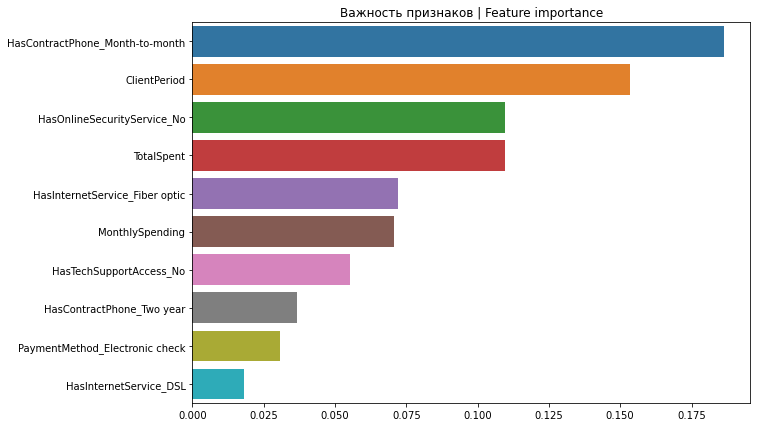

In [264]:
def plot_features_importances(model, columns):
    
    nr_f = 10
    
    f_imp = pd.Series(data = model.best_estimator_.feature_importances_,
                      index = columns).sort_values(ascending=False)
    
    plt.figure(figsize=(10, 7))
    plt.title('Важность признаков | Feature importance')
    sns.barplot(x=f_imp.values[:nr_f], y=f_imp.index[:nr_f], orient='h')
    
plot_features_importances(gs, X_train.columns)

In [265]:
gs.best_estimator_.fit(X, y)
prediction = gs.predict_proba(test_df_ohe)[:, 1]
prediction

array([0.06113764, 0.51699178, 0.65540814, ..., 0.75310403, 0.53436931,
       0.01253687])

In [266]:
write_to_submission_file(prediction, 'prediction_RFC.csv')